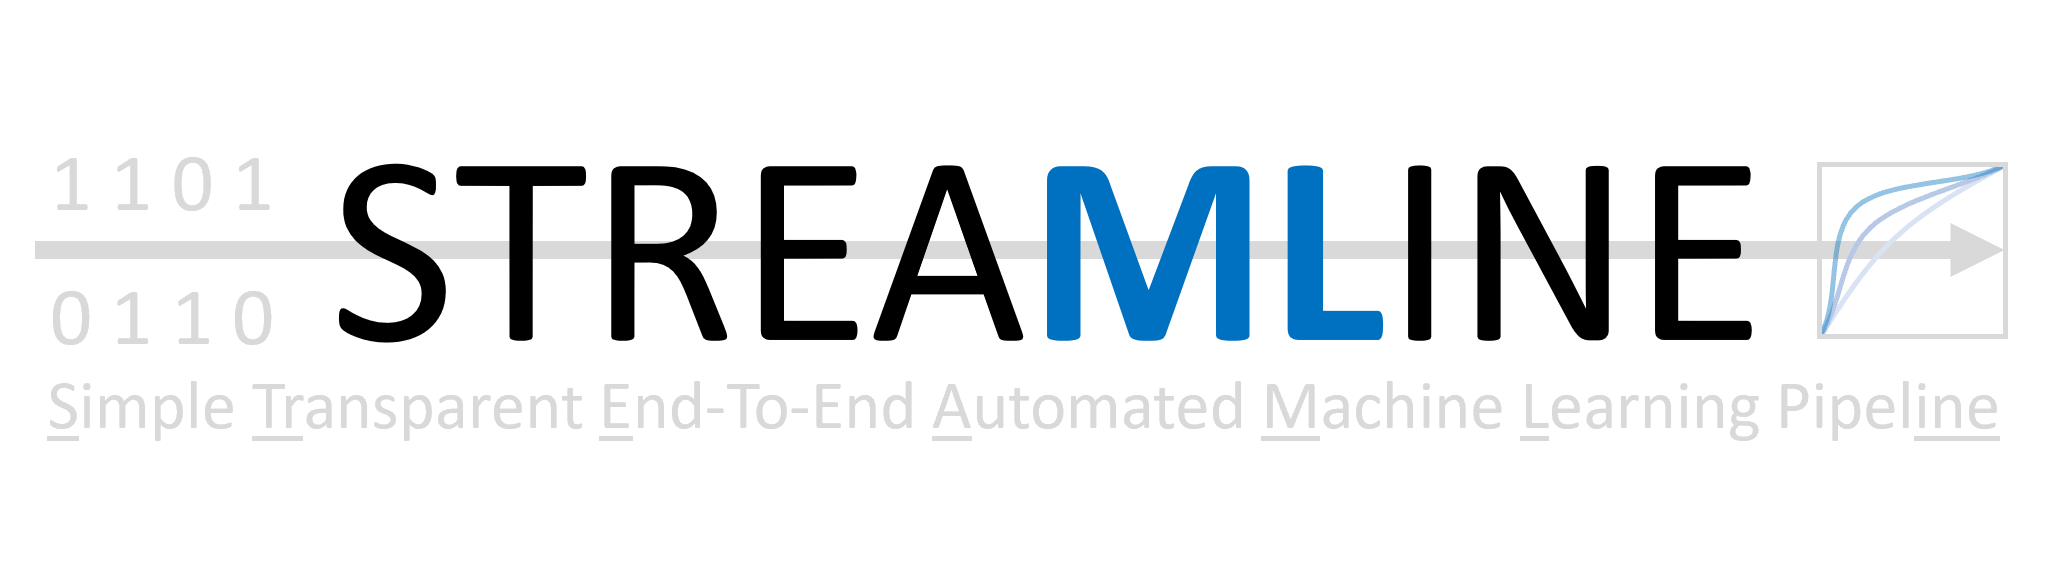

# Summary

This notebook runs all aspects of the STREAMLINE which is an automated machine learning analysis pipeline for binary classification tasks. Of note, two potentially important elements that are not automated by this pipeline include careful data cleaning and feature engineering using problem domain knowledge. Please review the README included in the associated GitHub repository for a detailed overview of how to run this pipeline. For simplicity, this notebook runs Python code outside of what is visible within it. 

This notebook is set up to run 'as-is' on a 'demo' dataset from the UCI repository (HCC dataset) using only three modeling algorithms (so that it runs in a matter of minutes). We analyze a copy of the dataset with and without covariate features to show how this pipline can be run on multiple datasets simultaneously (having the option to compare modeling on these different datasets in a later phase of the pipeline. Users will need to update pipeline run parameters below to ready the pipeline for their own needs. Suggested default run parameters suitible for most users are included, however file paths and names will need to be edited to run anything other than the 'demo' analysis. 

## Notebook Housekeeping
Set up notebook cells to display desired results. No need to edit.

In [1]:
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## -----------------------------------------------------------------------------------------------------------------
## (User Specified) Run Parameters of STREAMLINE
These initial notebook cells include all customizable run parameters for STREAMLINE. These settings should only be left unchanged for users wishing to test out the pipeline demo (as is) to learn how it works or to confirm efficacy before running their own data. Run parameters for each phase of the pipeline are included in separate code cells of this section of the notebook.


### Mandatory Run Parameters for Pipeline

In [2]:
demo_run = False #Leave true to run the local demo dataset (without specifying any datapaths), make False to specify a different data folder path below

#Target dataset folder path(must include one or more .txt or .csv datasets)
data_path = "C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoData" # (str) Demontration Data Path Folder

#Output foder path: where to save pipeline outputs (must be updated for a given user)
output_path = 'C:/Users/ryanu/Documents/Analysis/STREAMLINE_Experiments' # (str) Demonstration Ouput Path Folder

#Unique experiment name - folder created for this analysis within output folder path
experiment_name = 'hcc_demo'  # (str) Demontration Experiment Name

# Data Labels
class_label = 'Class' # (str) i.e. class outcome column label
instance_label = 'InstanceID' # (str) If data includes instance labels, given respective column name here, otherwise put 'None'

#Option to manually specify feature names to leave out of analysis, or which to treat as categorical (without using built in variable type detector)
ignore_features = [] # list of column names (given as string values) to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_feature_headers = [] # empty list for 'auto-detect' otherwise list feature names (given as string values) to be treated as categorical. Only impacts algorithms that can take variable type into account.

### Run Parameters for Phase 1: Exploratory Analysis

In [3]:
cv_partitions = 3  # (int, > 1) Number of training/testing data partitions to create - and resulting number of models generated using each ML algorithm
partition_method = 'S' # (str, S R or M) for stratified, random, or matched, respectively
match_label = 'None' # (str) Only applies when M selected for partition-method; indicates column label with matched instance ids' 

categorical_cutoff = 10 # (int) Bumber of unique values after which a variable is considered to be quantitative vs categorical
sig_cutoff = 0.05 # (float, 0-1) Significance cutoff used throughout pipeline
export_feature_correlations = 'True' # (str, True or False) Run and export feature correlation analysis (yields correlation heatmap)
export_univariate_plots = 'True' # (str, True or False) Export univariate analysis plots (note: univariate analysis still output by default)
topFeatures = 20 # (int) Number of top features to report in notebook for univariate analysis
random_state = 42 # (int) Sets a specific random seed for reproducible results

### Run Parameters for Phase 2: Data Preprocessing

In [4]:
scale_data = 'True' # (str, True or False) Perform data scaling?
impute_data = 'True' # (str, True or False) Perform missing value data imputation? (required for most ML algorithms if missing data is present)
overwrite_cv = 'True' # (str, True or False) Overwrites earlier cv datasets with new scaled/imputed ones
multi_impute = 'True' # (str, True or False) Applies multivariate imputation to quantitative features, otherwise uses mean imputation

### Run Parameters for Phase 3: Feature Importance Evaluation

In [5]:
do_mutual_info = 'True' # (str, True or False) Do mutual information analysis
do_multisurf = 'True' # (str, True or False) Do multiSURF analysis
use_TURF = 'False' # (str, True or False) Use TURF wrapper around MultiSURF
TURF_pct = 0.5 # (float, 0.01-0.5) Proportion of instances removed in an iteration (also dictates number of iterations)
njobs = -1 # (int) Number of cores dedicated to running algorithm; setting to -1 will use all available cores
instance_subset = 2000 # (int) Sample subset size to use with multiSURF

### Run Parameters for Phase 4: Feature Selection

In [6]:
max_features_to_keep = 2000 # (int) Maximum features to keep. 'None' if no max
filter_poor_features = 'True' # (str, True or False) Filter out the worst performing features prior to modeling
top_features = 40 # (int) Number of top features to illustrate in figures
export_scores = 'True' # (str, True or False) Export figure summarizing average feature importance scores over cv partitions

### Run Parameters for Phase 5: Modeling

In [7]:
#ML Model Algorithm Options (individual hyperparameter options can be adjusted below)
do_all = 'False'      # (str, True or False) indicates default value for whether all or none of the algorithms should be run
do_NB = 'True'        # (str, True or False, or None) Run naive bayes modeling
do_LR = 'True'        # (str, True or False, or None) Run logistic regression modeling
do_DT = 'True'        # (str, True or False, or None) Run decision tree modeling
do_RF = 'None'        # (str, True or False, or None) Run random forest modeling
do_GB = 'None'        # (str, True or False, or None) Run gradient boosting modeling
do_XGB = 'None'       # (str, True or False, or None) Run XGBoost modeling
do_LGB = 'None'       # (str, True or False, or None) Run LGBoost modeling
do_CGB = 'None'       # (str, True or False, or None) Run Catboost modeling
do_SVM = 'None'       # (str, True or False, or None) Run support vector machine modeling
do_ANN = 'None'       # (str, True or False, or None) Run artificial neural network modeling
do_KNN = 'None'       # (str, True or False, or None) Run k-neighbors classifier modeling
do_GP = 'None'        # (str, True or False, or None) Run genetic programming symbolic classifier modeling

# ML Algorithms implemented by our reserach group: Rule-based ML Algorithm Options (Computationally expensive, so can be impractical to run hyperparameter sweep)
do_eLCS = 'False'     # (str, True or False, or None) Run eLCS modeling (a basic supervised-learning learning classifier system)
do_XCS = 'False'      # (str, True or False, or None) Run XCS modeling (a supervised-learning-only implementation of the best studied learning classifier system)
do_ExSTraCS = 'None' # (str, True or False, or None) Run ExSTraCS modeling (a learning classifier system designed for biomedical data mining)

#Other Analysis Parameters
training_subsample = 0  # (int) For long running algorithms, option to subsample training set (0 for no subsample) Limit Sample Size Used to train algorithms that do not scale up well in large instance spaces (i.e. XGB,SVM,KN,ANN,and LR to a lesser degree) and depending on 'instances' settings, ExSTraCS, eLCS, and XCS)
use_uniform_FI = 'True' # (str, True or False) Overides use of any available feature importances estimate methods from models, instead using permutation_importance uniformly
primary_metric = 'balanced_accuracy' # (str) Must be an available metric identifier from (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

#Hyperparameter Sweep Options
n_trials = 200   # (int or None) Number of bayesian hyperparameter optimization trials using optuna
timeout = 900    # (int or None) Seconds until hyperparameter sweep stops running new trials (Note: it may run longer to finish last trial started)
export_hyper_sweep_plots = 'True' # (str, True or False) Export hyper parameter sweep plots from optuna

#Learning classifier system specific options (ExSTraCS, eLCS, XCS)
do_lcs_sweep = 'False' # (str, True or False) Do LCS hyperparam tuning or use below params
nu = 1                 # (int, 0-10) Fixed LCS nu param
iterations = 200000    # (int, > data sample size) Fixed LCS # learning iterations param
N = 2000               # (int) > 500) Fixed LCS rule population maximum size param
lcs_timeout = 1200     # (int) Seconds until hyperparameter sweep stops for LCS algorithms (evolutionary algorithms often require more time for a single run)

### Hyperparameter Sweep Options for ML Algorithms
Users can extend or limit the range or options for given ML algorithm hyperparameters to be tested in hyperparameter optimization. These options are hardcoded when running this pipeline from the command line, but they are available here for users to see and modify. We have sought to include a broad range of relevant configurations based on online examples and relevant research publications. Use caution when modifying values below as improper modifications will lead to pipeline errors/failure. Links to available hyperparameter options for each algorithm are included below. 

In [8]:
def hyperparameters(random_state,do_lcs_sweep,nu,iterations,N,feature_names):
    param_grid = {}
    # Naive Bayes - no hyperparameters
    
    # Logistic Regression (Note: can take longer to run in data with larger instance spaces)
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    param_grid_LR = {'penalty': ['l2', 'l1'],'C': [1e-5, 1e5],'dual': [True, False],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'class_weight': [None, 'balanced'],'max_iter': [10, 1000],
                     'random_state':[random_state]}
    
    # Decision Tree
    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree%20classifier#sklearn.tree.DecisionTreeClassifier
    param_grid_DT = {'criterion': ['gini', 'entropy'],'splitter': ['best', 'random'],'max_depth': [1, 30],
                     'min_samples_split': [2, 50],'min_samples_leaf': [1, 50],'max_features': [None, 'auto', 'log2'],
                     'class_weight': [None, 'balanced'],
                     'random_state':[random_state]}
    
    # Random Forest
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier
    param_grid_RF = {'n_estimators': [10, 1000],'criterion': ['gini', 'entropy'],'max_depth': [1, 30],
                     'min_samples_split': [2, 50],'min_samples_leaf': [1, 50],'max_features': [None, 'auto', 'log2'],
                     'bootstrap': [True],'oob_score': [False, True],'class_weight': [None, 'balanced'],
                     'random_state':[random_state]}
    
    # Gradient Boosting Trees
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradient%20boosting#sklearn.ensemble.GradientBoostingClassifier
    param_grid_GB = {'n_estimators': [10, 1000],'loss': ['deviance', 'exponential'], 'learning_rate': [.0001, 0.3], 
                     'min_samples_leaf': [1, 50],'min_samples_split': [2, 50], 'max_depth': [1, 30],
                     'random_state':[random_state]}
    
    # XG Boost (Note: Not great for large instance spaces (limited completion) and class weight balance is included as option internally
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param_grid_XGB = {'booster': ['gbtree'],'objective': ['binary:logistic'],'verbosity': [0],'reg_lambda': [1e-8, 1.0],
                      'alpha': [1e-8, 1.0],'eta': [1e-8, 1.0],'gamma': [1e-8, 1.0],'max_depth': [1, 30],
                      'grow_policy': ['depthwise', 'lossguide'],'n_estimators': [10, 1000],'min_samples_split': [2, 50],
                      'min_samples_leaf': [1, 50],'subsample': [0.5, 1.0],'min_child_weight': [0.1, 10],
                      'colsample_bytree': [0.1, 1.0],'nthread':[1],'seed':[random_state]}

    # LG Boost (Note: class weight balance is included as option internally (still takes a while on large instance spaces))
    # https://lightgbm.readthedocs.io/en/latest/Parameters.html
    param_grid_LGB = {'objective': ['binary'],'metric': ['binary_logloss'],'verbosity': [-1],'boosting_type': ['gbdt'],
                      'num_leaves': [2, 256],'max_depth': [1, 30],'lambda_l1': [1e-8, 10.0],'lambda_l2': [1e-8, 10.0],
                      'feature_fraction': [0.4, 1.0],'bagging_fraction': [0.4, 1.0],'bagging_freq': [1, 7],
                      'min_child_samples': [5, 100],'n_estimators': [10, 1000],'num_threads':[1],'seed':[random_state]}

    # CatBoost - (Note this is newly added, and further optimization to this configuration is possible)
    # https://catboost.ai/en/docs/references/training-parameters/
    param_grid_CGB = {'learning_rate':[.0001, 0.3],'iterations':[10,500],'depth':[1,10],'l2_leaf_reg': [1,9],
                      'loss_function': ['Logloss'], 'random_seed': [random_state]}
    
    # Support Vector Machine (Note: Very slow in large instance spaces)
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    param_grid_SVM = {'kernel': ['linear', 'poly', 'rbf'],'C': [0.1, 1000],'gamma': ['scale'],'degree': [1, 6],
                      'probability': [True],'class_weight': [None, 'balanced'],'random_state':[random_state]}
    
    # Artificial Neural Network (Note: Slow in large instances spaces, and poor performer in small instance spaces)
    # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=artificial%20neural%20network
    param_grid_ANN = {'n_layers': [1, 3],'layer_size': [1, 100],'activation': ['identity', 'logistic', 'tanh', 'relu'],
                      'learning_rate': ['constant', 'invscaling', 'adaptive'],'momentum': [.1, .9],
                      'solver': ['sgd', 'adam'],'batch_size': ['auto'],'alpha': [0.0001, 0.05],'max_iter': [200],
                      'random_state':[random_state]}
    
    # K-Nearest Neighbor Classifier (Note: Runs slowly in data with large instance space)
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier
    param_grid_KNN = {'n_neighbors': [1, 100], 'weights': ['uniform', 'distance'], 'p': [1, 5],
                     'metric': ['euclidean', 'minkowski']}
    
    # Genetic Programming Symbolic Classifier
    # https://gplearn.readthedocs.io/en/stable/reference.html
    param_grid_GP = {'population_size': [100, 1000], 'generations': [10, 500], 'tournament_size': [3, 50],'init_method': ['grow', 'full','half and half'],
                     'function_set': [['add', 'sub', 'mul', 'div'], ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min'], ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min','sin','cos','tan']],
                     'parsimony_coefficient': [0.001,0.01],'feature_names': [feature_names], 'low_memory': [True],'random_state': [random_state]}

    # Learning Classifier Systems (i.e. eLCS, XCS, and ExSTraCS)
    # https://github.com/UrbsLab/scikit-eLCS
    # https://github.com/UrbsLab/scikit-XCS
    # https://github.com/UrbsLab/scikit-ExSTraCS
    
    if eval(do_lcs_sweep):
        # eLCS
        param_grid_eLCS = {'learning_iterations': [100000,200000,500000],'N': [1000,2000,5000],'nu': [1,10],
                           'random_state':[random_state]}
        # XCS
        param_grid_XCS = {'learning_iterations': [100000,200000,500000],'N': [1000,2000,5000],'nu': [1,10],
                          'random_state':[random_state]}
        # ExSTraCS
        param_grid_ExSTraCS = {'learning_iterations': [100000,200000,500000],'N': [1000,2000,5000],'nu': [1,10],
                               'random_state':[random_state],'rule_compaction':[None]}
    else:
        # eLCS
        param_grid_eLCS = {'learning_iterations': [iterations], 'N': [N], 'nu': [nu], 'random_state': [random_state]}
        # XCS
        param_grid_XCS = {'learning_iterations': [iterations], 'N': [N], 'nu': [nu], 'random_state': [random_state]}
        # ExSTraCS
        param_grid_ExSTraCS = {'learning_iterations': [iterations], 'N': [N], 'nu': [nu], 'random_state': [random_state], 
                               'rule_compaction': ['QRF']} # 'None','QRF' - which is quick rule filter
        
    #Leave code below as is...
    param_grid['Naive Bayes'] = {}
    param_grid['Logistic Regression'] = param_grid_LR
    param_grid['Decision Tree'] = param_grid_DT
    param_grid['Random Forest'] = param_grid_RF
    param_grid['Gradient Boosting'] = param_grid_GB
    param_grid['Extreme Gradient Boosting'] = param_grid_XGB
    param_grid['Light Gradient Boosting'] = param_grid_LGB
    param_grid['Category Gradient Boosting'] = param_grid_CGB
    param_grid['Support Vector Machine'] = param_grid_SVM
    param_grid['Artificial Neural Network'] = param_grid_ANN
    param_grid['K-Nearest Neightbors'] = param_grid_KNN
    param_grid['Genetic Programming'] = param_grid_GP
    param_grid['eLCS'] = param_grid_eLCS
    param_grid['XCS'] = param_grid_XCS
    param_grid['ExSTraCS'] = param_grid_ExSTraCS
    return param_grid

### Run Parameters for Phase 6:  Statistics Summary and Figure Generation

In [9]:
plot_ROC = 'True'    # (str, True or False) Plot ROC curves individually for each algorithm including all CV results and averages
plot_PRC = 'True'    # (str, True or False) Plot PRC curves individually for each algorithm including all CV results and averages
plot_FI_box = 'True' # (str, True or False) Plot box plot summaries comparing algorithms for each metric
plot_metric_boxplots = 'True' # (str, True or False) Plot feature importance boxplots for each algorithm
metric_weight = 'balanced_accuracy' # (str, balanced_accuracy or roc_auc) ML model metric used as weight in composite FI plots (only supports balanced_accuracy or roc_auc as options) Recommend setting the same as primary_metric if possible.
top_model_features = 40  # (int) Number of top features in model to illustrate in figures

### Run Parameters for Phase 10:  Apply Models to Replication Dataset
An optional phase to apply all trained models from previous phases to a separate 'replication' dataset which will be used to evaluate models across all algorithms and CV splits. In this demo, we didn't have a separate replication dataset to use for the UCI HCC dataset evaluated. Thus here we use a copy of the original HCC dataset as a 'pretend' replication dataset to demonstrate functionality. The replication data folder can include 1 or more datasets that can be evaluated as separate replication data. The user also needs to 

In [10]:
applyToReplication = True # (Boolean, True or False) Leave false unless you have a replication dataset handy to further evaluate/compare all models in uniform manner
rep_data_path = "C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoRepData" # (txt) Name of folder with replication Dataset(s)
dataset_for_rep = "C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoData/hcc-data_example.csv" # (txt) Path and name of dataset used to generate the models we want to apply (not the replication dataset)

### Run Parameters for Phase 11:  File Cleanup
An optional phase to delete all unnecessary/temporary files generated by the pipeline.

In [11]:
del_time = 'True'  # (str, True or False) Delete individual run-time files (but save summary)
del_oldCV = 'True' # (str, True or False) Delete any of the older versions of CV training and testing datasets not overwritten (preserves final training and testing datasets)

## -----------------------------------------------------------------------------------------------------------------
## Phase 1: Exploratory Analysis

### Identify Working Directory

In [12]:
wd_path = os.getcwd() #Working directory path automatically detected
wd_path = wd_path.replace('\\','/')
sys.path.insert(1, wd_path+'/streamline')

### Import Python Packages

In [13]:
import glob
import time
import csv
import pandas as pd
import numpy as np
import random
import pickle
import ExploratoryAnalysisMain
import ExploratoryAnalysisJob

### Demo Setup
Bypasses whatever user may have entered into 'data_path' variable to ensure proper loading of local 'demo' dataset.

In [14]:
if demo_run:
    data_path = wd_path+'/DemoData'
print("Data Folder Path: "+data_path)
jupyterRun = 'True' #Leave True or pipeline will not display text or figures

Data Folder Path: C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoData


### Run Exploratory Analysis

In [15]:
ExploratoryAnalysisMain.makeDirTree(data_path,output_path,experiment_name,jupyterRun)

---------------------------------------------------------------------------------
C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoData/hcc-data_example.csv
Loading Dataset: hcc-data_example
Cleaning Dataset...
Identifying Feature Types...
Running Basic Exploratory Analysis...


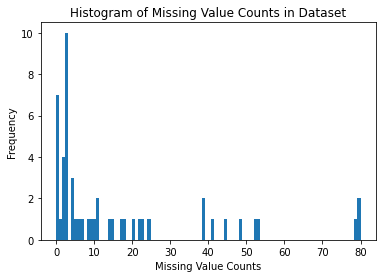

Data Counts: ----------------
Instance Count = 165
Feature Count = 49
    Categorical  = 27
    Quantitative = 22
Missing Count = 826
    Missing Percent = 0.10216450216450217
Class Counts: ----------------
0    102
1     63
Name: Class, dtype: int64


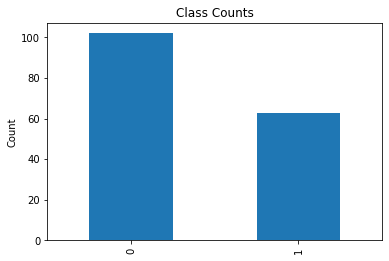

Generating Feature Correlation Heatmap...


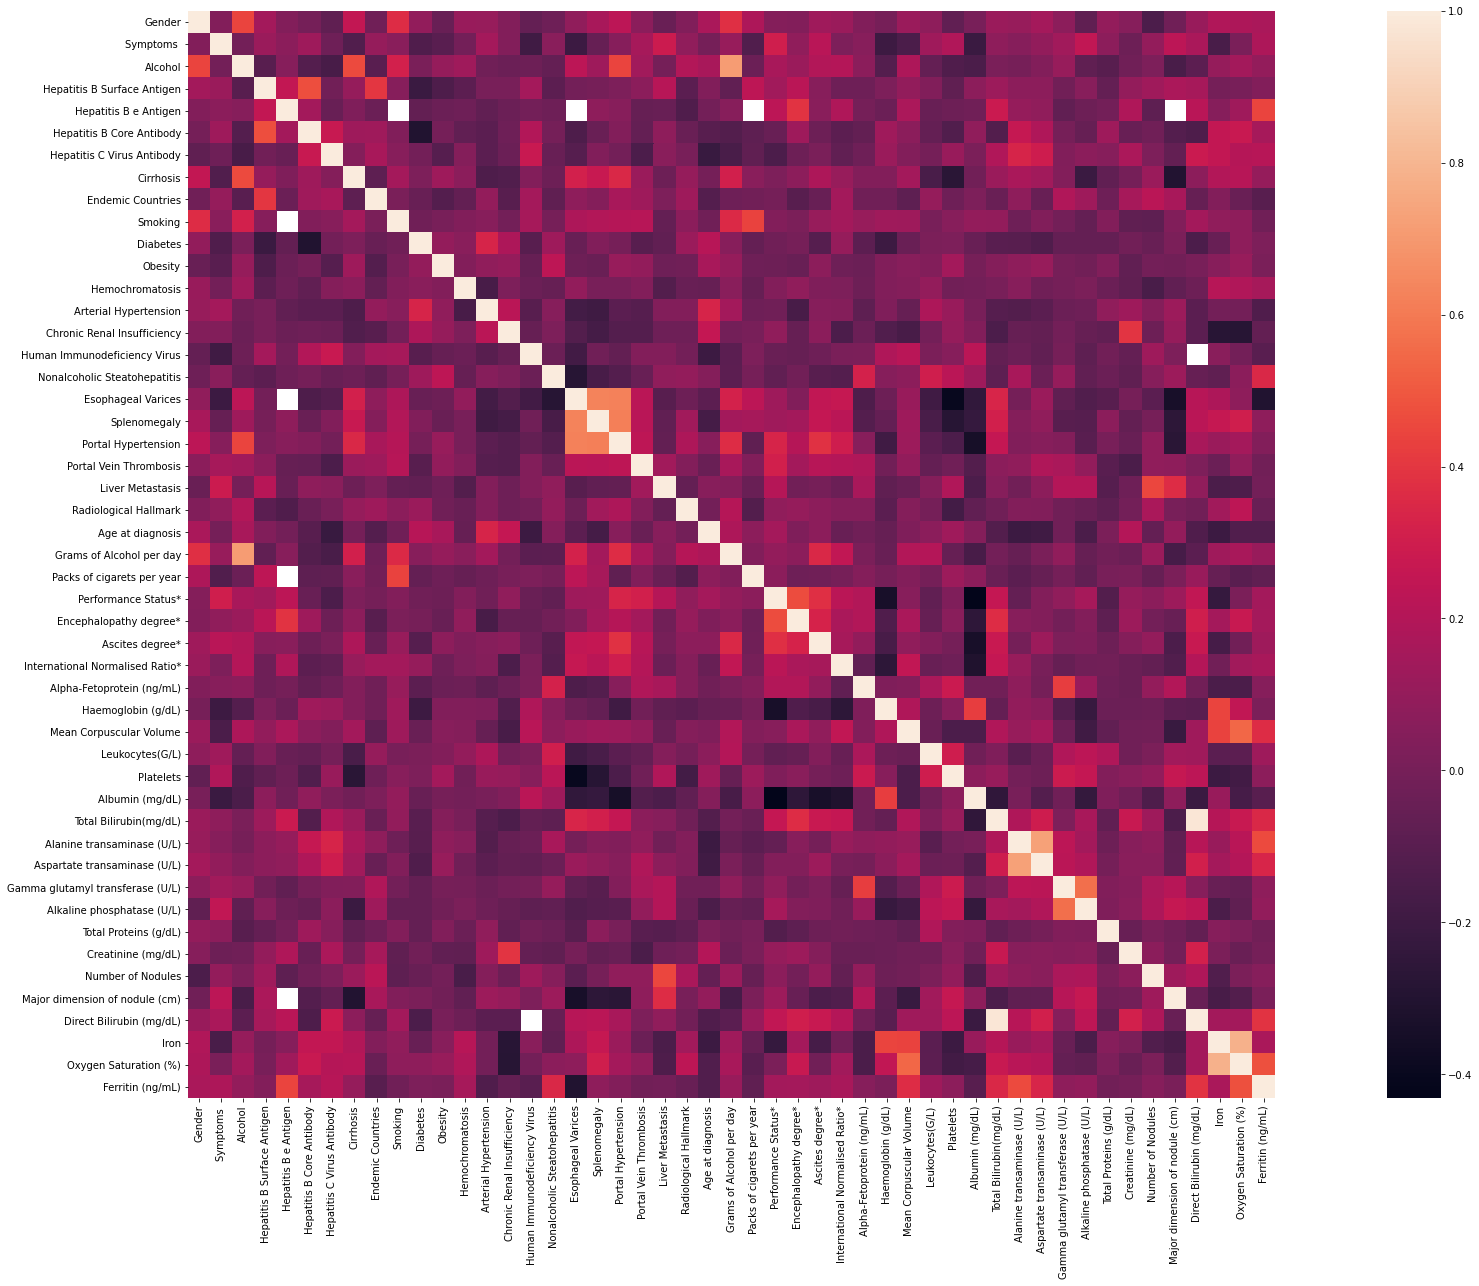

Running Univariate Analyses...
Plotting top significant 20 features.
###################################################
Significant Univariate Associations:
Alkaline phosphatase (U/L): (p-val = 3.5403912777218106e-06)
Iron: (p-val = 3.5423866432400713e-06)
Alpha-Fetoprotein (ng/mL): (p-val = 1.0082106490397668e-05)
Haemoglobin (g/dL): (p-val = 1.3037749087103508e-05)
Performance Status*: (p-val = 3.2548676278782114e-05)
Oxygen Saturation (%): (p-val = 3.998706534072513e-05)
Albumin (mg/dL): (p-val = 5.159435074542993e-05)
Symptoms : (p-val = 0.0006092985105592953)
Aspartate transaminase (U/L): (p-val = 0.002884797765802902)
Liver Metastasis: (p-val = 0.002993588224869906)
Ascites degree*: (p-val = 0.0038134308539161175)
Ferritin (ng/mL): (p-val = 0.004446494113520735)
Portal Vein Thrombosis: (p-val = 0.01174304115542567)
Major dimension of nodule (cm): (p-val = 0.01569067499758109)
Age at diagnosis: (p-val = 0.01784161875604351)
Gamma glutamyl transferase (U/L): (p-val = 0.02438867167

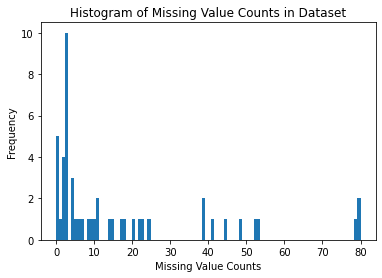

Data Counts: ----------------
Instance Count = 165
Feature Count = 47
    Categorical  = 26
    Quantitative = 21
Missing Count = 826
    Missing Percent = 0.10651192778852353
Class Counts: ----------------
0    102
1     63
Name: Class, dtype: int64


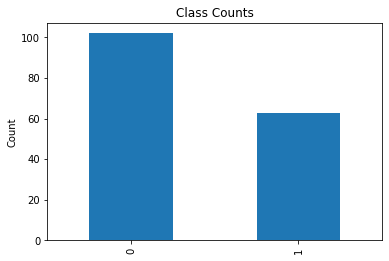

Generating Feature Correlation Heatmap...


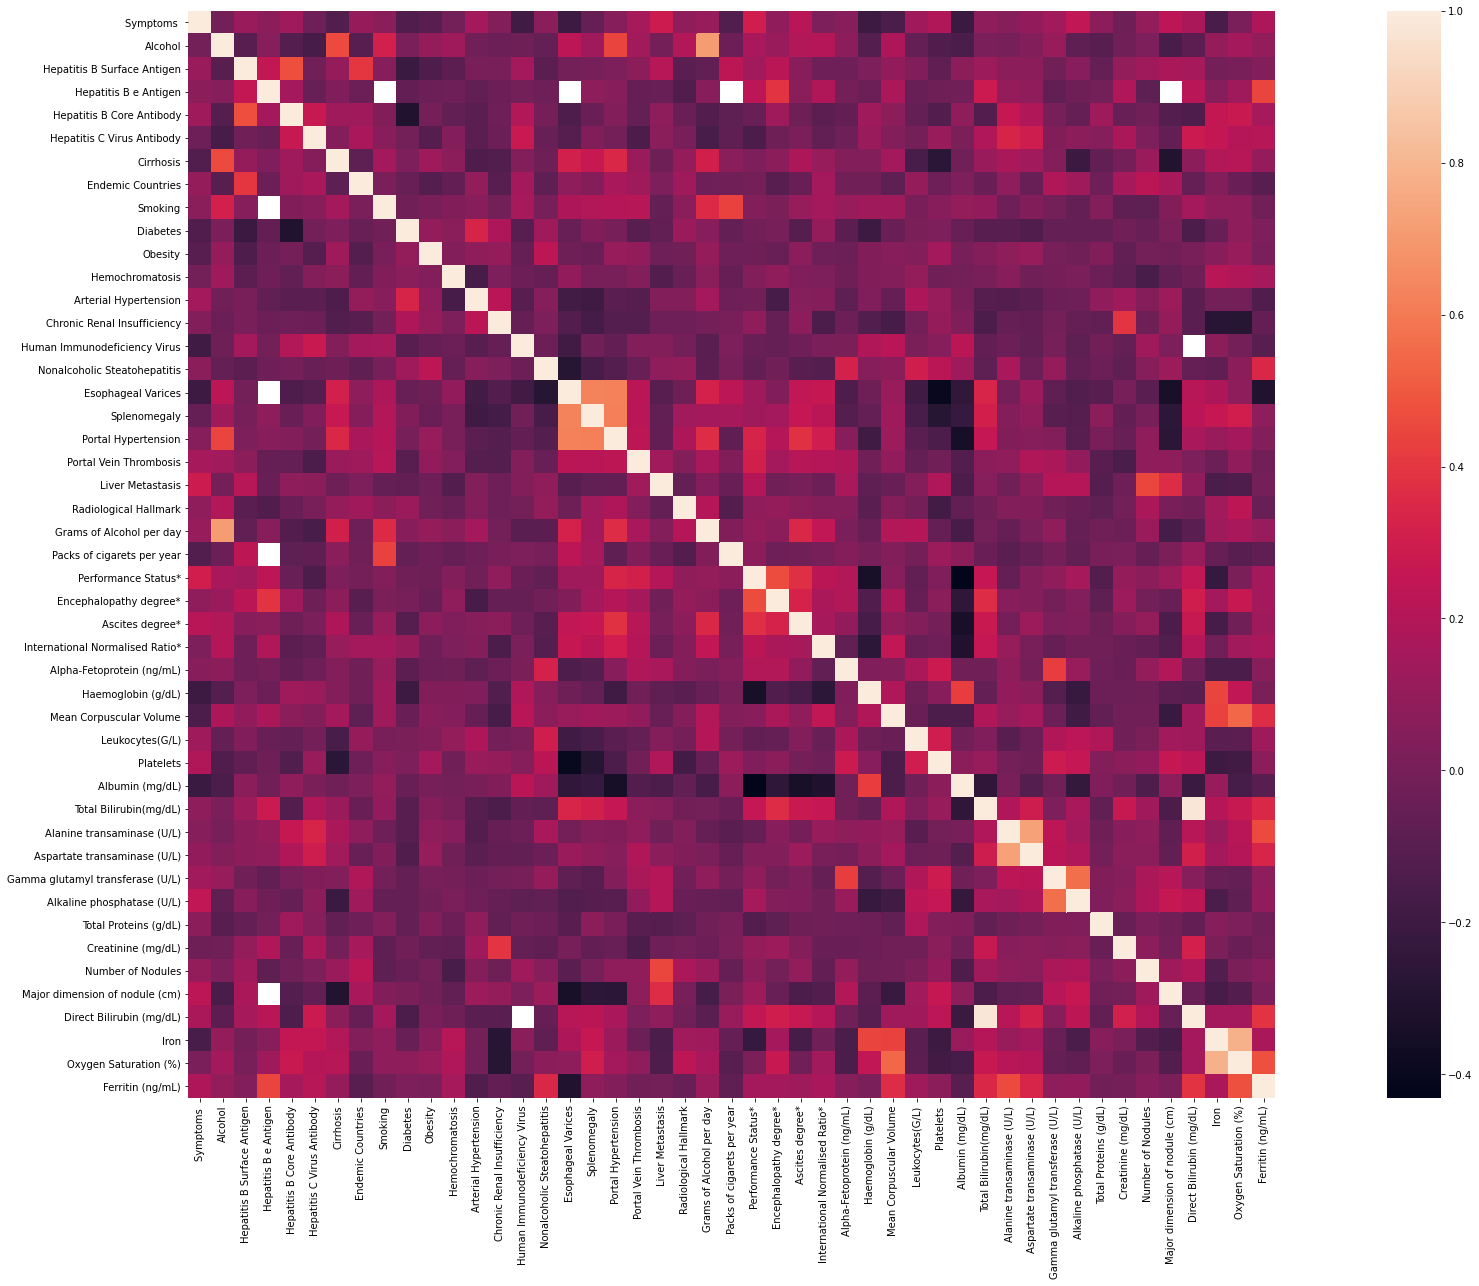

Running Univariate Analyses...
Plotting top significant 20 features.
###################################################
Significant Univariate Associations:
Alkaline phosphatase (U/L): (p-val = 3.5403912777218106e-06)
Iron: (p-val = 3.5423866432400713e-06)
Alpha-Fetoprotein (ng/mL): (p-val = 1.0082106490397668e-05)
Haemoglobin (g/dL): (p-val = 1.3037749087103508e-05)
Performance Status*: (p-val = 3.2548676278782114e-05)
Oxygen Saturation (%): (p-val = 3.998706534072513e-05)
Albumin (mg/dL): (p-val = 5.159435074542993e-05)
Symptoms : (p-val = 0.0006092985105592953)
Aspartate transaminase (U/L): (p-val = 0.002884797765802902)
Liver Metastasis: (p-val = 0.002993588224869906)
Ascites degree*: (p-val = 0.0038134308539161175)
Ferritin (ng/mL): (p-val = 0.004446494113520735)
Portal Vein Thrombosis: (p-val = 0.01174304115542567)
Major dimension of nodule (cm): (p-val = 0.01569067499758109)
Gamma glutamyl transferase (U/L): (p-val = 0.02438867167652392)
Total Proteins (g/dL): (p-val = 0.029520

In [16]:
#Determine file extension of datasets in target folder:
file_count = 0
unique_datanames = []
for dataset_path in glob.glob(data_path+'/*'):
    dataset_path = str(dataset_path).replace('\\','/')
    print('---------------------------------------------------------------------------------')
    print(dataset_path)
    file_extension = dataset_path.split('/')[-1].split('.')[-1]
    data_name = dataset_path.split('/')[-1].split('.')[0] #Save unique dataset names so that analysis is run only once if there is both a .txt and .csv version of dataset with same name.
    if file_extension == 'txt' or file_extension == 'csv':
        if data_name not in unique_datanames:
            unique_datanames.append(data_name)
            ExploratoryAnalysisJob.runExplore(dataset_path,output_path+'/'+experiment_name,cv_partitions,partition_method,categorical_cutoff,export_feature_correlations,export_univariate_plots,class_label,instance_label,match_label,random_state,ignore_features,categorical_feature_headers,sig_cutoff,jupyterRun)
            file_count += 1

if file_count == 0: #Check that there was at least 1 dataset
    raise Exception("There must be at least one .txt or .csv dataset in data_path directory")

#Create metadata dictionary object to keep track of pipeline run paramaters throughout phases
metadata = {}
metadata['Data Path'] = data_path
metadata['Output Path'] = output_path
metadata['Experiment Name'] = experiment_name
metadata['Class Label'] = class_label
metadata['Instance Label'] = instance_label
metadata['Ignored Features'] = ignore_features
metadata['Specified Categorical Features'] = categorical_feature_headers
metadata['CV Partitions'] = cv_partitions
metadata['Partition Method'] = partition_method
metadata['Match Label'] = match_label
metadata['Categorical Cutoff'] = categorical_cutoff
metadata['Statistical Significance Cutoff'] = sig_cutoff
metadata['Export Feature Correlations'] = export_feature_correlations
metadata['Export Univariate Plots'] = export_univariate_plots
metadata['Random Seed'] = random_state
metadata['Run From Jupyter Notebook'] = jupyterRun
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

## -----------------------------------------------------------------------------------------------------------------
## Phase 2: Data Preprocessing

### Import Additional Python Packages

In [17]:
import DataPreprocessingJob

### Run Data Preprocessing

In [18]:
dataset_paths = os.listdir(output_path+"/"+experiment_name)
dataset_paths.remove('metadata.pickle')
for dataset_directory_path in dataset_paths:
    full_path = output_path+"/"+experiment_name+"/"+dataset_directory_path
    for cv_train_path in glob.glob(full_path+"/CVDatasets/*Train.csv"):
        cv_train_path = str(cv_train_path).replace('\\','/')
        cv_test_path = cv_train_path.replace("Train.csv","Test.csv")
        DataPreprocessingJob.job(cv_train_path,cv_test_path,output_path+'/'+experiment_name,scale_data,impute_data,overwrite_cv,categorical_cutoff,class_label,instance_label,random_state,multi_impute,jupyterRun)

#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file) 
file.close()
    
#Update metadata
metadata['Use Data Scaling'] = scale_data
metadata['Use Data Imputation'] = impute_data
metadata['Use Multivariate Imputation'] = multi_impute
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

Preparing Train and Test for: hcc-data_example_CV_0
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example phase 2 complete
Preparing Train and Test for: hcc-data_example_CV_1
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example phase 2 complete
Preparing Train and Test for: hcc-data_example_CV_2
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example phase 2 complete
Preparing Train and Test for: hcc-data_example_no_covariates_CV_0
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example_no_covariates phase 2 complete
Preparing Train and Test for: hcc-data_example_no_covariates_CV_1
Imputing Missing Values...
Scaling Data Values...
Saving Processed Train and Test Data...
hcc-data_example_no_covariates phase 2 complete
Preparing Train and Test for: hcc-data_example_no_covariates_CV_

## -----------------------------------------------------------------------------------------------------------------
## Phase 3: Feature Importance Evaluation

### Import Additional Python Packages

In [19]:
import FeatureImportanceJob

### Run Feature Importance Evaluation

In [20]:
dataset_paths = os.listdir(output_path+"/"+experiment_name)
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in dataset_paths:
        dataset_paths.remove(text)

for dataset_directory_path in dataset_paths:
    full_path = output_path+"/"+experiment_name+"/"+dataset_directory_path
    experiment_path = output_path+'/'+experiment_name

    if eval(do_mutual_info) or eval(do_multisurf):
        if not os.path.exists(full_path+"/feature_selection"):
            os.mkdir(full_path+"/feature_selection")
            
    if eval(do_mutual_info):
        if not os.path.exists(full_path+"/feature_selection/mutualinformation"):
            os.mkdir(full_path+"/feature_selection/mutualinformation")
        for cv_train_path in glob.glob(full_path+"/CVDatasets/*_CV_*Train.csv"):
            cv_train_path = str(cv_train_path).replace('\\','/')
            FeatureImportanceJob.job(cv_train_path,experiment_path,random_state,class_label,instance_label,instance_subset,'mi',njobs,use_TURF,TURF_pct,jupyterRun)

    if eval(do_multisurf):
        if not os.path.exists(full_path+"/feature_selection/multisurf"):
            os.mkdir(full_path+"/feature_selection/multisurf")
        for cv_train_path in glob.glob(full_path+"/CVDatasets/*_CV_*Train.csv"):
            cv_train_path = str(cv_train_path).replace('\\','/')
            FeatureImportanceJob.job(cv_train_path,experiment_path,random_state,class_label,instance_label,instance_subset,'ms',njobs,use_TURF,TURF_pct,jupyterRun)

#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file) 
file.close()

#Update metadata
metadata['Use Mutual Information'] = do_mutual_info
metadata['Use MultiSURF'] = do_multisurf
metadata['Use TURF'] = use_TURF
metadata['TURF Cutoff'] = TURF_pct
metadata['MultiSURF Instance Subset'] = instance_subset
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

Prepared Train and Test for: hcc-data_example_CV_0
Running Mutual Information...
Sort and pickle feature importance scores...
hcc-data_example CV0 phase 3 mutualinformation evaluation complete
Prepared Train and Test for: hcc-data_example_CV_1
Running Mutual Information...
Sort and pickle feature importance scores...
hcc-data_example CV1 phase 3 mutualinformation evaluation complete
Prepared Train and Test for: hcc-data_example_CV_2
Running Mutual Information...
Sort and pickle feature importance scores...
hcc-data_example CV2 phase 3 mutualinformation evaluation complete
Prepared Train and Test for: hcc-data_example_CV_0
Running MultiSURF...
Sort and pickle feature importance scores...
hcc-data_example CV0 phase 3 multisurf evaluation complete
Prepared Train and Test for: hcc-data_example_CV_1
Running MultiSURF...
Sort and pickle feature importance scores...
hcc-data_example CV1 phase 3 multisurf evaluation complete
Prepared Train and Test for: hcc-data_example_CV_2
Running MultiSURF.

## -----------------------------------------------------------------------------------------------------------------
## Phase 4: Feature Selection

### Import Additional Python Packages

In [21]:
import FeatureSelectionJob

### Run Feature Selection

Plotting Feature Importance Scores...
{'Gender': 0.06861690244682284, 'Symptoms ': 0.0, 'Alcohol': 0.0, 'Hepatitis B Surface Antigen': 0.017211448126929874, 'Hepatitis B e Antigen': 0.0, 'Hepatitis B Core Antibody': 0.0, 'Hepatitis C Virus Antibody': 0.0, 'Cirrhosis': 0.0, 'Endemic Countries': 0.0, 'Smoking': 0.015396259453452465, 'Diabetes': 0.0, 'Obesity': 0.0, 'Hemochromatosis': 0.0, 'Arterial Hypertension': 0.0, 'Chronic Renal Insufficiency': 0.0, 'Human Immunodeficiency Virus': 0.0, 'Nonalcoholic Steatohepatitis': 0.036339814561446415, 'Esophageal Varices': 0.01221512240867928, 'Splenomegaly': 0.07095338281137797, 'Portal Hypertension': 0.0, 'Portal Vein Thrombosis': 0.005189247956334242, 'Liver Metastasis': 0.005379005856126051, 'Radiological Hallmark': 0.0013169586294992097, 'Age at diagnosis': 0.039721261676572084, 'Grams of Alcohol per day': 0.0, 'Packs of cigarets per year': 0.02998023979278086, 'Performance Status*': 0.14763438526109707, 'Encephalopathy degree*': 0.032050980

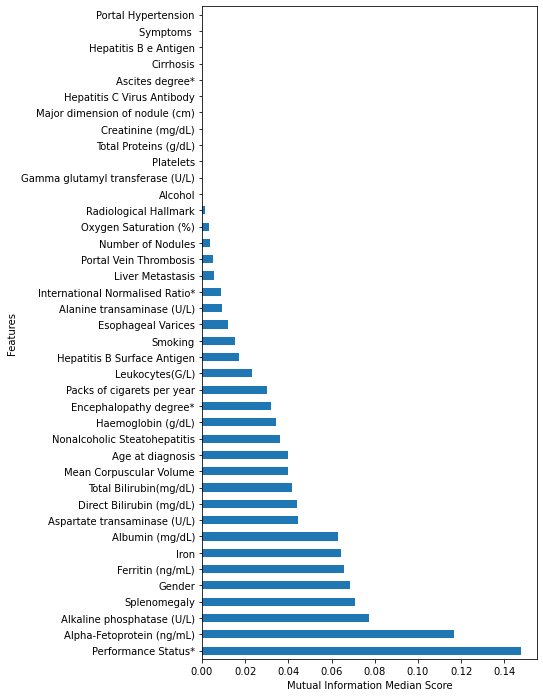

{'Gender': -0.024722917751575292, 'Symptoms ': 0.0220685155234058, 'Alcohol': -0.02378680271981729, 'Hepatitis B Surface Antigen': 0.005476091701668119, 'Hepatitis B e Antigen': 0.0, 'Hepatitis B Core Antibody': -0.016570209252265534, 'Hepatitis C Virus Antibody': 0.009838843362864917, 'Cirrhosis': -0.002675165032172289, 'Endemic Countries': -0.00048346703759488766, 'Smoking': -0.01940843276413983, 'Diabetes': -0.005552288618785073, 'Obesity': -0.021267457865846794, 'Hemochromatosis': -0.010936642250414939, 'Arterial Hypertension': -0.036914970425651054, 'Chronic Renal Insufficiency': 0.001450216040524566, 'Human Immunodeficiency Virus': -0.000772536620529991, 'Nonalcoholic Steatohepatitis': -0.007750776694908926, 'Esophageal Varices': -0.027791467047005997, 'Splenomegaly': -0.039505962836139934, 'Portal Hypertension': -0.0023436763842945773, 'Portal Vein Thrombosis': 0.04068668571213011, 'Liver Metastasis': 0.047879430092895824, 'Radiological Hallmark': -0.028907088451512967, 'Age at 

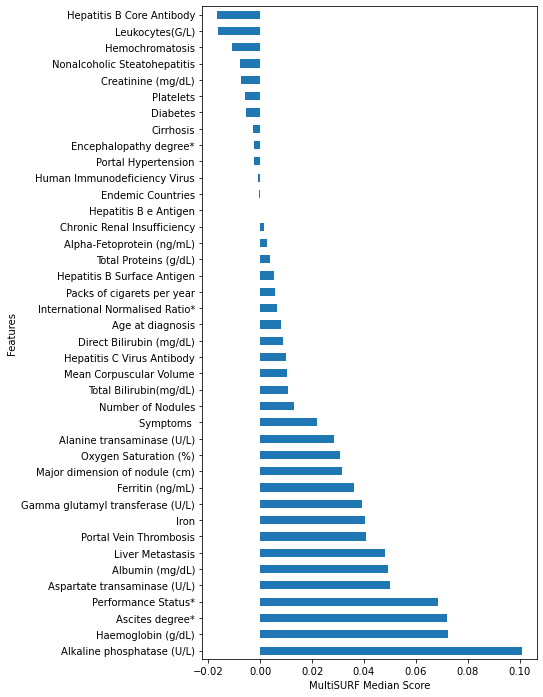

Applying collective feature selection...
hcc-data_example phase 4 complete
Plotting Feature Importance Scores...
{'Symptoms ': 0.0428056429991992, 'Alcohol': 0.0, 'Hepatitis B Surface Antigen': 0.0, 'Hepatitis B e Antigen': 0.0, 'Hepatitis B Core Antibody': 0.0, 'Hepatitis C Virus Antibody': 0.00983375565178446, 'Cirrhosis': 0.0111343886742028, 'Endemic Countries': 0.014568202335288216, 'Smoking': 0.0, 'Diabetes': 0.03593239369947954, 'Obesity': 0.0, 'Hemochromatosis': 0.0, 'Arterial Hypertension': 0.02623880446043647, 'Chronic Renal Insufficiency': 0.0036262780979101628, 'Human Immunodeficiency Virus': 0.0, 'Nonalcoholic Steatohepatitis': 0.022693309551304885, 'Esophageal Varices': 0.13192301552566277, 'Splenomegaly': 0.05363141279028061, 'Portal Hypertension': 0.0, 'Portal Vein Thrombosis': 0.03584929498001754, 'Liver Metastasis': 0.0003364996944952292, 'Radiological Hallmark': 0.03497181387526327, 'Grams of Alcohol per day': 0.0, 'Packs of cigarets per year': 0.04115608415044325, 'P

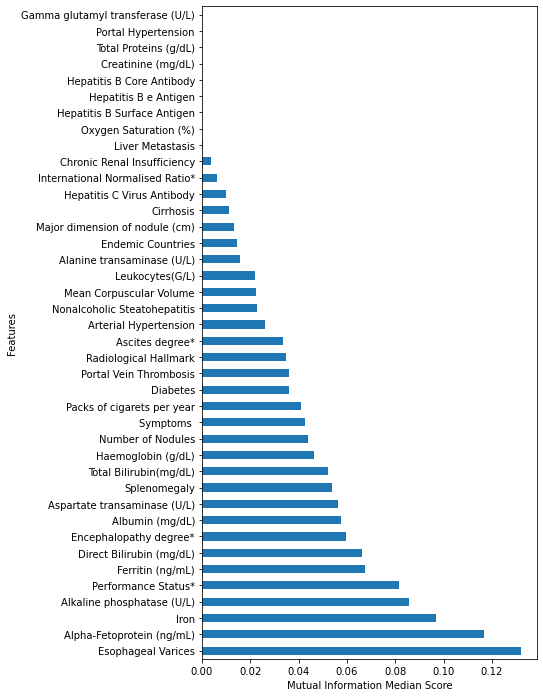

{'Symptoms ': 0.026836205188229992, 'Alcohol': -0.022709919139262146, 'Hepatitis B Surface Antigen': 0.004328618696095453, 'Hepatitis B e Antigen': 0.0, 'Hepatitis B Core Antibody': -0.016144604600006718, 'Hepatitis C Virus Antibody': 0.018384864932433014, 'Cirrhosis': -0.0028591242250772665, 'Endemic Countries': -0.0002919447045211548, 'Smoking': -0.023458968699736203, 'Diabetes': -0.0031201120969709803, 'Obesity': -0.024541625385649992, 'Hemochromatosis': -0.008880970116813283, 'Arterial Hypertension': -0.04125295004768928, 'Chronic Renal Insufficiency': 0.0021072045423666218, 'Human Immunodeficiency Virus': -0.0013765989814102124, 'Nonalcoholic Steatohepatitis': -0.01178521769362818, 'Esophageal Varices': -0.029688274750198498, 'Splenomegaly': -0.0352669990521418, 'Portal Hypertension': -0.0027087897852795216, 'Portal Vein Thrombosis': 0.03368343791116611, 'Liver Metastasis': 0.05301843360127519, 'Radiological Hallmark': -0.03333226027415693, 'Grams of Alcohol per day': -0.033686613

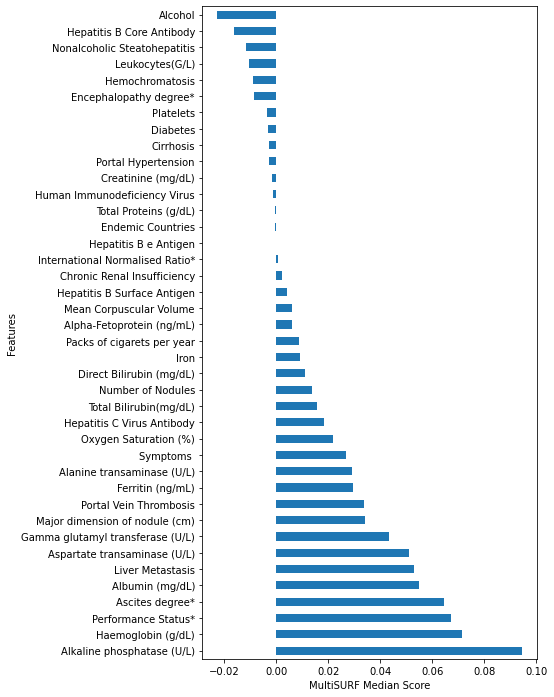

Applying collective feature selection...
hcc-data_example_no_covariates phase 4 complete


In [22]:
dataset_paths = os.listdir(output_path + "/" + experiment_name)
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in dataset_paths:
        dataset_paths.remove(text)

for dataset_directory_path in dataset_paths:
    full_path = output_path + "/" + experiment_name + "/" + dataset_directory_path
    FeatureSelectionJob.job(full_path,do_mutual_info,do_multisurf,max_features_to_keep,filter_poor_features,top_features,export_scores,class_label,instance_label,cv_partitions,overwrite_cv,jupyterRun)

#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()

#Update metadata
metadata['Max Features to Keep'] = max_features_to_keep
metadata['Filter Poor Features'] = filter_poor_features
metadata['Top Features to Display'] = top_features
metadata['Export Feature Importance Plot'] = export_scores
metadata['Overwrite CV Datasets'] = overwrite_cv
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

## -----------------------------------------------------------------------------------------------------------------
## Phase 5: ML Modeling

### Phase 5 Import Additional Python Packages

In [23]:
import ModelJob

In [24]:
#Create ML modeling algorithm information dictionary, given as ['algorithm used (set to true initially by default)','algorithm abreviation', 'color used for algorithm on figures']
### Note that other named colors used by matplotlib can be found here: https://matplotlib.org/3.5.0/_images/sphx_glr_named_colors_003.png
### Make sure new ML algorithm abbreviations and color designations are unique
algInfo = {}
algInfo['Naive Bayes'] = [True,'NB','silver']
algInfo['Logistic Regression'] = [True,'LR','dimgrey']
algInfo['Decision Tree'] = [True,'DT','yellow']
algInfo['Random Forest'] = [True,'RF','blue']
algInfo['Gradient Boosting'] = [True,'GB','cornflowerblue']
algInfo['Extreme Gradient Boosting'] = [True,'XGB','cyan']
algInfo['Light Gradient Boosting'] = [True,'LGB','pink']
algInfo['Category Gradient Boosting'] = [True,'CGB','magenta']
algInfo['Support Vector Machine'] = [True,'SVM','orange']
algInfo['Artificial Neural Network'] = [True,'ANN','red']
algInfo['K-Nearest Neightbors'] = [True,'KNN','chocolate']
algInfo['Genetic Programming'] = [True,'GP','purple']
algInfo['eLCS'] = [True,'eLCS','green']
algInfo['XCS'] = [True,'XCS','olive']
algInfo['ExSTraCS'] = [True,'ExSTraCS','lawngreen']
### Add new algorithms here...

#Set up ML algorithm True/False use
if not eval(do_all): #If do all algorithms is false
    for key in algInfo:
        algInfo[key][0] = False #Set algorithm use to False

#Set algorithm use truth for each algorithm specified by user (i.e. if user specified True/False for a specific algorithm)
if not do_NB == 'None':
    algInfo['Naive Bayes'][0] = eval(do_NB)
if not do_LR == 'None':
    algInfo['Logistic Regression'][0] = eval(do_LR)
if not do_DT == 'None':
    algInfo['Decision Tree'][0] = eval(do_DT)
if not do_RF == 'None':
    algInfo['Random Forest'][0] = eval(do_RF)
if not do_GB == 'None':
    algInfo['Gradient Boosting'][0] = eval(do_GB)
if not do_XGB == 'None':
    algInfo['Extreme Gradient Boosting'][0] = eval(do_XGB)
if not do_LGB == 'None':
    algInfo['Light Gradient Boosting'][0] = eval(do_LGB)
if not do_CGB == 'None':
    algInfo['Category Gradient Boosting'][0] = eval(do_CGB)
if not do_SVM == 'None':
    algInfo['Support Vector Machine'][0] = eval(do_SVM)
if not do_ANN == 'None':
    algInfo['Artificial Neural Network'][0] = eval(do_ANN)
if not do_KNN == 'None':
    algInfo['K-Nearest Neightbors'][0] = eval(do_KNN)
if not do_GP == 'None':
    algInfo['Genetic Programming'][0] = eval(do_GP)
if not do_eLCS == 'None':
    algInfo['eLCS'][0] = eval(do_eLCS)
if not do_XCS == 'None':
    algInfo['XCS'][0] = eval(do_XCS)
if not do_ExSTraCS == 'None':
    algInfo['ExSTraCS'][0] = eval(do_ExSTraCS)
### Add new algorithms here...

#Pickle the algorithm information dictionary for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"algInfo.pickle", 'wb')
pickle.dump(algInfo,pickle_out)
pickle_out.close()

#Make list of algorithms to be run (full names)
algorithms = []
for key in algInfo:
    if algInfo[key][0]: #Algorithm is true
        algorithms.append(key)

### Run ML Modeling

In [25]:
dataset_paths = os.listdir(output_path + "/" + experiment_name)
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in dataset_paths:
        dataset_paths.remove(text)
for dataset_directory_path in dataset_paths:
    full_path = output_path + "/" + experiment_name + "/" + dataset_directory_path
    if not os.path.exists(full_path+'/models'):
        os.mkdir(full_path+'/models')
    if not os.path.exists(full_path+'/model_evaluation'):
        os.mkdir(full_path+'/model_evaluation')
    if not os.path.exists(full_path+'/models/pickledModels'):
        os.mkdir(full_path+'/models/pickledModels')

    for cvCount in range(cv_partitions):
        train_file_path = full_path+'/CVDatasets/'+dataset_directory_path+"_CV_"+str(cvCount)+"_Train.csv"
        test_file_path = full_path + '/CVDatasets/' + dataset_directory_path + "_CV_" + str(cvCount) + "_Test.csv"
        for algorithm in algorithms:
            algAbrev = algInfo[algorithm][1]
            #Get header names for current CV dataset for use later in GP tree visulaization
            data_name = full_path.split('/')[-1]
            feature_names = pd.read_csv(full_path+'/CVDatasets/'+data_name+'_CV_'+str(cvCount)+'_Test.csv').columns.values.tolist()
            if instance_label != 'None':
                feature_names.remove(instance_label)
            feature_names.remove(class_label)
            #Get hyperparameter grid
            param_grid = hyperparameters(random_state,do_lcs_sweep,nu,iterations,N,feature_names)[algorithm]
            ModelJob.runModel(algorithm,train_file_path,test_file_path,full_path,n_trials,timeout,lcs_timeout,export_hyper_sweep_plots,instance_label,class_label,random_state,cvCount,filter_poor_features,do_lcs_sweep,nu,iterations,N,training_subsample,use_uniform_FI,primary_metric,param_grid,algAbrev)

#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file) 
file.close()

#Update metadata
metadata['Naive Bayes'] = str(algInfo['Naive Bayes'][0])
metadata['Logistic Regression'] = str(algInfo['Logistic Regression'][0])
metadata['Decision Tree'] = str(algInfo['Decision Tree'][0])
metadata['Random Forest'] = str(algInfo['Random Forest'][0])
metadata['Gradient Boosting'] = str(algInfo['Gradient Boosting'][0])
metadata['Extreme Gradient Boosting'] = str(algInfo['Extreme Gradient Boosting'][0])
metadata['Light Gradient Boosting'] = str(algInfo['Light Gradient Boosting'][0])
metadata['Category Gradient Boosting'] = str(algInfo['Category Gradient Boosting'][0])
metadata['Support Vector Machine'] = str(algInfo['Support Vector Machine'][0])
metadata['Artificial Neural Network'] = str(algInfo['Artificial Neural Network'][0])
metadata['K-Nearest Neightbors'] = str(algInfo['K-Nearest Neightbors'][0])
metadata['Genetic Programming'] = str(algInfo['Genetic Programming'][0])
metadata['eLCS'] = str(algInfo['eLCS'][0])
metadata['XCS'] = str(algInfo['XCS'][0])
metadata['ExSTraCS'] = str(algInfo['ExSTraCS'][0])
### Add new algorithms here...
metadata['Primary Metric'] = primary_metric
metadata['Training Subsample for KNN,ANN,SVM,and XGB'] = training_subsample
metadata['Uniform Feature Importance Estimation (Models)'] = use_uniform_FI
metadata['Hyperparameter Sweep Number of Trials'] = n_trials
metadata['Hyperparameter Sweep Number of Trials'] = n_trials
metadata['Hyperparameter Timeout'] = timeout
metadata['Export Hyperparameter Sweep Plots'] = export_hyper_sweep_plots
metadata['Do LCS Hyperparameter Sweep'] = do_lcs_sweep
metadata['LCS Hyperparameter: nu'] = nu
metadata['LCS Hyperparameter: Training Iterations'] = iterations
metadata['LCS Hyperparameter: N - Rule Population Size'] = N
metadata['LCS Hyperparameter Sweep Timeout'] = lcs_timeout
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

hcc-data_example [CV_0] (NB) training complete. ------------------------------------


[I 2022-06-14 17:59:15,532] Trial 0 finished with value: 0.677442123094297 and parameters: {'solver': 'sag', 'C': 32147.193482816965, 'class_weight': None, 'max_iter': 362.5617634576225, 'random_state': 42}. Best is trial 0 with value: 0.677442123094297.
[I 2022-06-14 17:59:15,545] Trial 1 finished with value: 0.5 and parameters: {'solver': 'saga', 'C': 0.0003632339256943143, 'class_weight': None, 'max_iter': 15.847101210439092, 'random_state': 42}. Best is trial 0 with value: 0.677442123094297.
[I 2022-06-14 17:59:15,556] Trial 2 finished with value: 0.6698663655185394 and parameters: {'solver': 'liblinear', 'C': 4589.458612326462, 'class_weight': 'balanced', 'max_iter': 19.307837536547137, 'random_state': 42, 'penalty': 'l2', 'dual': False}. Best is trial 0 with value: 0.677442123094297.
[I 2022-06-14 17:59:15,618] Trial 3 finished with value: 0.6893468849990589 and parameters: {'solver': 'saga', 'C': 50014.798288569255, 'class_weight': 'balanced', 'max_iter': 753.538450929554, 'rand

[I 2022-06-14 17:59:16,066] Trial 29 finished with value: 0.6504799548277809 and parameters: {'solver': 'newton-cg', 'C': 0.13095273126314305, 'class_weight': None, 'max_iter': 530.6828802371585, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:16,101] Trial 30 finished with value: 0.6655373611895351 and parameters: {'solver': 'newton-cg', 'C': 8.38006498172969, 'class_weight': 'balanced', 'max_iter': 213.97518528112772, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:16,119] Trial 31 finished with value: 0.7283079239600979 and parameters: {'solver': 'newton-cg', 'C': 0.003160945138769061, 'class_weight': 'balanced', 'max_iter': 442.13848930868323, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:16,135] Trial 32 finished with value: 0.7236495388669302 and parameters: {'solver': 'saga', 'C': 0.0018905775451117783, 'class_weight': 'balanced', 'max_iter': 993.323322

[I 2022-06-14 17:59:16,677] Trial 59 finished with value: 0.7236495388669302 and parameters: {'solver': 'sag', 'C': 0.0010653588367805923, 'class_weight': 'balanced', 'max_iter': 65.74861272288699, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:16,694] Trial 60 finished with value: 0.5165631469979296 and parameters: {'solver': 'sag', 'C': 3.858487533447507e-05, 'class_weight': 'balanced', 'max_iter': 242.1355629750143, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:16,713] Trial 61 finished with value: 0.7283079239600979 and parameters: {'solver': 'newton-cg', 'C': 0.003272740294547161, 'class_weight': 'balanced', 'max_iter': 140.79561351129573, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:16,736] Trial 62 finished with value: 0.7015810276679842 and parameters: {'solver': 'newton-cg', 'C': 0.02566137962685738, 'class_weight': 'balanced', 'max_iter': 637.531

[I 2022-06-14 17:59:17,241] Trial 89 finished with value: 0.7012516469038209 and parameters: {'solver': 'newton-cg', 'C': 0.09634180725105393, 'class_weight': 'balanced', 'max_iter': 191.04513062321993, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:17,260] Trial 90 finished with value: 0.7207321663843403 and parameters: {'solver': 'newton-cg', 'C': 0.007988717125701919, 'class_weight': 'balanced', 'max_iter': 49.79162354973669, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:17,281] Trial 91 finished with value: 0.7283079239600979 and parameters: {'solver': 'newton-cg', 'C': 0.005916431194935051, 'class_weight': 'balanced', 'max_iter': 89.7307114237112, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:17,304] Trial 92 finished with value: 0.7134857895727462 and parameters: {'solver': 'newton-cg', 'C': 0.0192756482976863, 'class_weight': 'balanced', 'max_iter': 

[I 2022-06-14 17:59:17,801] Trial 119 finished with value: 0.7207321663843403 and parameters: {'solver': 'newton-cg', 'C': 0.011935281177155088, 'class_weight': 'balanced', 'max_iter': 126.55822504833945, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:17,820] Trial 120 finished with value: 0.7283079239600979 and parameters: {'solver': 'newton-cg', 'C': 0.0022080612176513404, 'class_weight': 'balanced', 'max_iter': 586.3950875894532, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:17,838] Trial 121 finished with value: 0.7164031620553359 and parameters: {'solver': 'newton-cg', 'C': 0.0017952254784985196, 'class_weight': 'balanced', 'max_iter': 566.8251362406729, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:17,857] Trial 122 finished with value: 0.7283079239600979 and parameters: {'solver': 'newton-cg', 'C': 0.004299078168077037, 'class_weight': 'balanced', 'm

[I 2022-06-14 17:59:18,324] Trial 149 finished with value: 0.7207321663843403 and parameters: {'solver': 'sag', 'C': 0.012350536124944833, 'class_weight': 'balanced', 'max_iter': 142.26793024437322, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:18,340] Trial 150 finished with value: 0.7236495388669302 and parameters: {'solver': 'saga', 'C': 0.00072224895275286, 'class_weight': 'balanced', 'max_iter': 450.2660006799735, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:18,361] Trial 151 finished with value: 0.7283079239600979 and parameters: {'solver': 'newton-cg', 'C': 0.004485126902305081, 'class_weight': 'balanced', 'max_iter': 498.1106888902829, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:18,378] Trial 152 finished with value: 0.7164031620553359 and parameters: {'solver': 'sag', 'C': 0.0018896220364401453, 'class_weight': 'balanced', 'max_iter': 540.43187

[I 2022-06-14 17:59:18,836] Trial 179 finished with value: 0.7207321663843403 and parameters: {'solver': 'newton-cg', 'C': 0.012518386827187568, 'class_weight': 'balanced', 'max_iter': 116.91141058246171, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:18,853] Trial 180 finished with value: 0.7283079239600979 and parameters: {'solver': 'sag', 'C': 0.0027549548401393635, 'class_weight': 'balanced', 'max_iter': 99.07446323004389, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:18,869] Trial 181 finished with value: 0.7283079239600979 and parameters: {'solver': 'saga', 'C': 0.0030245130032002803, 'class_weight': 'balanced', 'max_iter': 99.33036810139845, 'random_state': 42}. Best is trial 20 with value: 0.7283079239600979.
[I 2022-06-14 17:59:18,886] Trial 182 finished with value: 0.7283079239600979 and parameters: {'solver': 'saga', 'C': 0.005807589866739339, 'class_weight': 'balanced', 'max_iter': 106.86

Best trial:
  Value:  0.7283079239600979
  Params: 
    solver: newton-cg
    C: 0.004227195003687857
    class_weight: balanced
    max_iter: 115.56465424693333
    random_state: 42
LogisticRegression(C=0.004227195003687857, class_weight='balanced',
                   max_iter=115.56465424693333, random_state=42,
                   solver='newton-cg')
hcc-data_example [CV_0] (LR) training complete. ------------------------------------


[I 2022-06-14 17:59:23,740] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 43, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 0 with value: 0.5.
[I 2022-06-14 17:59:23,748] Trial 1 finished with value: 0.6234707321663843 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 24, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 1 with value: 0.6234707321663843.
[I 2022-06-14 17:59:23,755] Trial 2 finished with value: 0.5458309806135894 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 3, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 1 with value: 0.6234707321663843.
[I 2022-06-14 17:59:23,764] Trial 3 finished with value: 0.5 and parameters: 

[I 2022-06-14 17:59:24,063] Trial 25 finished with value: 0.5719461697722568 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 10 with value: 0.6397044984001505.
[I 2022-06-14 17:59:24,079] Trial 26 finished with value: 0.6397044984001505 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 49, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 10 with value: 0.6397044984001505.
[I 2022-06-14 17:59:24,094] Trial 27 finished with value: 0.6437982307547525 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 50, 'min_samples_leaf': 6, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 27 with value: 0.6437982307547525.
[I 2022-06-14 17:59:24,110] Tria

[I 2022-06-14 17:59:24,446] Trial 50 finished with value: 0.5508187464709203 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 34, 'min_samples_leaf': 25, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 46 with value: 0.6795125164690382.
[I 2022-06-14 17:59:24,461] Trial 51 finished with value: 0.646386222473179 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 30, 'min_samples_leaf': 14, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 46 with value: 0.6795125164690382.
[I 2022-06-14 17:59:24,477] Trial 52 finished with value: 0.6417278373800114 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 28, 'min_samples_leaf': 13, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 46 with value: 0.6795125164690382.
[I 2022-06-14 17:59:24,

[I 2022-06-14 17:59:24,843] Trial 75 finished with value: 0.6888292866553735 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 21, 'min_samples_leaf': 16, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:24,859] Trial 76 finished with value: 0.6531150009410879 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 21, 'min_samples_leaf': 16, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:24,876] Trial 77 finished with value: 0.6324581215885563 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 21, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:24,891] Trial 7

[I 2022-06-14 17:59:25,251] Trial 100 finished with value: 0.609966120835686 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:25,267] Trial 101 finished with value: 0.6606907585168454 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 18, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:25,284] Trial 102 finished with value: 0.6888292866553735 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 16, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:25,302] Tri

[I 2022-06-14 17:59:25,668] Trial 125 finished with value: 0.6795125164690382 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 23, 'min_samples_leaf': 14, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:25,684] Trial 126 finished with value: 0.6606907585168454 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 17, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:25,700] Trial 127 finished with value: 0.6698663655185394 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 29, 'min_samples_leaf': 18, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:25,718] Tri

[I 2022-06-14 17:59:26,100] Trial 150 finished with value: 0.6704310182571053 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 32, 'min_samples_leaf': 17, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:26,118] Trial 151 finished with value: 0.6888292866553735 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 23, 'min_samples_leaf': 16, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:26,137] Trial 152 finished with value: 0.6795125164690382 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:26,155] Tri

[I 2022-06-14 17:59:26,545] Trial 175 finished with value: 0.6888292866553735 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:26,564] Trial 176 finished with value: 0.6606907585168454 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 32, 'min_samples_leaf': 19, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:26,583] Trial 177 finished with value: 0.6795125164690382 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 15, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 63 with value: 0.6888292866553735.
[I 2022-06-14 17:59:26,601] 

Best trial:
  Value:  0.6888292866553735
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 7
    min_samples_split: 33
    min_samples_leaf: 16
    max_features: auto
    class_weight: balanced
    random_state: 42
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, max_features='auto', min_samples_leaf=16,
                       min_samples_split=33, random_state=42)
hcc-data_example [CV_0] (DT) training complete. ------------------------------------
hcc-data_example [CV_1] (NB) training complete. ------------------------------------


[I 2022-06-14 17:59:27,810] Trial 0 finished with value: 0.7149915302089215 and parameters: {'solver': 'sag', 'C': 32147.193482816965, 'class_weight': None, 'max_iter': 362.5617634576225, 'random_state': 42}. Best is trial 0 with value: 0.7149915302089215.
[I 2022-06-14 17:59:27,819] Trial 1 finished with value: 0.5 and parameters: {'solver': 'saga', 'C': 0.0003632339256943143, 'class_weight': None, 'max_iter': 15.847101210439092, 'random_state': 42}. Best is trial 0 with value: 0.7149915302089215.
[I 2022-06-14 17:59:27,829] Trial 2 finished with value: 0.7149915302089216 and parameters: {'solver': 'liblinear', 'C': 4589.458612326462, 'class_weight': 'balanced', 'max_iter': 19.307837536547137, 'random_state': 42, 'penalty': 'l2', 'dual': False}. Best is trial 2 with value: 0.7149915302089216.
[I 2022-06-14 17:59:27,885] Trial 3 finished with value: 0.7507058159232072 and parameters: {'solver': 'saga', 'C': 50014.798288569255, 'class_weight': 'balanced', 'max_iter': 753.538450929554, '

[I 2022-06-14 17:59:28,422] Trial 30 finished with value: 0.717391304347826 and parameters: {'solver': 'lbfgs', 'C': 0.013572309938351157, 'class_weight': 'balanced', 'max_iter': 10.279876237374898, 'random_state': 42}. Best is trial 5 with value: 0.7864201016374929.
[I 2022-06-14 17:59:28,443] Trial 31 finished with value: 0.7626105778279691 and parameters: {'solver': 'lbfgs', 'C': 3.519540531239355, 'class_weight': 'balanced', 'max_iter': 21.077118602621322, 'random_state': 42}. Best is trial 5 with value: 0.7864201016374929.
[I 2022-06-14 17:59:28,463] Trial 32 finished with value: 0.805571240353849 and parameters: {'solver': 'lbfgs', 'C': 1.0852295737930893, 'class_weight': 'balanced', 'max_iter': 16.045457608916593, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:28,482] Trial 33 finished with value: 0.7553642010163749 and parameters: {'solver': 'lbfgs', 'C': 0.4983377879601378, 'class_weight': 'balanced', 'max_iter': 13.444859030642714, 'r

[I 2022-06-14 17:59:28,940] Trial 59 finished with value: 0.7268962921136835 and parameters: {'solver': 'newton-cg', 'C': 24.41146403432476, 'class_weight': 'balanced', 'max_iter': 19.055972946025616, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:28,964] Trial 60 finished with value: 0.7553642010163749 and parameters: {'solver': 'newton-cg', 'C': 0.1353520531578063, 'class_weight': 'balanced', 'max_iter': 133.0416692817214, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:28,992] Trial 61 finished with value: 0.7864201016374929 and parameters: {'solver': 'newton-cg', 'C': 2.1577123215111214, 'class_weight': 'balanced', 'max_iter': 17.903016366186687, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:29,019] Trial 62 finished with value: 0.774515339732731 and parameters: {'solver': 'newton-cg', 'C': 2.608481271396378, 'class_weight': 'balanced', 'max_iter': 14.273575

[I 2022-06-14 17:59:29,686] Trial 89 finished with value: 0.7507058159232072 and parameters: {'solver': 'lbfgs', 'C': 3.8967835068671834, 'class_weight': 'balanced', 'max_iter': 23.657450783856895, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:29,708] Trial 90 finished with value: 0.7553642010163749 and parameters: {'solver': 'newton-cg', 'C': 0.10231133965154506, 'class_weight': 'balanced', 'max_iter': 18.334361190121108, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:29,734] Trial 91 finished with value: 0.7936664784490871 and parameters: {'solver': 'newton-cg', 'C': 1.2788600397207417, 'class_weight': 'balanced', 'max_iter': 37.96007391106362, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:29,760] Trial 92 finished with value: 0.805571240353849 and parameters: {'solver': 'newton-cg', 'C': 1.2064584642450278, 'class_weight': 'balanced', 'max_iter': 40.6751762

[I 2022-06-14 17:59:30,457] Trial 119 finished with value: 0.805571240353849 and parameters: {'solver': 'newton-cg', 'C': 1.1075856643073665, 'class_weight': 'balanced', 'max_iter': 72.25728792185177, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:30,492] Trial 120 finished with value: 0.7268962921136835 and parameters: {'solver': 'newton-cg', 'C': 16.16240485788591, 'class_weight': 'balanced', 'max_iter': 69.18472126102655, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:30,518] Trial 121 finished with value: 0.805571240353849 and parameters: {'solver': 'newton-cg', 'C': 1.1842917112168005, 'class_weight': 'balanced', 'max_iter': 54.92273277480129, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:30,543] Trial 122 finished with value: 0.7553642010163749 and parameters: {'solver': 'newton-cg', 'C': 0.4525047049545747, 'class_weight': 'balanced', 'max_iter': 54.4469

[I 2022-06-14 17:59:31,239] Trial 149 finished with value: 0.7936664784490871 and parameters: {'solver': 'newton-cg', 'C': 0.7734736661896212, 'class_weight': 'balanced', 'max_iter': 85.14543490304756, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:31,270] Trial 150 finished with value: 0.7388010540184453 and parameters: {'solver': 'newton-cg', 'C': 6.5496985773336505, 'class_weight': 'balanced', 'max_iter': 99.09570917364333, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:31,297] Trial 151 finished with value: 0.805571240353849 and parameters: {'solver': 'newton-cg', 'C': 0.9374719885937857, 'class_weight': 'balanced', 'max_iter': 73.5990780784346, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:31,324] Trial 152 finished with value: 0.7864201016374929 and parameters: {'solver': 'newton-cg', 'C': 1.9896965184199178, 'class_weight': 'balanced', 'max_iter': 55.104

[I 2022-06-14 17:59:32,022] Trial 179 finished with value: 0.7553642010163749 and parameters: {'solver': 'newton-cg', 'C': 0.45554668592521164, 'class_weight': 'balanced', 'max_iter': 75.93690497131507, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:32,049] Trial 180 finished with value: 0.7672689629211368 and parameters: {'solver': 'newton-cg', 'C': 0.5500600644510646, 'class_weight': 'balanced', 'max_iter': 57.504171502558535, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:32,074] Trial 181 finished with value: 0.805571240353849 and parameters: {'solver': 'newton-cg', 'C': 0.9765186997251374, 'class_weight': 'balanced', 'max_iter': 101.51816059986201, 'random_state': 42}. Best is trial 32 with value: 0.805571240353849.
[I 2022-06-14 17:59:32,099] Trial 182 finished with value: 0.7936664784490871 and parameters: {'solver': 'newton-cg', 'C': 0.8133908101548609, 'class_weight': 'balanced', 'max_iter': 15

Best trial:
  Value:  0.805571240353849
  Params: 
    solver: lbfgs
    C: 1.0852295737930893
    class_weight: balanced
    max_iter: 16.045457608916593
    random_state: 42
LogisticRegression(C=1.0852295737930893, class_weight='balanced',
                   max_iter=16.045457608916593, random_state=42)
hcc-data_example [CV_1] (LR) training complete. ------------------------------------


[I 2022-06-14 17:59:33,051] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 43, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 0 with value: 0.5.
[I 2022-06-14 17:59:33,060] Trial 1 finished with value: 0.608883869753435 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 24, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 1 with value: 0.608883869753435.
[I 2022-06-14 17:59:33,067] Trial 2 finished with value: 0.5843685300207039 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 3, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 1 with value: 0.608883869753435.
[I 2022-06-14 17:59:33,076] Trial 3 finished with value: 0.5 and parameters: {'c

[I 2022-06-14 17:59:33,356] Trial 25 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 50, 'min_samples_leaf': 28, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:33,371] Trial 26 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 30, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:33,386] Trial 27 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 43, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:33,400] Trial 28 finished with value: 0.5 and paramet

[I 2022-06-14 17:59:33,743] Trial 51 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 28, 'min_samples_leaf': 24, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:33,757] Trial 52 finished with value: 0.6011669489930359 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 29, 'min_samples_leaf': 17, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:33,773] Trial 53 finished with value: 0.6956521739130435 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 16, 'min_samples_split': 28, 'min_samples_leaf': 22, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:33,787] Trial 54 finish

[I 2022-06-14 17:59:34,123] Trial 76 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:34,140] Trial 77 finished with value: 0.6229060794278186 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:34,156] Trial 78 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 35, 'min_samples_leaf': 27, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:34,171] Trial 79 finished with value: 0.

[I 2022-06-14 17:59:34,522] Trial 101 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 47, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:34,539] Trial 102 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 49, 'min_samples_leaf': 37, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:34,555] Trial 103 finished with value: 0.6978166760775456 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 21, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:34,573] Trial 104 fini

[I 2022-06-14 17:59:34,931] Trial 126 finished with value: 0.5129399585921325 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 35, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:34,949] Trial 127 finished with value: 0.6865706757011104 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 30, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:34,966] Trial 128 finished with value: 0.6978166760775456 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 24, 'min_samples_leaf': 32, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:34,983] Trial 129 fin

[I 2022-06-14 17:59:35,357] Trial 151 finished with value: 0.6978166760775456 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 45, 'min_samples_leaf': 28, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:35,376] Trial 152 finished with value: 0.6978166760775456 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:35,394] Trial 153 finished with value: 0.5129399585921325 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 21, 'min_samples_leaf': 35, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:35,413] Tria

[I 2022-06-14 17:59:35,796] Trial 176 finished with value: 0.6978166760775456 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 36, 'min_samples_leaf': 26, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:35,813] Trial 177 finished with value: 0.6862412949369471 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 26, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': None, 'class_weight': 'balanced', 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:35,831] Trial 178 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 30, 'min_samples_leaf': 36, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 8 with value: 0.6978166760775456.
[I 2022-06-14 17:59:35,849] Trial 179 finished with val

Best trial:
  Value:  0.6978166760775456
  Params: 
    criterion: entropy
    splitter: random
    max_depth: 26
    min_samples_split: 10
    min_samples_leaf: 26
    max_features: None
    class_weight: balanced
    random_state: 42
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=26, min_samples_leaf=26, min_samples_split=10,
                       random_state=42, splitter='random')
hcc-data_example [CV_1] (DT) training complete. ------------------------------------
hcc-data_example [CV_2] (NB) training complete. ------------------------------------


[I 2022-06-14 17:59:37,035] Trial 0 finished with value: 0.6933465085638998 and parameters: {'solver': 'sag', 'C': 32147.193482816965, 'class_weight': None, 'max_iter': 362.5617634576225, 'random_state': 42}. Best is trial 0 with value: 0.6933465085638998.
[I 2022-06-14 17:59:37,044] Trial 1 finished with value: 0.5 and parameters: {'solver': 'saga', 'C': 0.0003632339256943143, 'class_weight': None, 'max_iter': 15.847101210439092, 'random_state': 42}. Best is trial 0 with value: 0.6933465085638998.
[I 2022-06-14 17:59:37,053] Trial 2 finished with value: 0.6840297383775645 and parameters: {'solver': 'liblinear', 'C': 4589.458612326462, 'class_weight': 'balanced', 'max_iter': 19.307837536547137, 'random_state': 42, 'penalty': 'l2', 'dual': False}. Best is trial 0 with value: 0.6933465085638998.
[I 2022-06-14 17:59:37,113] Trial 3 finished with value: 0.6857707509881422 and parameters: {'solver': 'saga', 'C': 50014.798288569255, 'class_weight': 'balanced', 'max_iter': 753.538450929554, '

[I 2022-06-14 17:59:38,062] Trial 30 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 194.55120900891328, 'class_weight': 'balanced', 'max_iter': 508.7104352432628, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:38,144] Trial 31 finished with value: 0.6814417466591379 and parameters: {'solver': 'saga', 'C': 10541.440373843965, 'class_weight': 'balanced', 'max_iter': 996.5026337970448, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:38,202] Trial 32 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 1570.916668361113, 'class_weight': 'balanced', 'max_iter': 642.1590823052252, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:38,266] Trial 33 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 12.860303700302593, 'class_weight': 'balanced', 'max_iter': 726.0437386593024, 'random

[I 2022-06-14 17:59:39,382] Trial 60 finished with value: 0.6576322228496142 and parameters: {'solver': 'liblinear', 'C': 33.46816030551745, 'class_weight': 'balanced', 'max_iter': 894.0463389463392, 'random_state': 42, 'penalty': 'l1'}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:39,443] Trial 61 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 352.21149070887526, 'class_weight': 'balanced', 'max_iter': 676.9714201480069, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:39,512] Trial 62 finished with value: 0.6933465085638998 and parameters: {'solver': 'saga', 'C': 175.0123680935851, 'class_weight': 'balanced', 'max_iter': 813.0213714466272, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:39,547] Trial 63 finished with value: 0.6857707509881422 and parameters: {'solver': 'saga', 'C': 3216.1327018251686, 'class_weight': 'balanced', 'max_iter': 305.1

[I 2022-06-14 17:59:40,840] Trial 90 finished with value: 0.6814417466591379 and parameters: {'solver': 'saga', 'C': 6141.629155184222, 'class_weight': 'balanced', 'max_iter': 986.2038006224765, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:40,892] Trial 91 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 137.2016882552338, 'class_weight': 'balanced', 'max_iter': 559.601426534676, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:40,950] Trial 92 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 54065.40137322165, 'class_weight': 'balanced', 'max_iter': 633.0225876289605, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:40,985] Trial 93 finished with value: 0.6857707509881422 and parameters: {'solver': 'saga', 'C': 50872.84924526514, 'class_weight': 'balanced', 'max_iter': 301.64269107022864, 'random_st

[I 2022-06-14 17:59:42,339] Trial 120 finished with value: 0.6814417466591379 and parameters: {'solver': 'saga', 'C': 5935.202855288615, 'class_weight': 'balanced', 'max_iter': 988.8274703737603, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:42,409] Trial 121 finished with value: 0.6857707509881422 and parameters: {'solver': 'saga', 'C': 344.06902675112747, 'class_weight': 'balanced', 'max_iter': 786.2819929217651, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:42,461] Trial 122 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 18677.650969928935, 'class_weight': 'balanced', 'max_iter': 536.2042766727392, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:42,517] Trial 123 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 122.85128608446944, 'class_weight': 'balanced', 'max_iter': 607.4801909232045, 'ra

[I 2022-06-14 17:59:43,773] Trial 150 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 35.04685370010192, 'class_weight': 'balanced', 'max_iter': 472.46221489587674, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:43,825] Trial 151 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 743.3579797625946, 'class_weight': 'balanced', 'max_iter': 549.0972662052948, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:43,869] Trial 152 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 1005.4269526912611, 'class_weight': 'balanced', 'max_iter': 425.9044541337676, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:43,910] Trial 153 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 75500.58111476267, 'class_weight': 'balanced', 'max_iter': 392.16070745941, 'rando

[I 2022-06-14 17:59:45,238] Trial 180 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 157.1108323884533, 'class_weight': 'balanced', 'max_iter': 570.477473485498, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:45,288] Trial 181 finished with value: 0.6976755128929041 and parameters: {'solver': 'saga', 'C': 384.8129511553866, 'class_weight': 'balanced', 'max_iter': 501.5059293608529, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:45,315] Trial 182 finished with value: 0.6738659890833804 and parameters: {'solver': 'saga', 'C': 599.9041287387894, 'class_weight': 'balanced', 'max_iter': 176.8046069960883, 'random_state': 42}. Best is trial 12 with value: 0.6976755128929041.
[I 2022-06-14 17:59:45,385] Trial 183 finished with value: 0.6857707509881422 and parameters: {'solver': 'saga', 'C': 29933.883388127182, 'class_weight': 'balanced', 'max_iter': 726.8144333136341, 'rando

Best trial:
  Value:  0.6976755128929041
  Params: 
    solver: saga
    C: 99775.45368975305
    class_weight: balanced
    max_iter: 419.6221048485804
    random_state: 42
LogisticRegression(C=99775.45368975305, class_weight='balanced',
                   max_iter=419.6221048485804, random_state=42, solver='saga')
hcc-data_example [CV_2] (LR) training complete. ------------------------------------


[I 2022-06-14 17:59:46,778] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 43, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 0 with value: 0.5.
[I 2022-06-14 17:59:46,786] Trial 1 finished with value: 0.6337285902503293 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 24, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 1 with value: 0.6337285902503293.
[I 2022-06-14 17:59:46,793] Trial 2 finished with value: 0.5747223790702051 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 3, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 1 with value: 0.6337285902503293.
[I 2022-06-14 17:59:46,801] Trial 3 finished with value: 0.5 and parameters: 

[I 2022-06-14 17:59:47,079] Trial 25 finished with value: 0.6606437041219649 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 39, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 17 with value: 0.6803594955768868.
[I 2022-06-14 17:59:47,093] Trial 26 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 39, 'min_samples_leaf': 20, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 17 with value: 0.6803594955768868.
[I 2022-06-14 17:59:47,107] Trial 27 finished with value: 0.5837568228872577 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 45, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 17 with value: 0.6803594955768868.
[I 2022-06-14 17:59:47,122] Trial 28 finished with value: 0.57627

[I 2022-06-14 17:59:47,465] Trial 51 finished with value: 0.6467156032373423 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 17 with value: 0.6803594955768868.
[I 2022-06-14 17:59:47,480] Trial 52 finished with value: 0.5162337662337663 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 17 with value: 0.6803594955768868.
[I 2022-06-14 17:59:47,495] Trial 53 finished with value: 0.5905326557500471 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 17 with value: 0.6803594955768868.
[I 2022-06-14 17:59:47,509] Trial 54 finished 

[I 2022-06-14 17:59:47,843] Trial 76 finished with value: 0.6824298889516281 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.6824298889516281.
[I 2022-06-14 17:59:47,858] Trial 77 finished with value: 0.5135987201204593 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.6824298889516281.
[I 2022-06-14 17:59:47,873] Trial 78 finished with value: 0.6824298889516281 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 25, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.6824298889516281.
[I 2022-06-14 17:59:47,889] Trial 79 fi

[I 2022-06-14 17:59:48,248] Trial 101 finished with value: 0.6467156032373423 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 22, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:48,264] Trial 102 finished with value: 0.6337285902503293 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 24, 'min_samples_split': 16, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:48,280] Trial 103 finished with value: 0.6467156032373423 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 

[I 2022-06-14 17:59:48,652] Trial 125 finished with value: 0.6910878976096367 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:48,668] Trial 126 finished with value: 0.6910878976096367 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:48,686] Trial 127 finished with value: 0.6382928665537361 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17

[I 2022-06-14 17:59:49,070] Trial 149 finished with value: 0.6910878976096367 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:49,087] Trial 150 finished with value: 0.5903914925654057 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:49,105] Trial 151 finished with value: 0.6337285902503293 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 

[I 2022-06-14 17:59:49,499] Trial 173 finished with value: 0.6910878976096367 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:49,518] Trial 174 finished with value: 0.6791831357048749 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 26, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:49,536] Trial 175 finished with value: 0.6467156032373423 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 21, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 1

[I 2022-06-14 17:59:49,940] Trial 197 finished with value: 0.6337285902503293 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:49,959] Trial 198 finished with value: 0.6910878976096367 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.
[I 2022-06-14 17:59:49,977] Trial 199 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 50, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 79 with value: 0.6910878976096367.


Best trial:
  Value:  0.6910878976096367
  Params: 
    criterion: entropy
    splitter: random
    max_depth: 25
    min_samples_split: 17
    min_samples_leaf: 9
    max_features: log2
    class_weight: balanced
    random_state: 42
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, max_features='log2', min_samples_leaf=9,
                       min_samples_split=17, random_state=42,
                       splitter='random')
hcc-data_example [CV_2] (DT) training complete. ------------------------------------
hcc-data_example_no_covariates [CV_0] (NB) training complete. ------------------------------------


[I 2022-06-14 17:59:50,818] Trial 0 finished with value: 0.5778750235271973 and parameters: {'solver': 'sag', 'C': 32147.193482816965, 'class_weight': None, 'max_iter': 362.5617634576225, 'random_state': 42}. Best is trial 0 with value: 0.5778750235271973.
[I 2022-06-14 17:59:50,827] Trial 1 finished with value: 0.5 and parameters: {'solver': 'saga', 'C': 0.0003632339256943143, 'class_weight': None, 'max_iter': 15.847101210439092, 'random_state': 42}. Best is trial 0 with value: 0.5778750235271973.
[I 2022-06-14 17:59:50,836] Trial 2 finished with value: 0.5587238848108413 and parameters: {'solver': 'liblinear', 'C': 4589.458612326462, 'class_weight': 'balanced', 'max_iter': 19.307837536547137, 'random_state': 42, 'penalty': 'l2', 'dual': False}. Best is trial 0 with value: 0.5778750235271973.
[I 2022-06-14 17:59:50,895] Trial 3 finished with value: 0.5897797854319594 and parameters: {'solver': 'saga', 'C': 50014.798288569255, 'class_weight': 'balanced', 'max_iter': 753.538450929554, '

[I 2022-06-14 17:59:51,304] Trial 29 finished with value: 0.6710427253905515 and parameters: {'solver': 'lbfgs', 'C': 0.16264254050034474, 'class_weight': None, 'max_iter': 86.77175477356417, 'random_state': 42}. Best is trial 7 with value: 0.7178147939017504.
[I 2022-06-14 17:59:51,318] Trial 30 finished with value: 0.5587238848108413 and parameters: {'solver': 'liblinear', 'C': 403.6364087726759, 'class_weight': None, 'max_iter': 261.60229031710566, 'random_state': 42, 'penalty': 'l2', 'dual': False}. Best is trial 7 with value: 0.7178147939017504.
[I 2022-06-14 17:59:51,331] Trial 31 finished with value: 0.6965932618106532 and parameters: {'solver': 'liblinear', 'C': 0.1139753005553007, 'class_weight': None, 'max_iter': 117.08573188453084, 'random_state': 42, 'penalty': 'l2', 'dual': True}. Best is trial 7 with value: 0.7178147939017504.
[I 2022-06-14 17:59:51,345] Trial 32 finished with value: 0.6161773009599096 and parameters: {'solver': 'liblinear', 'C': 3.6644508793709023, 'clas

[I 2022-06-14 17:59:51,822] Trial 58 finished with value: 0.6731131187652927 and parameters: {'solver': 'liblinear', 'C': 1.7881769784232455, 'class_weight': 'balanced', 'max_iter': 193.29241405112458, 'random_state': 42, 'penalty': 'l2', 'dual': False}. Best is trial 7 with value: 0.7178147939017504.
[I 2022-06-14 17:59:51,837] Trial 59 finished with value: 0.7178147939017504 and parameters: {'solver': 'liblinear', 'C': 0.06600553380620085, 'class_weight': 'balanced', 'max_iter': 91.66164909806199, 'random_state': 42, 'penalty': 'l2', 'dual': True}. Best is trial 7 with value: 0.7178147939017504.
[I 2022-06-14 17:59:51,851] Trial 60 finished with value: 0.6846884999058912 and parameters: {'solver': 'liblinear', 'C': 0.06420791156923673, 'class_weight': None, 'max_iter': 98.02438775457198, 'random_state': 42, 'penalty': 'l2', 'dual': True}. Best is trial 7 with value: 0.7178147939017504.
[I 2022-06-14 17:59:51,865] Trial 61 finished with value: 0.7029926595143987 and parameters: {'solv

[I 2022-06-14 17:59:52,244] Trial 86 finished with value: 0.7340485601355168 and parameters: {'solver': 'liblinear', 'C': 0.572534615919292, 'class_weight': 'balanced', 'max_iter': 437.56002387083987, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:52,258] Trial 87 finished with value: 0.7340485601355168 and parameters: {'solver': 'liblinear', 'C': 0.5493702557786767, 'class_weight': 'balanced', 'max_iter': 457.69087819649724, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:52,275] Trial 88 finished with value: 0.5637116506681724 and parameters: {'solver': 'liblinear', 'C': 8.240967338791663, 'class_weight': 'balanced', 'max_iter': 468.03124483670786, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:52,290] Trial 89 finished with value: 0.6719367588932806 and parameters: {'solver': 'liblinear', 'C': 0.92215616013

[I 2022-06-14 17:59:52,683] Trial 114 finished with value: 0.646386222473179 and parameters: {'solver': 'liblinear', 'C': 0.08819285002164653, 'class_weight': 'balanced', 'max_iter': 853.3053029677369, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:52,698] Trial 115 finished with value: 0.7416243177112744 and parameters: {'solver': 'liblinear', 'C': 0.38172332448401264, 'class_weight': 'balanced', 'max_iter': 539.7225441499437, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:52,713] Trial 116 finished with value: 0.6824298889516281 and parameters: {'solver': 'liblinear', 'C': 0.2448003594309935, 'class_weight': 'balanced', 'max_iter': 954.4731106932286, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:52,728] Trial 117 finished with value: 0.7416243177112744 and parameters: {'solver': 'liblinear', 'C': 0.3960404

[I 2022-06-14 17:59:53,123] Trial 142 finished with value: 0.7416243177112744 and parameters: {'solver': 'liblinear', 'C': 0.3671517048206759, 'class_weight': 'balanced', 'max_iter': 627.2882588414118, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:53,137] Trial 143 finished with value: 0.7416243177112744 and parameters: {'solver': 'liblinear', 'C': 0.3652966915582782, 'class_weight': 'balanced', 'max_iter': 631.0207810471968, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:53,152] Trial 144 finished with value: 0.7134857895727461 and parameters: {'solver': 'liblinear', 'C': 0.29843587166644275, 'class_weight': 'balanced', 'max_iter': 581.2226587976919, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:53,167] Trial 145 finished with value: 0.6867588932806323 and parameters: {'solver': 'liblinear', 'C': 1.0494933

[I 2022-06-14 17:59:53,548] Trial 170 finished with value: 0.7416243177112744 and parameters: {'solver': 'liblinear', 'C': 0.35915645832463167, 'class_weight': 'balanced', 'max_iter': 642.1903435422693, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:53,563] Trial 171 finished with value: 0.7134857895727461 and parameters: {'solver': 'liblinear', 'C': 0.29537860121351006, 'class_weight': 'balanced', 'max_iter': 560.5020711505944, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:53,578] Trial 172 finished with value: 0.6719367588932806 and parameters: {'solver': 'liblinear', 'C': 0.8850474693858943, 'class_weight': 'balanced', 'max_iter': 656.388091944629, 'random_state': 42, 'penalty': 'l1'}. Best is trial 73 with value: 0.7416243177112744.
[I 2022-06-14 17:59:53,592] Trial 173 finished with value: 0.6798418972332017 and parameters: {'solver': 'liblinear', 'C': 0.1710000

[I 2022-06-14 17:59:53,988] Trial 198 finished with value: 0.6969226425748164 and parameters: {'solver': 'lbfgs', 'C': 0.7886372798107154, 'class_weight': 'balanced', 'max_iter': 573.3850408513935, 'random_state': 42}. Best is trial 181 with value: 0.7488706945228684.
[I 2022-06-14 17:59:54,004] Trial 199 finished with value: 0.6731131187652927 and parameters: {'solver': 'liblinear', 'C': 1.9673634718939388, 'class_weight': 'balanced', 'max_iter': 449.57810246125047, 'random_state': 42, 'penalty': 'l1'}. Best is trial 181 with value: 0.7488706945228684.


Best trial:
  Value:  0.7488706945228684
  Params: 
    solver: liblinear
    C: 0.39971308045958565
    class_weight: balanced
    max_iter: 665.5705827931429
    random_state: 42
    penalty: l1
LogisticRegression(C=0.39971308045958565, class_weight='balanced',
                   max_iter=665.5705827931429, penalty='l1', random_state=42,
                   solver='liblinear')
hcc-data_example_no_covariates [CV_0] (LR) training complete. ------------------------------------


[I 2022-06-14 17:59:54,566] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 43, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 0 with value: 0.5.
[I 2022-06-14 17:59:54,574] Trial 1 finished with value: 0.5631469979296067 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 24, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 1 with value: 0.5631469979296067.
[I 2022-06-14 17:59:54,581] Trial 2 finished with value: 0.6677959721437983 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 3, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 2 with value: 0.6677959721437983.
[I 2022-06-14 17:59:54,588] Trial 3 finished with value: 0.5 and parameters: 

[I 2022-06-14 17:59:54,880] Trial 26 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 50, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 23 with value: 0.6693017127799736.
[I 2022-06-14 17:59:54,895] Trial 27 finished with value: 0.4994824016563147 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 21, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 23 with value: 0.6693017127799736.
[I 2022-06-14 17:59:54,910] Trial 28 finished with value: 0.6898644833427442 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 28 with value: 0.6898644833427442.
[I 2022-06-14 17:59:54,925] Trial 29 finished with value: 0.506

[I 2022-06-14 17:59:55,256] Trial 51 finished with value: 0.489648033126294 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 26, 'min_samples_leaf': 1, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 28 with value: 0.6898644833427442.
[I 2022-06-14 17:59:55,271] Trial 52 finished with value: 0.6899585921325052 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 21, 'min_samples_leaf': 6, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:55,286] Trial 53 finished with value: 0.6899585921325052 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 21, 'min_samples_leaf': 7, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:55,301] Trial 54 finished with

[I 2022-06-14 17:59:55,641] Trial 76 finished with value: 0.6511387163561076 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:55,657] Trial 77 finished with value: 0.637398833051007 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:55,673] Trial 78 finished with value: 0.6046019198193111 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:55,688] Trial 79 finished with 

[I 2022-06-14 17:59:56,032] Trial 101 finished with value: 0.6899585921325052 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 25, 'min_samples_leaf': 5, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:56,048] Trial 102 finished with value: 0.489648033126294 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 25, 'min_samples_leaf': 6, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:56,064] Trial 103 finished with value: 0.6237530585356673 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 24, 'min_samples_leaf': 5, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:56,080] Trial 104 finished 

[I 2022-06-14 17:59:56,438] Trial 126 finished with value: 0.6315170336909467 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:56,454] Trial 127 finished with value: 0.489648033126294 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 26, 'min_samples_leaf': 9, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:56,471] Trial 128 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 29, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:56,488] Trial 129 finished with va

[I 2022-06-14 17:59:56,856] Trial 151 finished with value: 0.6899585921325052 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:56,874] Trial 152 finished with value: 0.5740636175418784 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 3, 'min_samples_split': 25, 'min_samples_leaf': 4, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:56,891] Trial 153 finished with value: 0.6899585921325052 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:56,908] Trial 154

[I 2022-06-14 17:59:57,288] Trial 176 finished with value: 0.6899585921325052 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:57,306] Trial 177 finished with value: 0.489648033126294 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:57,324] Trial 178 finished with value: 0.6667137210615471 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 52 with value: 0.6899585921325052.
[I 2022-06-14 17:59:57,341] Trial 179 

Best trial:
  Value:  0.6899585921325052
  Params: 
    criterion: gini
    splitter: random
    max_depth: 2
    min_samples_split: 21
    min_samples_leaf: 6
    max_features: auto
    class_weight: None
    random_state: 42
DecisionTreeClassifier(max_depth=2, max_features='auto', min_samples_leaf=6,
                       min_samples_split=21, random_state=42,
                       splitter='random')
hcc-data_example_no_covariates [CV_0] (DT) training complete. ------------------------------------
hcc-data_example_no_covariates [CV_1] (NB) training complete. ------------------------------------


[I 2022-06-14 17:59:58,473] Trial 0 finished with value: 0.7207321663843403 and parameters: {'solver': 'sag', 'C': 32147.193482816965, 'class_weight': None, 'max_iter': 362.5617634576225, 'random_state': 42}. Best is trial 0 with value: 0.7207321663843403.
[I 2022-06-14 17:59:58,483] Trial 1 finished with value: 0.5 and parameters: {'solver': 'saga', 'C': 0.0003632339256943143, 'class_weight': None, 'max_iter': 15.847101210439092, 'random_state': 42}. Best is trial 0 with value: 0.7207321663843403.
[I 2022-06-14 17:59:58,492] Trial 2 finished with value: 0.6539619800489366 and parameters: {'solver': 'liblinear', 'C': 4589.458612326462, 'class_weight': 'balanced', 'max_iter': 19.307837536547137, 'random_state': 42, 'penalty': 'l2', 'dual': False}. Best is trial 0 with value: 0.7207321663843403.
[I 2022-06-14 17:59:58,546] Trial 3 finished with value: 0.7207321663843403 and parameters: {'solver': 'saga', 'C': 50014.798288569255, 'class_weight': 'balanced', 'max_iter': 753.538450929554, '

[I 2022-06-14 17:59:58,991] Trial 30 finished with value: 0.7391304347826088 and parameters: {'solver': 'saga', 'C': 2997.508844596702, 'class_weight': None, 'max_iter': 17.894385528291792, 'random_state': 42}. Best is trial 25 with value: 0.7556935817805384.
[I 2022-06-14 17:59:59,006] Trial 31 finished with value: 0.7437888198757765 and parameters: {'solver': 'saga', 'C': 125.41143014779007, 'class_weight': None, 'max_iter': 27.943670044281856, 'random_state': 42}. Best is trial 25 with value: 0.7556935817805384.
[I 2022-06-14 17:59:59,019] Trial 32 finished with value: 0.7463768115942028 and parameters: {'solver': 'saga', 'C': 11.34317442534707, 'class_weight': None, 'max_iter': 15.349561437616192, 'random_state': 42}. Best is trial 25 with value: 0.7556935817805384.
[I 2022-06-14 17:59:59,033] Trial 33 finished with value: 0.7463768115942028 and parameters: {'solver': 'saga', 'C': 1696.8695745661444, 'class_weight': None, 'max_iter': 15.854652337329295, 'random_state': 42}. Best is

[I 2022-06-14 17:59:59,607] Trial 61 finished with value: 0.7463768115942028 and parameters: {'solver': 'saga', 'C': 2177.3316363366125, 'class_weight': None, 'max_iter': 12.057189086637619, 'random_state': 42}. Best is trial 25 with value: 0.7556935817805384.
[I 2022-06-14 17:59:59,622] Trial 62 finished with value: 0.7536231884057972 and parameters: {'solver': 'saga', 'C': 21.218634385436587, 'class_weight': None, 'max_iter': 10.038312819173651, 'random_state': 42}. Best is trial 25 with value: 0.7556935817805384.
[I 2022-06-14 17:59:59,638] Trial 63 finished with value: 0.7463768115942028 and parameters: {'solver': 'saga', 'C': 364.3629196393914, 'class_weight': None, 'max_iter': 13.969425108403236, 'random_state': 42}. Best is trial 25 with value: 0.7556935817805384.
[I 2022-06-14 17:59:59,652] Trial 64 finished with value: 0.7437888198757765 and parameters: {'solver': 'saga', 'C': 4.572615185377308, 'class_weight': None, 'max_iter': 24.056642054274775, 'random_state': 42}. Best is

[I 2022-06-14 18:00:00,100] Trial 91 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 8.568972026739571, 'class_weight': 'balanced', 'max_iter': 21.20249958146746, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:00,116] Trial 92 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 1.372964125514031, 'class_weight': 'balanced', 'max_iter': 20.66695966291805, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:00,132] Trial 93 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 1.5373104276958525, 'class_weight': 'balanced', 'max_iter': 20.440553930013213, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:00,147] Trial 94 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 8.054438701487772, 'class_weight': 'balanced', 'max_iter': 19.716289671745123, 'random

[I 2022-06-14 18:00:00,609] Trial 121 finished with value: 0.7452004517221908 and parameters: {'solver': 'saga', 'C': 2.967339375911074, 'class_weight': 'balanced', 'max_iter': 28.595749554903968, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:00,625] Trial 122 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 7.4478798805898725, 'class_weight': 'balanced', 'max_iter': 20.795878372992604, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:00,642] Trial 123 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 1.4154846346428414, 'class_weight': 'balanced', 'max_iter': 21.039790335909345, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:00,657] Trial 124 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 1.541675887805328, 'class_weight': 'balanced', 'max_iter': 20.675509067163958, 

[I 2022-06-14 18:00:01,088] Trial 151 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 3.4982094545982005, 'class_weight': 'balanced', 'max_iter': 18.704973900657958, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:01,104] Trial 152 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 6.781157545391525, 'class_weight': 'balanced', 'max_iter': 21.651717473151393, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:01,119] Trial 153 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 2.304447642704445, 'class_weight': 'balanced', 'max_iter': 16.90849136713655, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:01,134] Trial 154 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 11.299509085516442, 'class_weight': 'balanced', 'max_iter': 17.8571105623556, 'ra

[I 2022-06-14 18:00:01,583] Trial 181 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 49.97093725095625, 'class_weight': 'balanced', 'max_iter': 12.888034084552718, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:01,599] Trial 182 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 1.585139195329073, 'class_weight': 'balanced', 'max_iter': 13.062101291065654, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:01,614] Trial 183 finished with value: 0.7452004517221908 and parameters: {'solver': 'saga', 'C': 0.8722495378702033, 'class_weight': 'balanced', 'max_iter': 14.60682820016356, 'random_state': 42}. Best is trial 75 with value: 0.7571052136269527.
[I 2022-06-14 18:00:01,629] Trial 184 finished with value: 0.7571052136269527 and parameters: {'solver': 'saga', 'C': 545.4626554473205, 'class_weight': 'balanced', 'max_iter': 12.755505510929114, 'r

Best trial:
  Value:  0.7571052136269527
  Params: 
    solver: saga
    C: 1139.2365507316233
    class_weight: balanced
    max_iter: 16.07786280823535
    random_state: 42
LogisticRegression(C=1139.2365507316233, class_weight='balanced',
                   max_iter=16.07786280823535, random_state=42, solver='saga')
hcc-data_example_no_covariates [CV_1] (LR) training complete. ------------------------------------


[I 2022-06-14 18:00:02,393] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 43, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 0 with value: 0.5.
[I 2022-06-14 18:00:02,402] Trial 1 finished with value: 0.5485601355166573 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 24, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 1 with value: 0.5485601355166573.
[I 2022-06-14 18:00:02,408] Trial 2 finished with value: 0.623235460191982 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 3, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 2 with value: 0.623235460191982.
[I 2022-06-14 18:00:02,416] Trial 3 finished with value: 0.5 and parameters: {'

[I 2022-06-14 18:00:02,699] Trial 25 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 37, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 24 with value: 0.6865706757011104.
[I 2022-06-14 18:00:02,714] Trial 26 finished with value: 0.6865706757011104 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 29, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 24 with value: 0.6865706757011104.
[I 2022-06-14 18:00:02,729] Trial 27 finished with value: 0.6865706757011104 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 29, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 24 with value: 0.6865706757011104.
[I 2022-06-14 18:00:02,743] Trial 28 finished with value: 0.593

[I 2022-06-14 18:00:03,096] Trial 51 finished with value: 0.6436100131752306 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 33, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 24 with value: 0.6865706757011104.
[I 2022-06-14 18:00:03,111] Trial 52 finished with value: 0.6865706757011104 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 32, 'min_samples_leaf': 31, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 24 with value: 0.6865706757011104.
[I 2022-06-14 18:00:03,127] Trial 53 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 23, 'min_samples_leaf': 40, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 24 with value: 0.6865706757011104.
[I 2022-06-14 18:00:03,142] Trial 54 finished with value: 0.6436

[I 2022-06-14 18:00:03,490] Trial 76 finished with value: 0.7036514210427255 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 25, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:03,506] Trial 77 finished with value: 0.7036514210427255 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 49, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:03,521] Trial 78 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 47, 'min_samples_leaf': 41, 'max_features': 'log2', 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:03,537] Trial 79 finished with value: 0.

[I 2022-06-14 18:00:03,904] Trial 102 finished with value: 0.7036514210427255 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 50, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:03,920] Trial 103 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 46, 'min_samples_leaf': 39, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:03,937] Trial 104 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 43, 'min_samples_leaf': 38, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:03,952] Trial 105 finished with value: 0.5 and parameters: {'crit

[I 2022-06-14 18:00:04,328] Trial 128 finished with value: 0.6436100131752306 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 50, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:04,344] Trial 129 finished with value: 0.6865706757011104 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 47, 'min_samples_leaf': 32, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:04,363] Trial 130 finished with value: 0.5930735930735931 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 37, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:04,379] Trial 131 finished with

[I 2022-06-14 18:00:04,772] Trial 154 finished with value: 0.6436100131752306 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 27, 'min_samples_leaf': 34, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:04,790] Trial 155 finished with value: 0.6436100131752306 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 33, 'min_samples_leaf': 35, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:04,808] Trial 156 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 38, 'min_samples_leaf': 38, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:04,826] Trial 157 finished with value: 0.703651421

[I 2022-06-14 18:00:05,231] Trial 180 finished with value: 0.5388198757763975 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 34, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:05,249] Trial 181 finished with value: 0.7036514210427255 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 36, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:05,267] Trial 182 finished with value: 0.6436100131752306 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 29, 'min_samples_split': 47, 'min_samples_leaf': 35, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 63 with value: 0.7036514210427255.
[I 2022-06-14 18:00:05,286] Trial 183 fini

Best trial:
  Value:  0.7036514210427255
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 6
    min_samples_split: 40
    min_samples_leaf: 36
    max_features: None
    class_weight: None
    random_state: 42
DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=36,
                       min_samples_split=40, random_state=42)
hcc-data_example_no_covariates [CV_1] (DT) training complete. ------------------------------------
hcc-data_example_no_covariates [CV_2] (NB) training complete. ------------------------------------


[I 2022-06-14 18:00:06,385] Trial 0 finished with value: 0.5797101449275363 and parameters: {'solver': 'sag', 'C': 32147.193482816965, 'class_weight': None, 'max_iter': 362.5617634576225, 'random_state': 42}. Best is trial 0 with value: 0.5797101449275363.
[I 2022-06-14 18:00:06,395] Trial 1 finished with value: 0.5 and parameters: {'solver': 'saga', 'C': 0.0003632339256943143, 'class_weight': None, 'max_iter': 15.847101210439092, 'random_state': 42}. Best is trial 0 with value: 0.5797101449275363.
[I 2022-06-14 18:00:06,404] Trial 2 finished with value: 0.5512422360248447 and parameters: {'solver': 'liblinear', 'C': 4589.458612326462, 'class_weight': 'balanced', 'max_iter': 19.307837536547137, 'random_state': 42, 'penalty': 'l2', 'dual': False}. Best is trial 0 with value: 0.5797101449275363.
[I 2022-06-14 18:00:06,466] Trial 3 finished with value: 0.5721343873517787 and parameters: {'solver': 'saga', 'C': 50014.798288569255, 'class_weight': 'balanced', 'max_iter': 753.538450929554, '

[I 2022-06-14 18:00:06,994] Trial 30 finished with value: 0.6434688499905891 and parameters: {'solver': 'saga', 'C': 0.0624214679407436, 'class_weight': 'balanced', 'max_iter': 935.2815178151344, 'random_state': 42}. Best is trial 18 with value: 0.6434688499905891.
[I 2022-06-14 18:00:07,011] Trial 31 finished with value: 0.6434688499905891 and parameters: {'solver': 'saga', 'C': 0.0677645129589264, 'class_weight': 'balanced', 'max_iter': 990.4623429200997, 'random_state': 42}. Best is trial 18 with value: 0.6434688499905891.
[I 2022-06-14 18:00:07,030] Trial 32 finished with value: 0.6434688499905891 and parameters: {'solver': 'saga', 'C': 0.07877705439885942, 'class_weight': 'balanced', 'max_iter': 925.8264726682265, 'random_state': 42}. Best is trial 18 with value: 0.6434688499905891.
[I 2022-06-14 18:00:07,044] Trial 33 finished with value: 0.6110013175230566 and parameters: {'solver': 'saga', 'C': 0.0015844383551059048, 'class_weight': 'balanced', 'max_iter': 988.0955483447539, 'r

[I 2022-06-14 18:00:07,610] Trial 60 finished with value: 0.5 and parameters: {'solver': 'liblinear', 'C': 0.02110948542822592, 'class_weight': 'balanced', 'max_iter': 24.587762569716098, 'random_state': 42, 'penalty': 'l1'}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:07,624] Trial 61 finished with value: 0.6344814605684171 and parameters: {'solver': 'saga', 'C': 0.014412383225046685, 'class_weight': 'balanced', 'max_iter': 14.016576544623549, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:07,640] Trial 62 finished with value: 0.6402220967438359 and parameters: {'solver': 'saga', 'C': 0.14771884431177257, 'class_weight': 'balanced', 'max_iter': 19.000865485354026, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:07,655] Trial 63 finished with value: 0.6110013175230566 and parameters: {'solver': 'saga', 'C': 0.0019492378849686241, 'class_weight': 'balanced', 'max_iter': 132.4729645

[I 2022-06-14 18:00:08,167] Trial 90 finished with value: 0.602249200075287 and parameters: {'solver': 'liblinear', 'C': 0.03763312915425463, 'class_weight': 'balanced', 'max_iter': 337.5135864514433, 'random_state': 42, 'penalty': 'l2', 'dual': True}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:08,182] Trial 91 finished with value: 0.6434688499905891 and parameters: {'solver': 'sag', 'C': 0.06831526583931004, 'class_weight': 'balanced', 'max_iter': 596.810132230214, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:08,199] Trial 92 finished with value: 0.6315640880858272 and parameters: {'solver': 'saga', 'C': 0.023740069763151732, 'class_weight': 'balanced', 'max_iter': 564.2464739851702, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:08,214] Trial 93 finished with value: 0.6362224731789948 and parameters: {'solver': 'sag', 'C': 0.051993465958731895, 'class_weight': 'balanced', 'm

[I 2022-06-14 18:00:08,666] Trial 120 finished with value: 0.6391398456615848 and parameters: {'solver': 'newton-cg', 'C': 0.021633360769150834, 'class_weight': 'balanced', 'max_iter': 982.8945477333513, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:08,682] Trial 121 finished with value: 0.6110013175230566 and parameters: {'solver': 'saga', 'C': 0.0056041749820185125, 'class_weight': 'balanced', 'max_iter': 996.0361094533314, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:08,698] Trial 122 finished with value: 0.6344814605684171 and parameters: {'solver': 'sag', 'C': 0.013125694039707226, 'class_weight': 'balanced', 'max_iter': 722.4624531721005, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:08,714] Trial 123 finished with value: 0.6358930924148315 and parameters: {'solver': 'sag', 'C': 0.0995901002266065, 'class_weight': 'balanced', 'max_iter': 431.3191716865

[I 2022-06-14 18:00:09,194] Trial 150 finished with value: 0.6362224731789948 and parameters: {'solver': 'sag', 'C': 0.05261047628553508, 'class_weight': 'balanced', 'max_iter': 558.7645822506564, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:09,210] Trial 151 finished with value: 0.624317711274233 and parameters: {'solver': 'sag', 'C': 0.03132893775211979, 'class_weight': 'balanced', 'max_iter': 736.2560971358657, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:09,228] Trial 152 finished with value: 0.623329568981743 and parameters: {'solver': 'sag', 'C': 0.21981562898326354, 'class_weight': 'balanced', 'max_iter': 405.54924573073424, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:09,245] Trial 153 finished with value: 0.646386222473179 and parameters: {'solver': 'saga', 'C': 0.01803333157451103, 'class_weight': 'balanced', 'max_iter': 495.9160509891409, 'rando

[I 2022-06-14 18:00:09,711] Trial 180 finished with value: 0.6344814605684171 and parameters: {'solver': 'lbfgs', 'C': 0.00973875909425081, 'class_weight': 'balanced', 'max_iter': 986.268579836859, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:09,728] Trial 181 finished with value: 0.6434688499905891 and parameters: {'solver': 'sag', 'C': 0.06079566873824453, 'class_weight': 'balanced', 'max_iter': 524.5449980666114, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:09,747] Trial 182 finished with value: 0.6355637116506682 and parameters: {'solver': 'saga', 'C': 0.1397339280500334, 'class_weight': 'balanced', 'max_iter': 766.1558656961228, 'random_state': 42}. Best is trial 57 with value: 0.646386222473179.
[I 2022-06-14 18:00:09,766] Trial 183 finished with value: 0.624317711274233 and parameters: {'solver': 'saga', 'C': 0.03528789219235673, 'class_weight': 'balanced', 'max_iter': 528.3279769856562, 'ran

Best trial:
  Value:  0.646386222473179
  Params: 
    solver: saga
    C: 0.020244500838763422
    class_weight: balanced
    max_iter: 891.2439614748118
    random_state: 42
LogisticRegression(C=0.020244500838763422, class_weight='balanced',
                   max_iter=891.2439614748118, random_state=42, solver='saga')
hcc-data_example_no_covariates [CV_2] (LR) training complete. ------------------------------------


[I 2022-06-14 18:00:10,584] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 43, 'max_features': None, 'class_weight': None, 'random_state': 42}. Best is trial 0 with value: 0.5.
[I 2022-06-14 18:00:10,592] Trial 1 finished with value: 0.5139751552795031 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 19, 'min_samples_split': 24, 'min_samples_leaf': 11, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 1 with value: 0.5139751552795031.
[I 2022-06-14 18:00:10,600] Trial 2 finished with value: 0.4988706945228684 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 3, 'max_features': 'auto', 'class_weight': None, 'random_state': 42}. Best is trial 1 with value: 0.5139751552795031.
[I 2022-06-14 18:00:10,607] Trial 3 finished with value: 0.5 and parameters: 

[I 2022-06-14 18:00:10,893] Trial 25 finished with value: 0.7020045172219085 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 24, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 25 with value: 0.7020045172219085.
[I 2022-06-14 18:00:10,908] Trial 26 finished with value: 0.7020045172219085 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 25 with value: 0.7020045172219085.
[I 2022-06-14 18:00:10,923] Trial 27 finished with value: 0.6477978543195934 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'auto', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 25 with value: 0.7020045172219085.
[I 2022-06-14 18:00:10,938] Trial 

[I 2022-06-14 18:00:11,277] Trial 50 finished with value: 0.5503952569169961 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 20, 'min_samples_split': 28, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:11,293] Trial 51 finished with value: 0.7081686429512516 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 23, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:11,309] Trial 52 finished with value: 0.7081686429512516 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 24, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:11,

[I 2022-06-14 18:00:11,675] Trial 75 finished with value: 0.6595143986448334 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:11,691] Trial 76 finished with value: 0.6440805571240354 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 1, 'min_samples_split': 23, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:11,707] Trial 77 finished with value: 0.6924995294560512 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 27, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:11,723] 

[I 2022-06-14 18:00:12,081] Trial 100 finished with value: 0.5690287972896669 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 18, 'min_samples_split': 27, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:12,097] Trial 101 finished with value: 0.7200734048560135 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 26, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:12,113] Trial 102 finished with value: 0.7200734048560135 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 23, 'min_samples_split': 26, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:

[I 2022-06-14 18:00:12,500] Trial 125 finished with value: 0.629587803500847 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 34, 'min_samples_leaf': 21, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:12,518] Trial 126 finished with value: 0.6584792019574629 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:12,534] Trial 127 finished with value: 0.7200734048560135 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 29, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 33 with value: 0.7232260493130059.
[I 2022-06-14 18:00:12

[I 2022-06-14 18:00:12,934] Trial 150 finished with value: 0.726472802559759 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 24, 'min_samples_split': 21, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 149 with value: 0.726472802559759.
[I 2022-06-14 18:00:12,953] Trial 151 finished with value: 0.7145680406549971 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 25, 'min_samples_split': 21, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 149 with value: 0.726472802559759.
[I 2022-06-14 18:00:12,971] Trial 152 finished with value: 0.6565499717673631 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 149 with value: 0.726472802559759.
[I 2022-06-14 18:00:12,989] Tria

[I 2022-06-14 18:00:13,391] Trial 175 finished with value: 0.7145680406549971 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 27, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 159 with value: 0.7337191793713534.
[I 2022-06-14 18:00:13,410] Trial 176 finished with value: 0.7218144174665914 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 28, 'min_samples_split': 22, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 159 with value: 0.7337191793713534.
[I 2022-06-14 18:00:13,428] Trial 177 finished with value: 0.7020045172219085 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 27, 'min_samples_split': 22, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced', 'random_state': 42}. Best is trial 159 with value: 0.7337191793713534.
[I 2022-06-14 18:00:13,447] 

Best trial:
  Value:  0.7337191793713534
  Params: 
    criterion: gini
    splitter: best
    max_depth: 26
    min_samples_split: 22
    min_samples_leaf: 2
    max_features: log2
    class_weight: balanced
    random_state: 42
DecisionTreeClassifier(class_weight='balanced', max_depth=26,
                       max_features='log2', min_samples_leaf=2,
                       min_samples_split=22, random_state=42)
hcc-data_example_no_covariates [CV_2] (DT) training complete. ------------------------------------


## -----------------------------------------------------------------------------------------------------------------
## Phase 6: Statistics (Stats Summaries, Figures, Statistical Comparisons)

### Import Additional Python Packages

In [26]:
import StatsJob

### Run Statistics Summary and Figure Generation

Running Statistics Summary for hcc-data_example
Naive Bayes


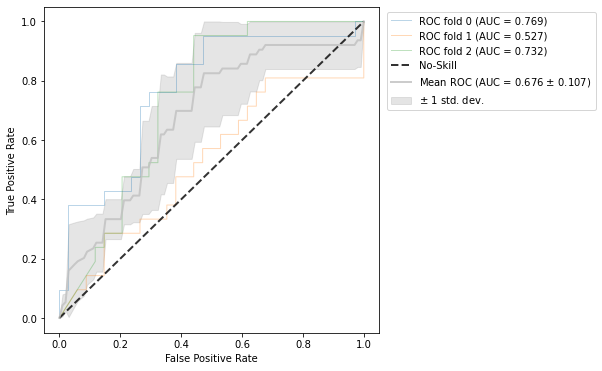

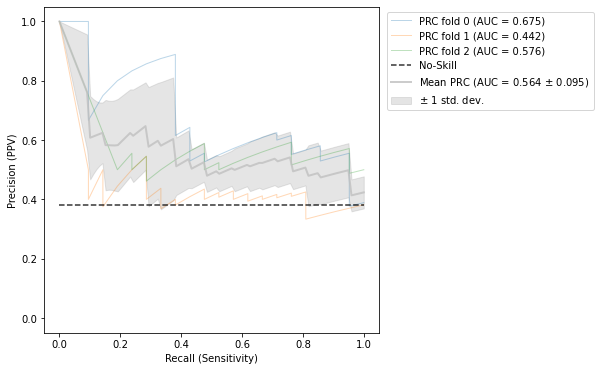

Logistic Regression


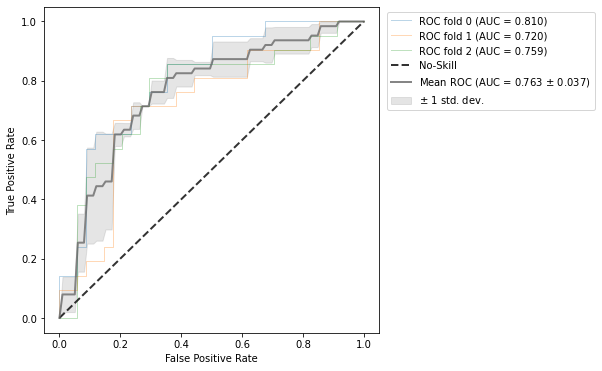

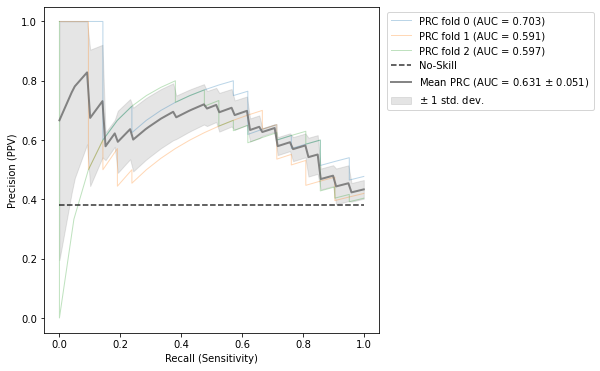

Decision Tree


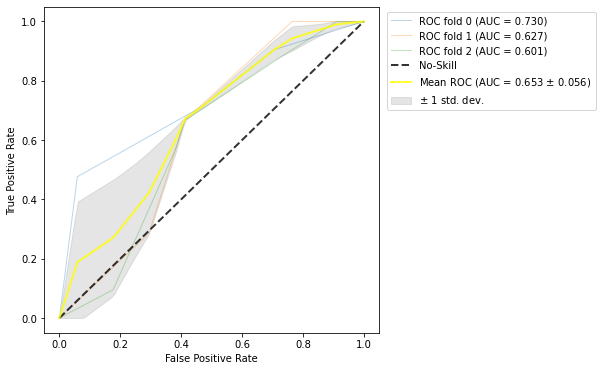

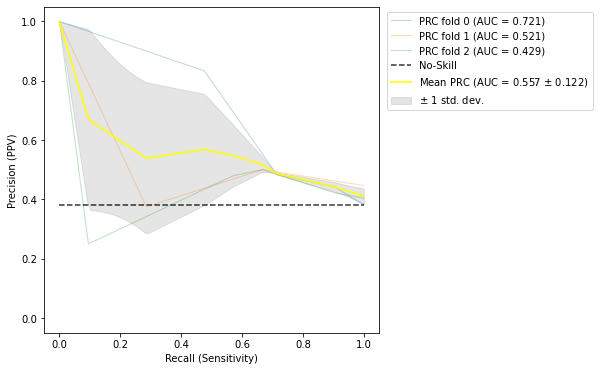

Generating ROC and PRC plots...


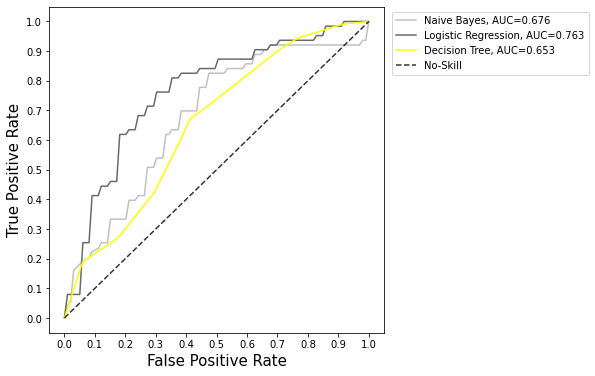

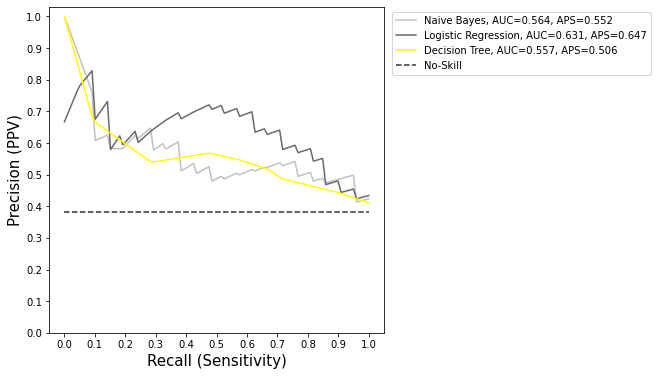

Saving Metric Summaries...
Generating Metric Boxplots...


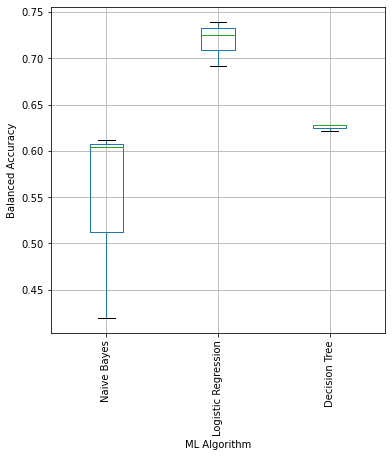

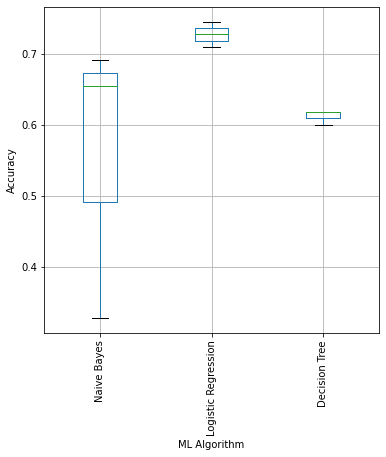

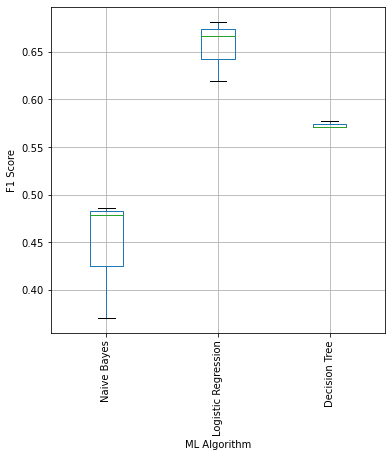

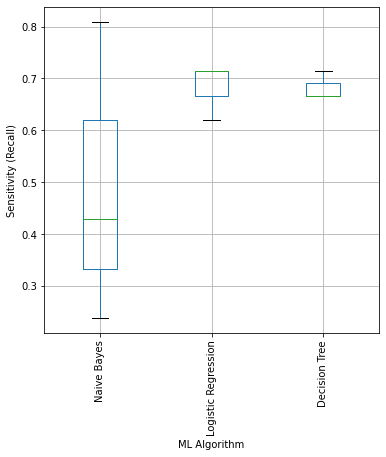

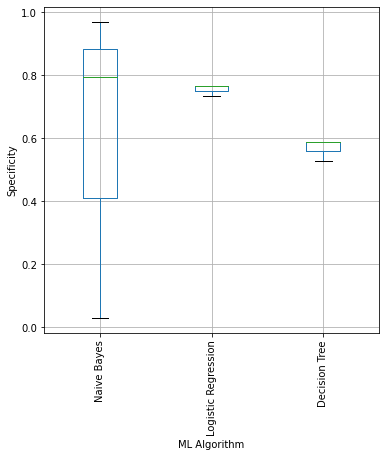

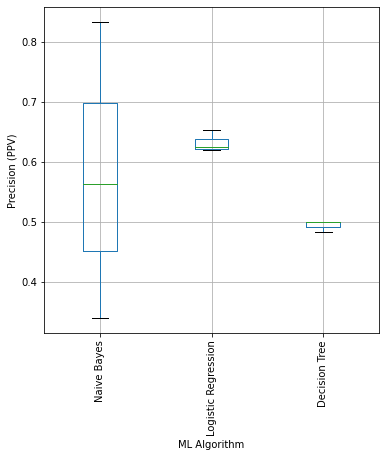

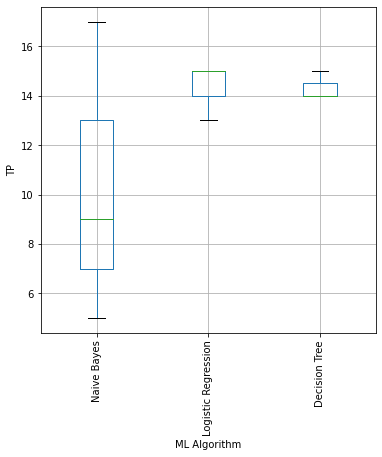

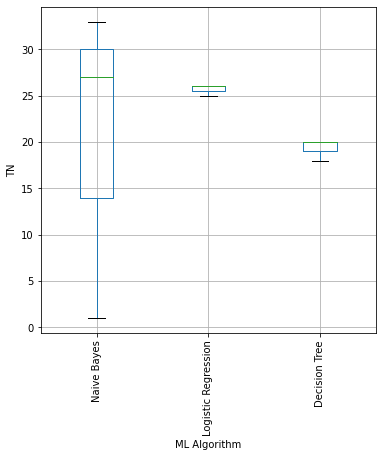

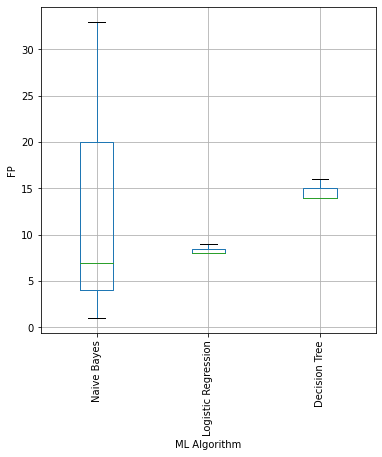

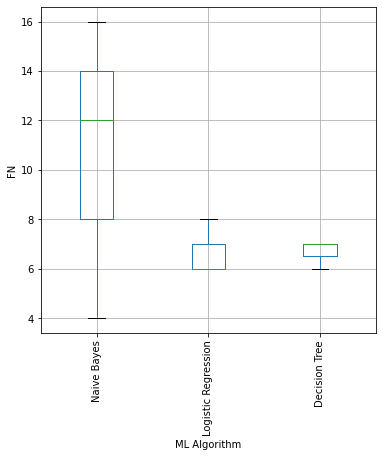

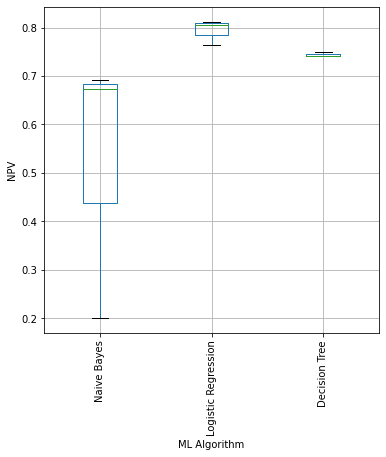

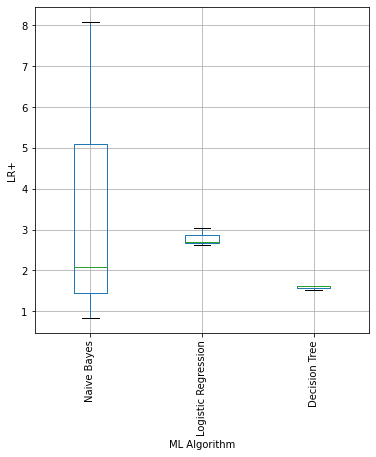

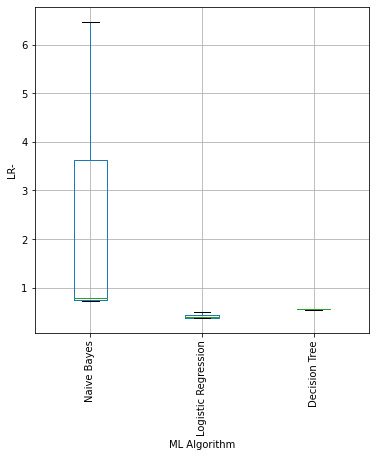

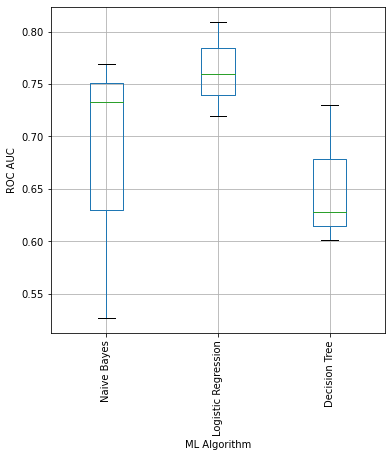

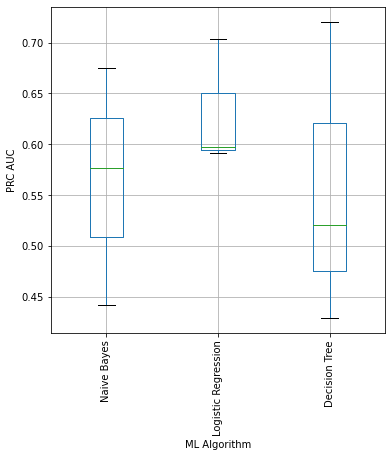

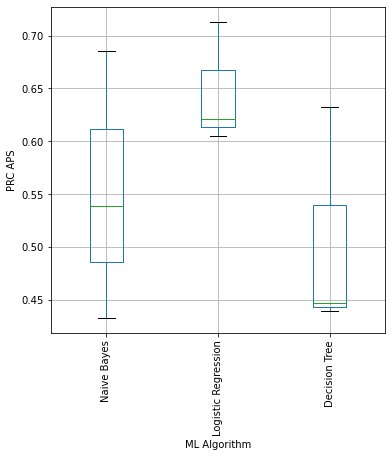

Running Non-Parametric Statistical Significance Analysis...
Preparing for Model Feature Importance Plotting...
Generating Feature Importance Boxplots and Histograms...


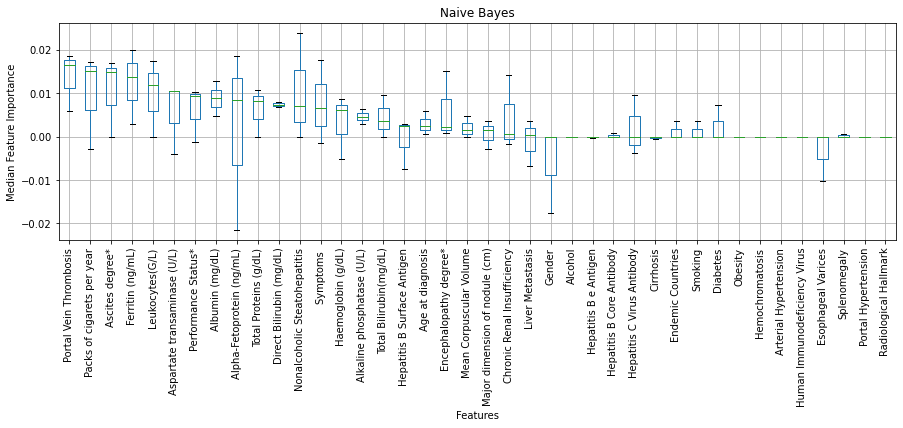

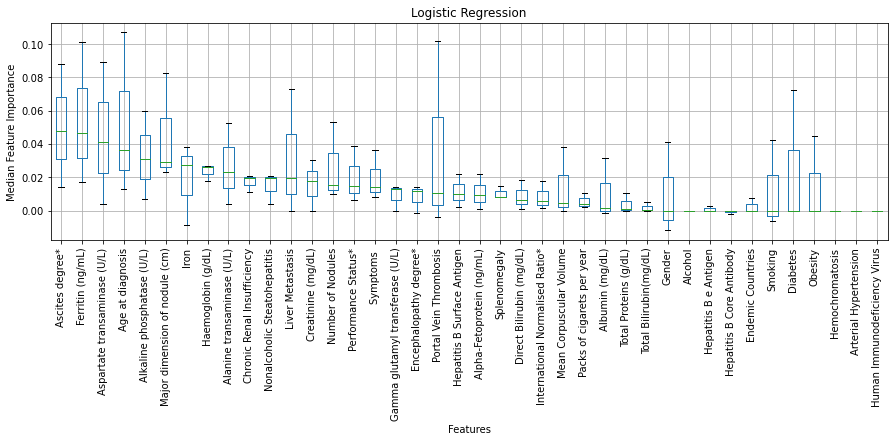

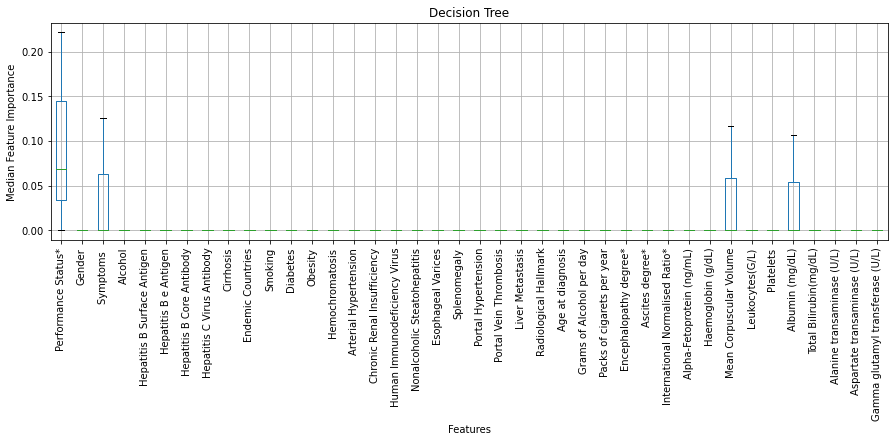

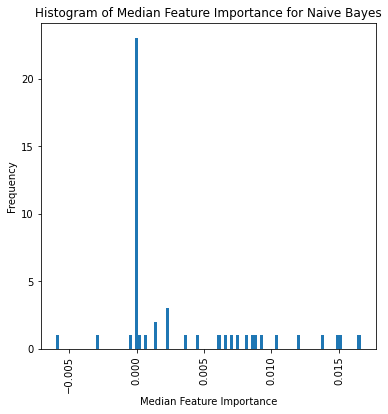

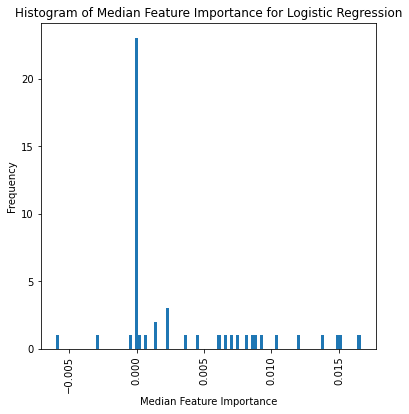

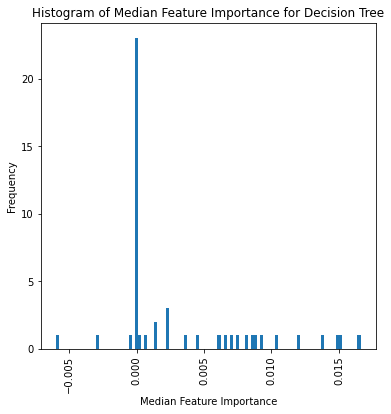

Generating Composite Feature Importance Plots...


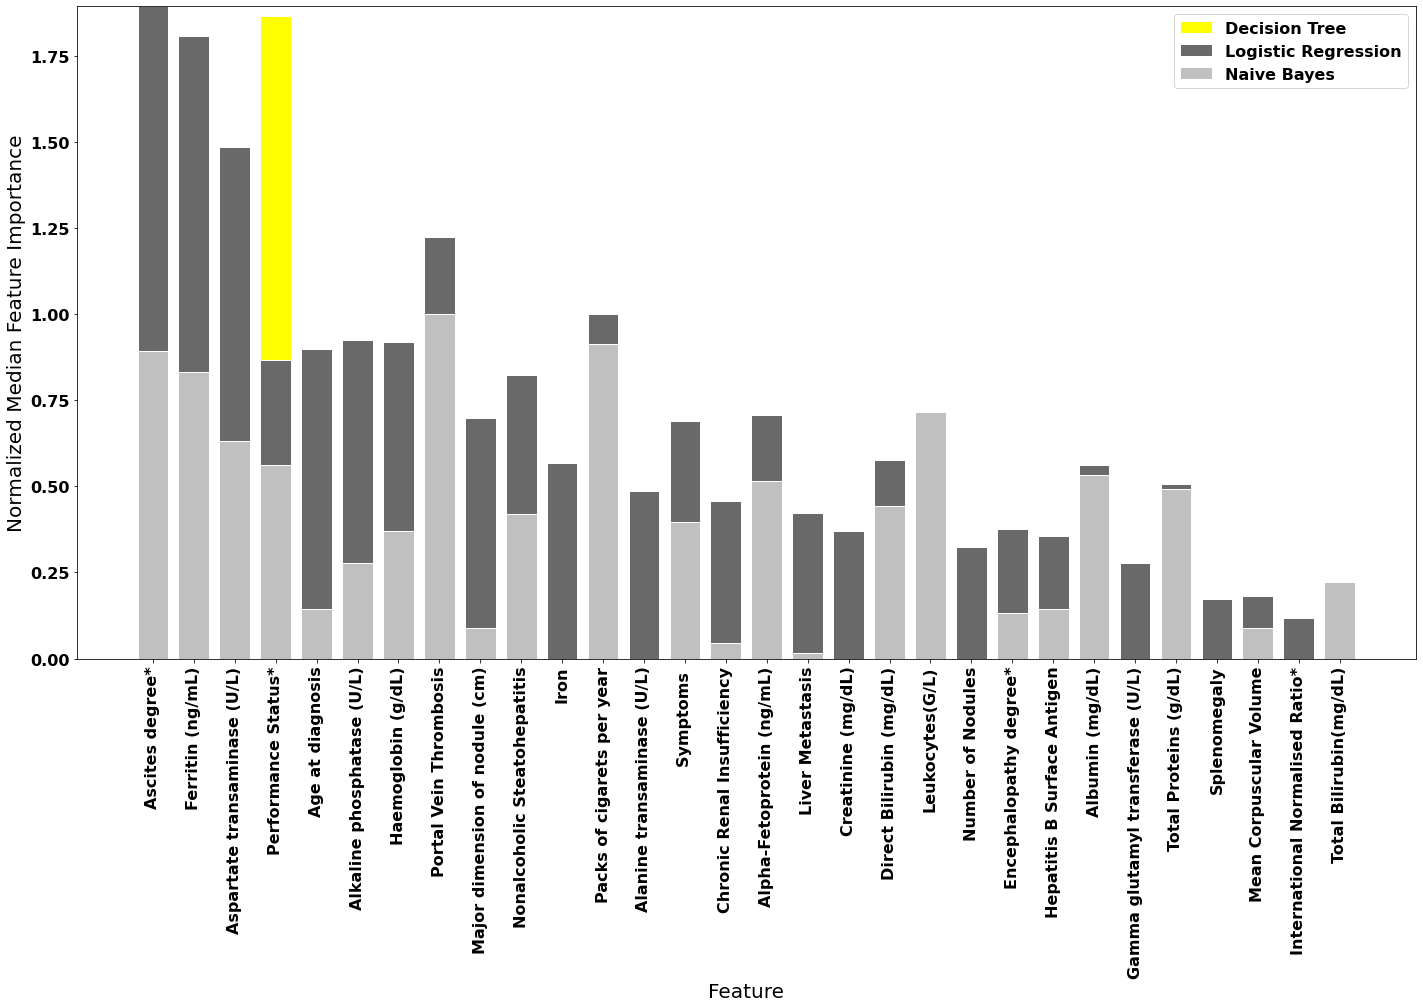

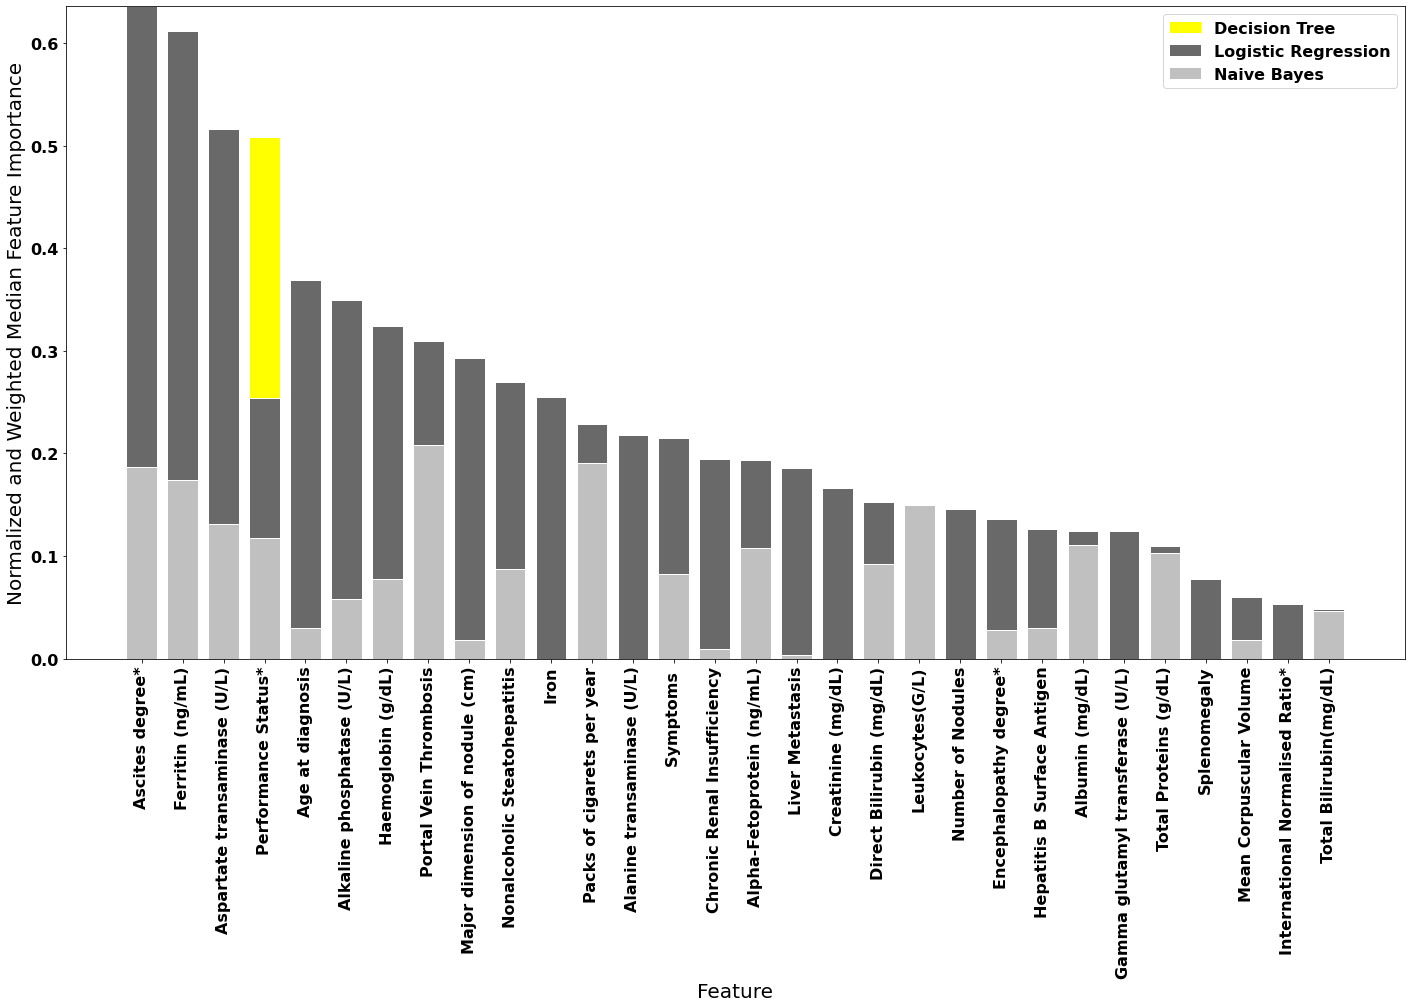

hcc-data_example phase 5 complete
Running Statistics Summary for hcc-data_example_no_covariates
Naive Bayes


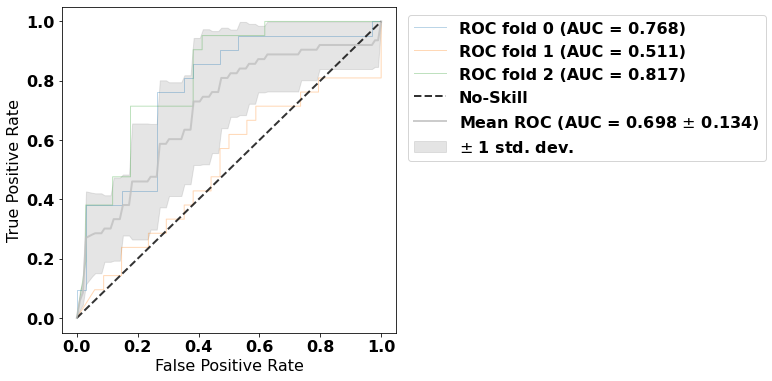

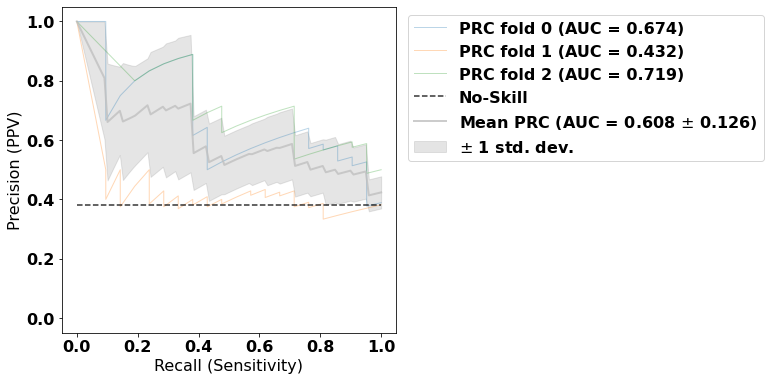

Logistic Regression


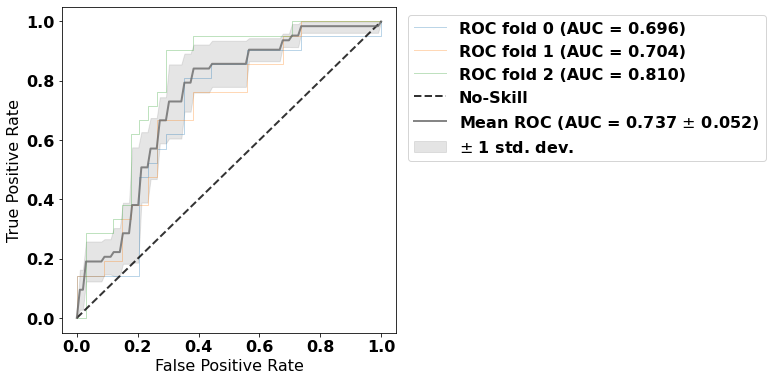

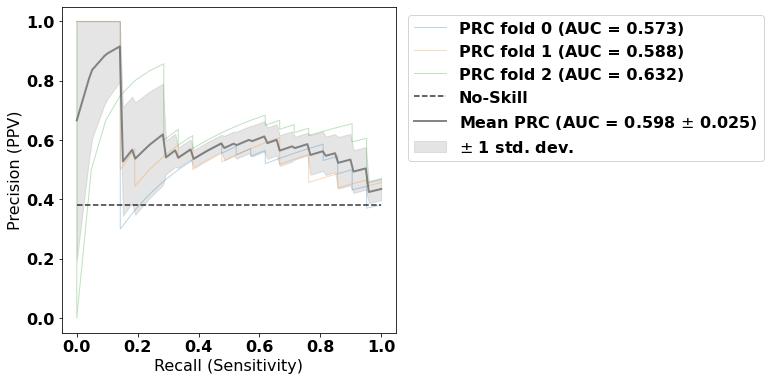

Decision Tree


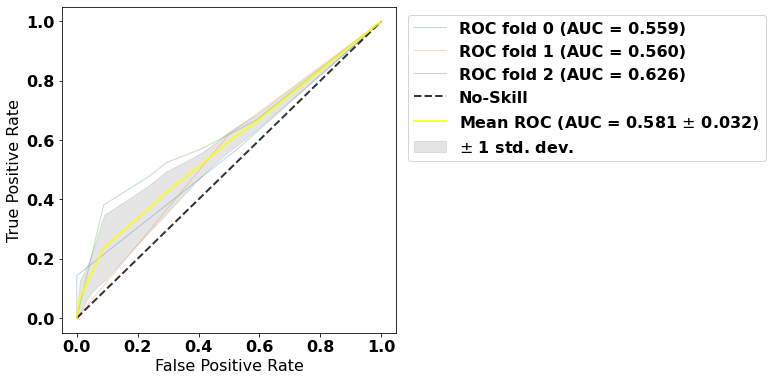

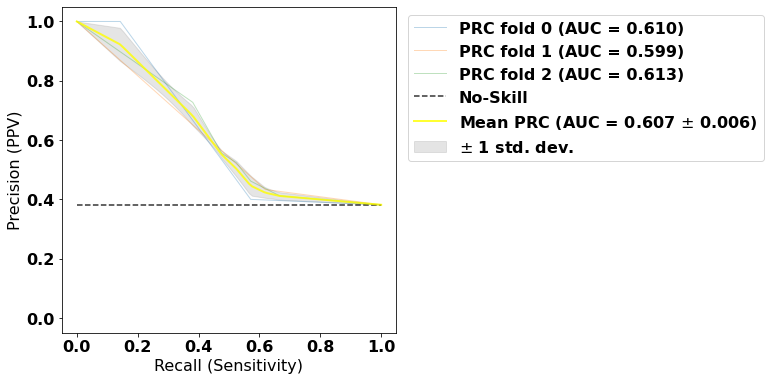

Generating ROC and PRC plots...


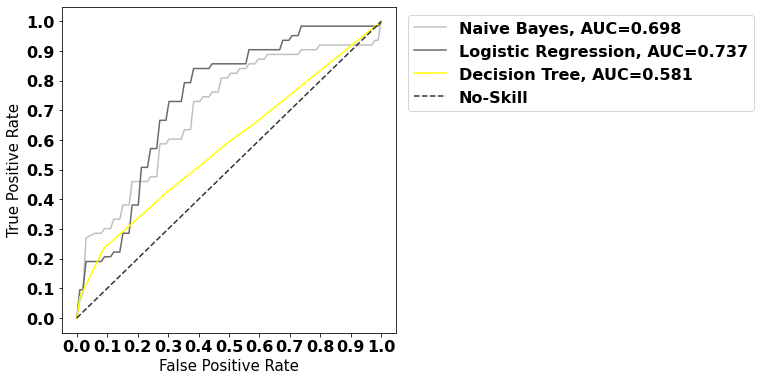

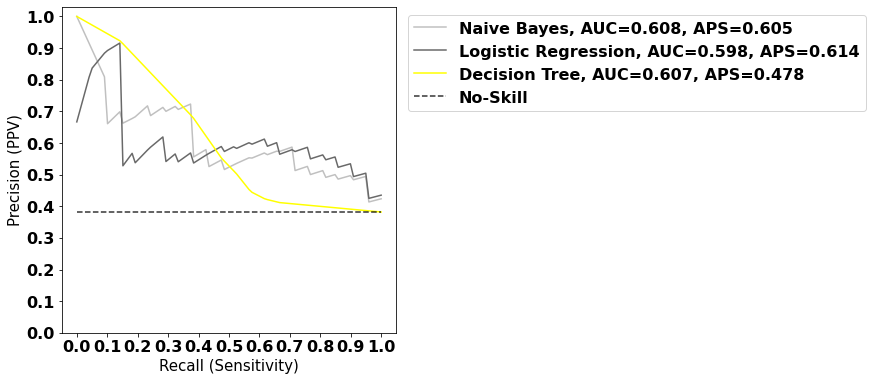

Saving Metric Summaries...
Generating Metric Boxplots...


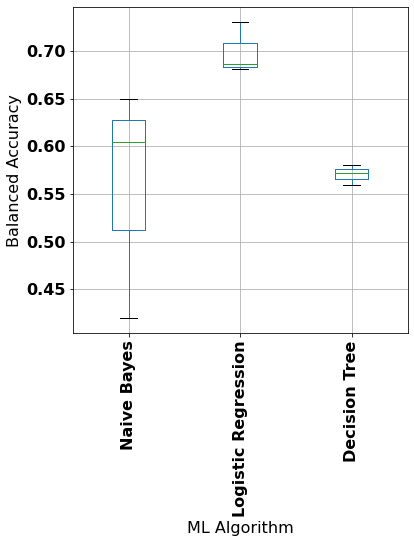

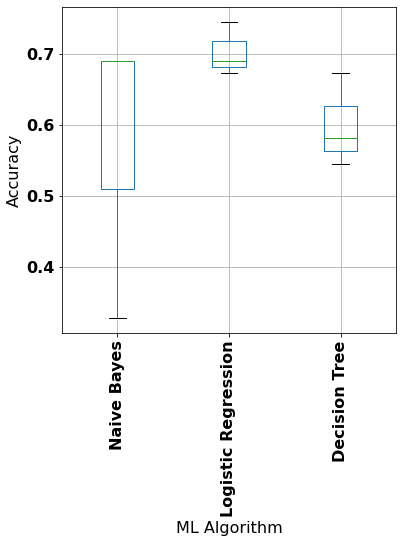

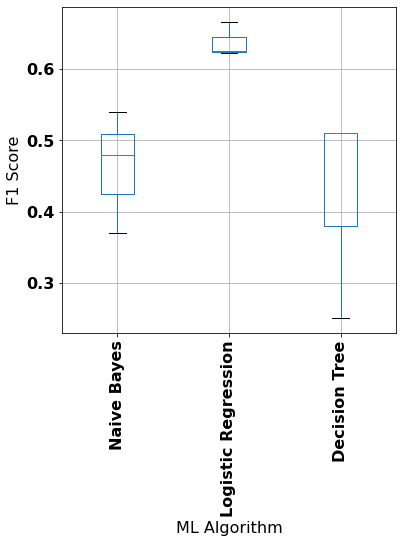

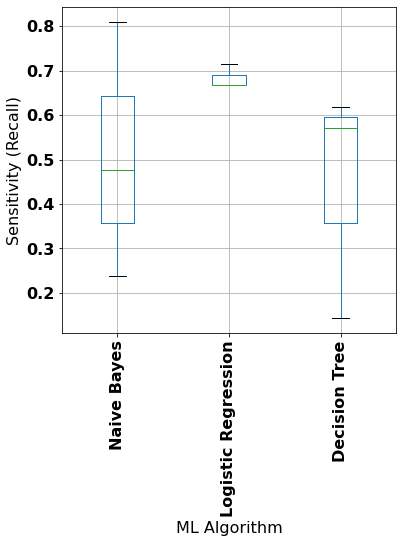

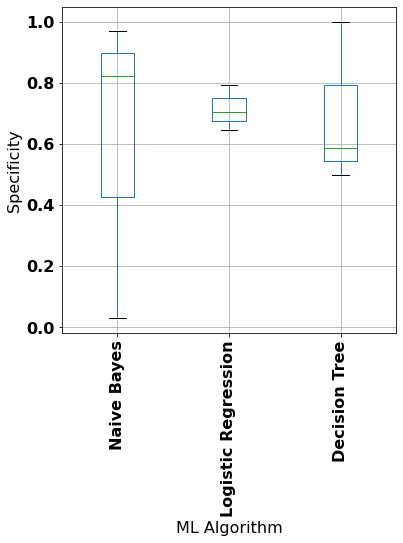

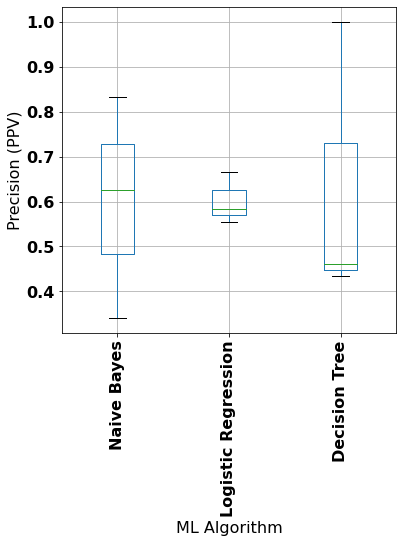

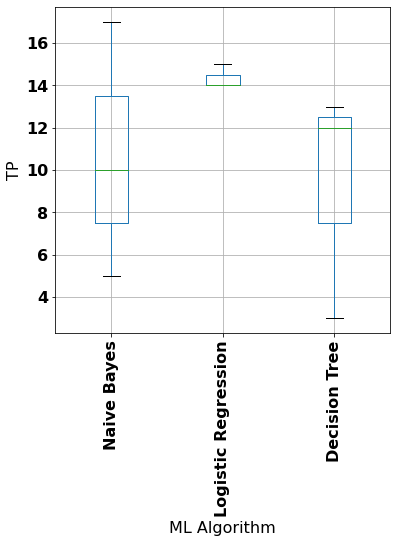

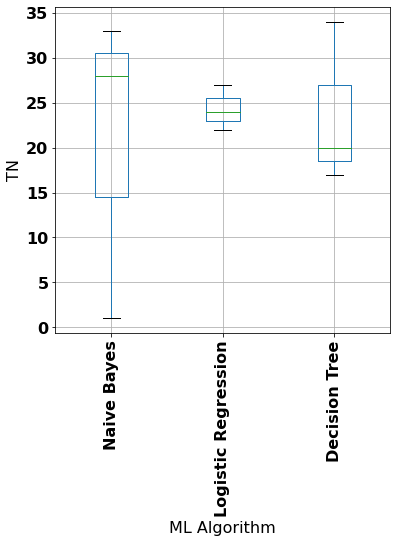

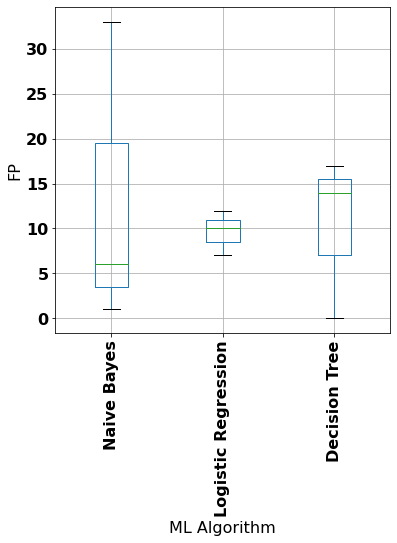

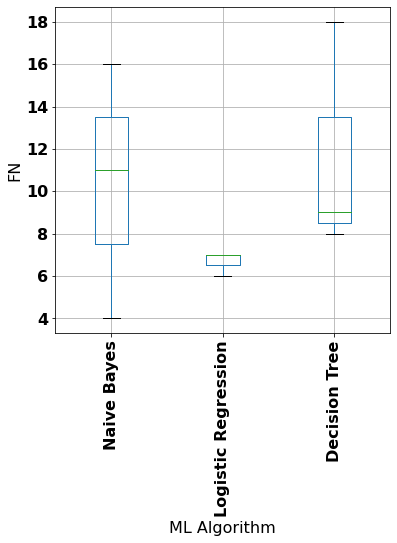

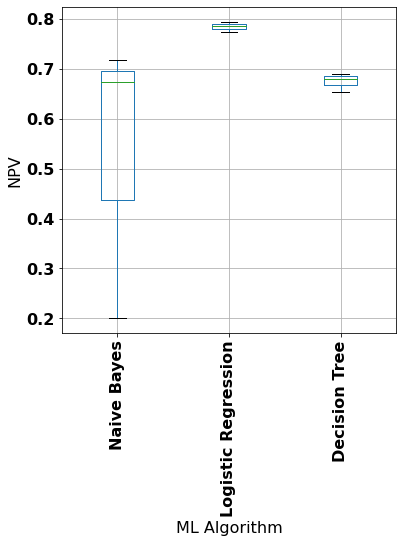

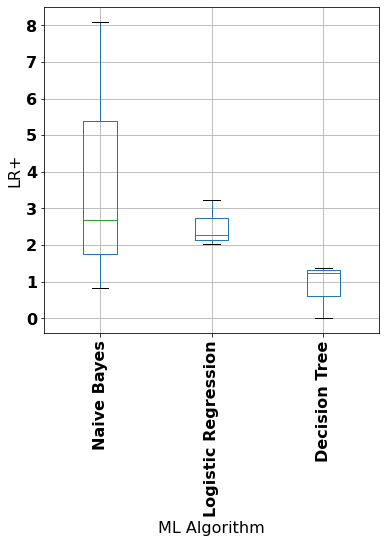

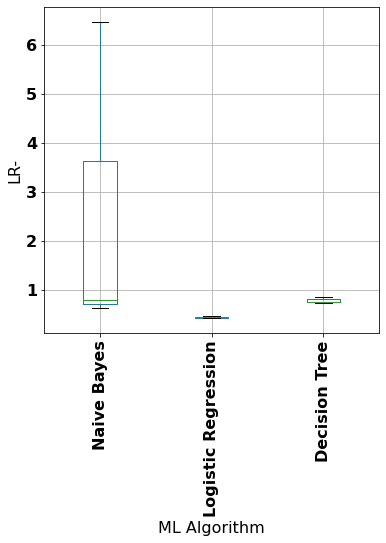

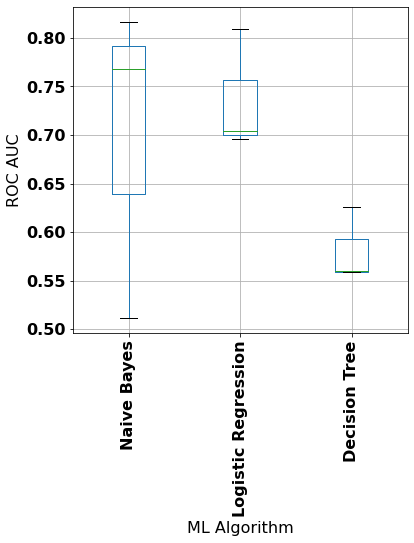

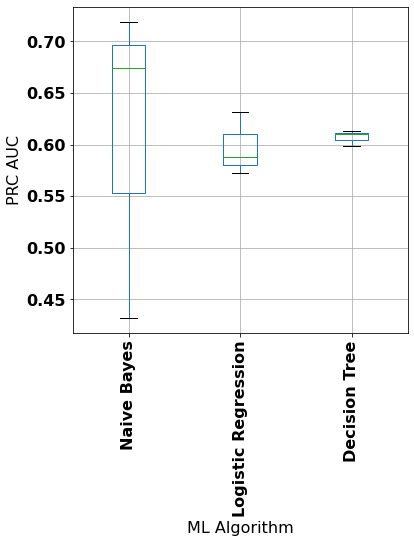

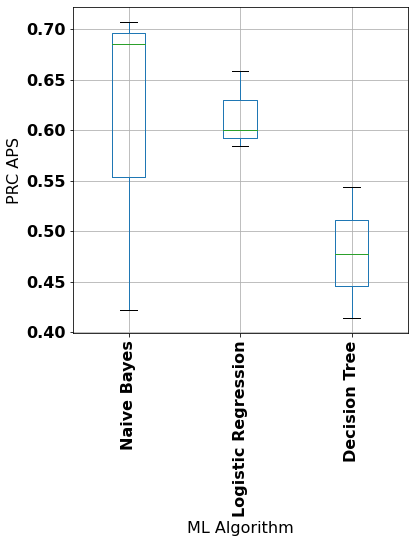

Running Non-Parametric Statistical Significance Analysis...
Preparing for Model Feature Importance Plotting...
Generating Feature Importance Boxplots and Histograms...


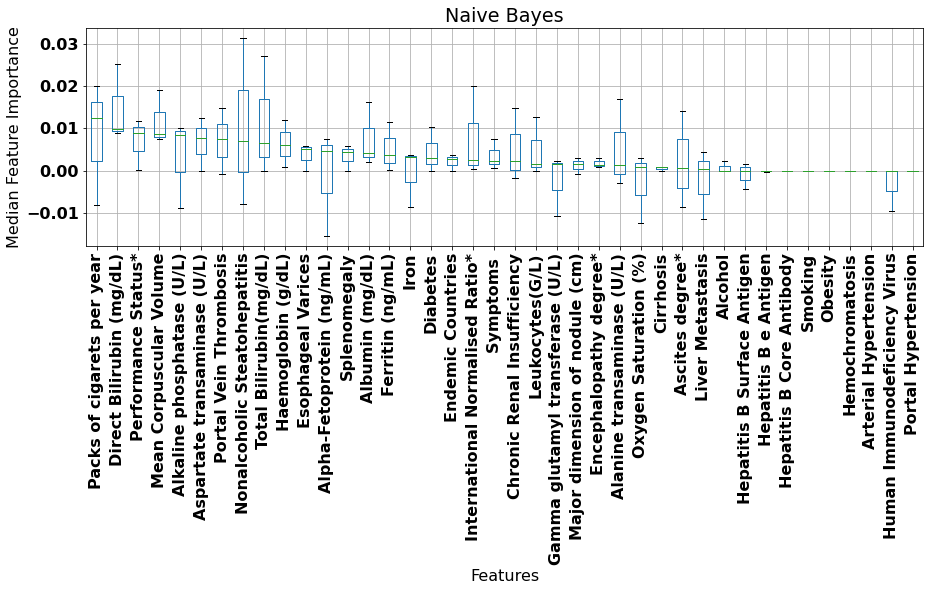

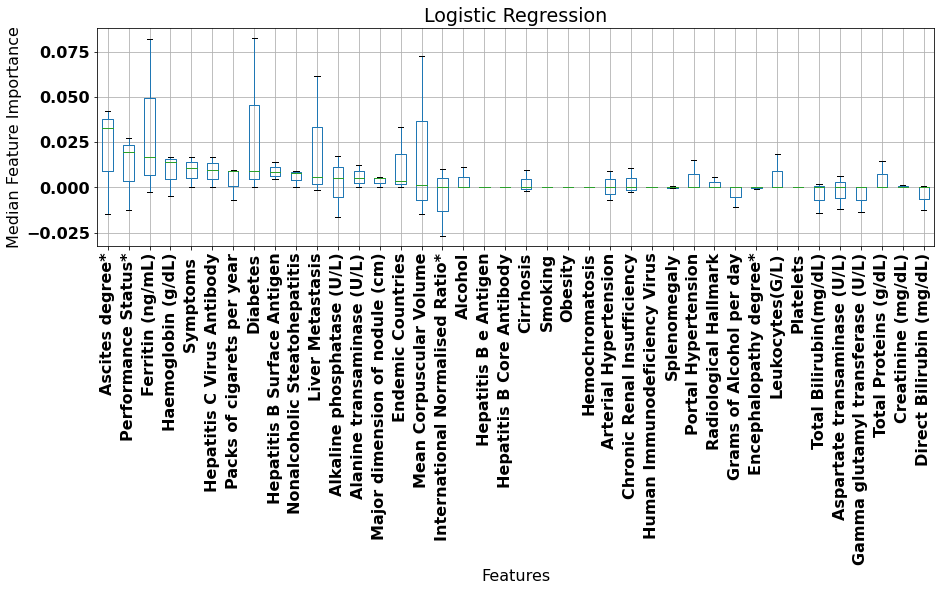

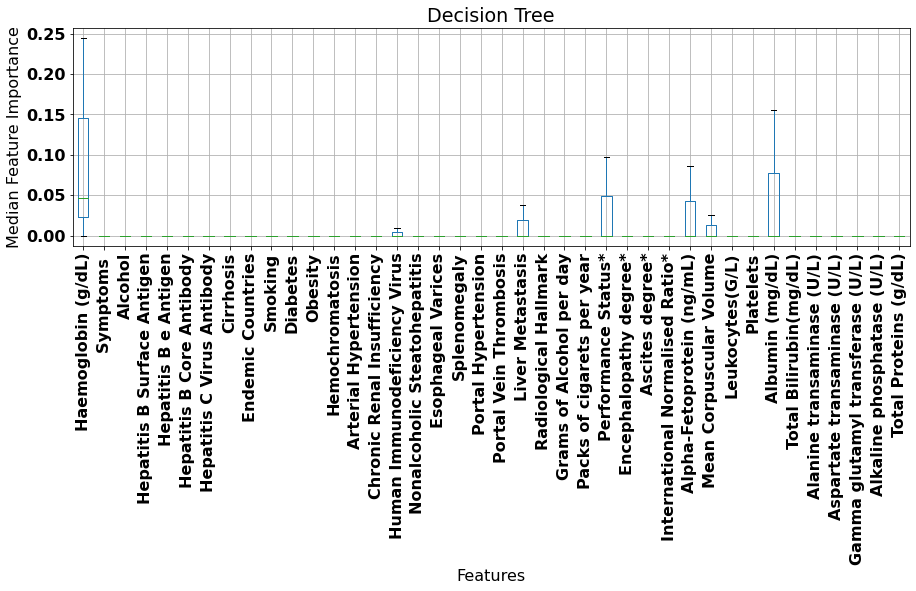

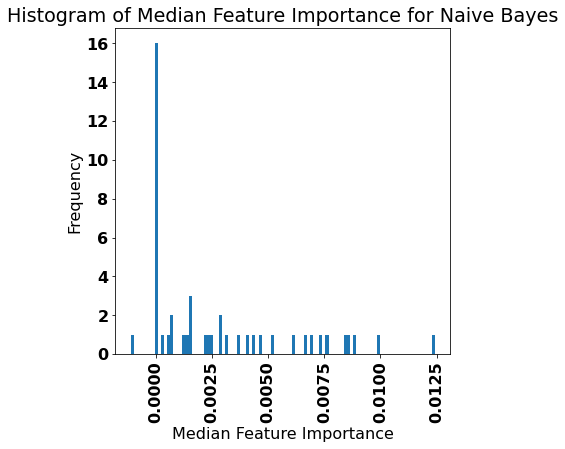

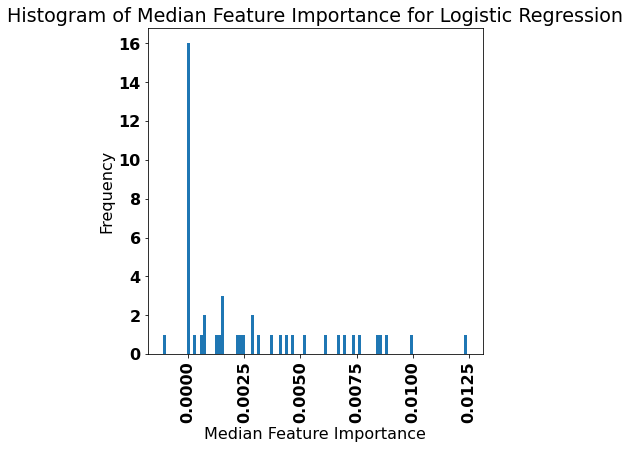

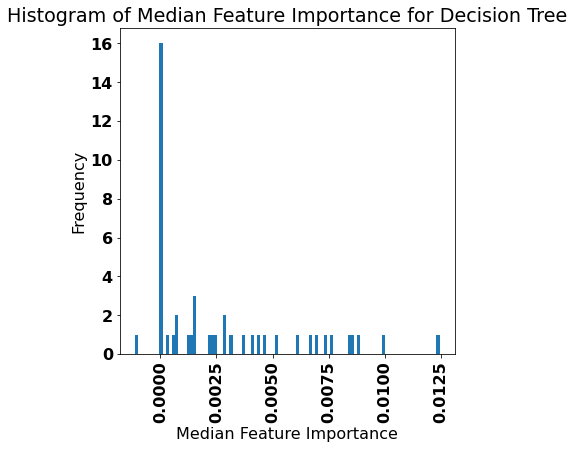

Generating Composite Feature Importance Plots...


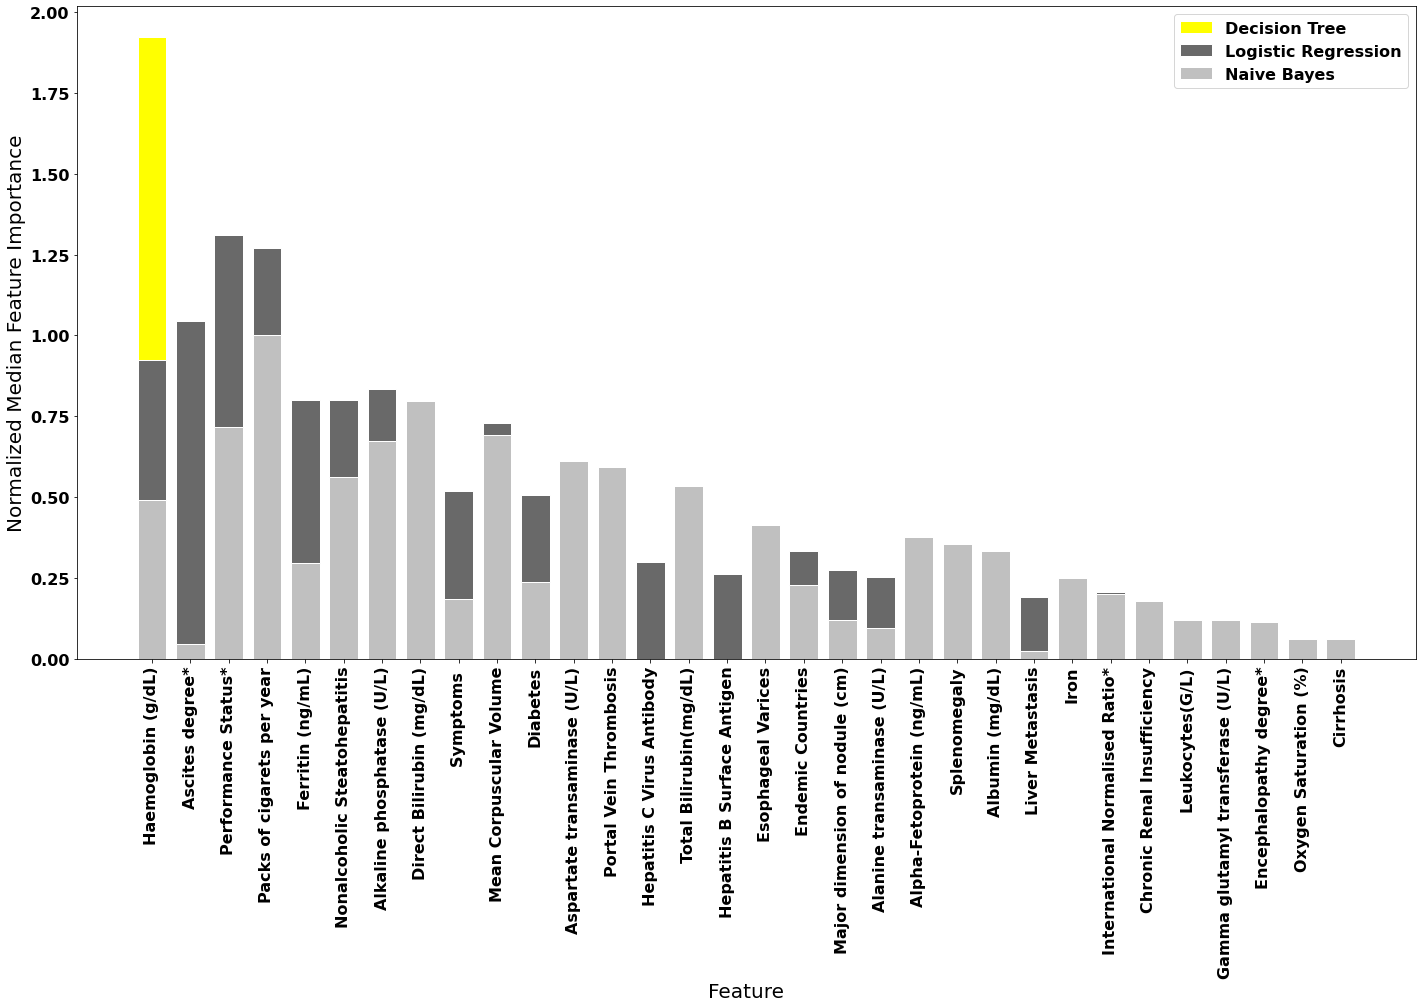

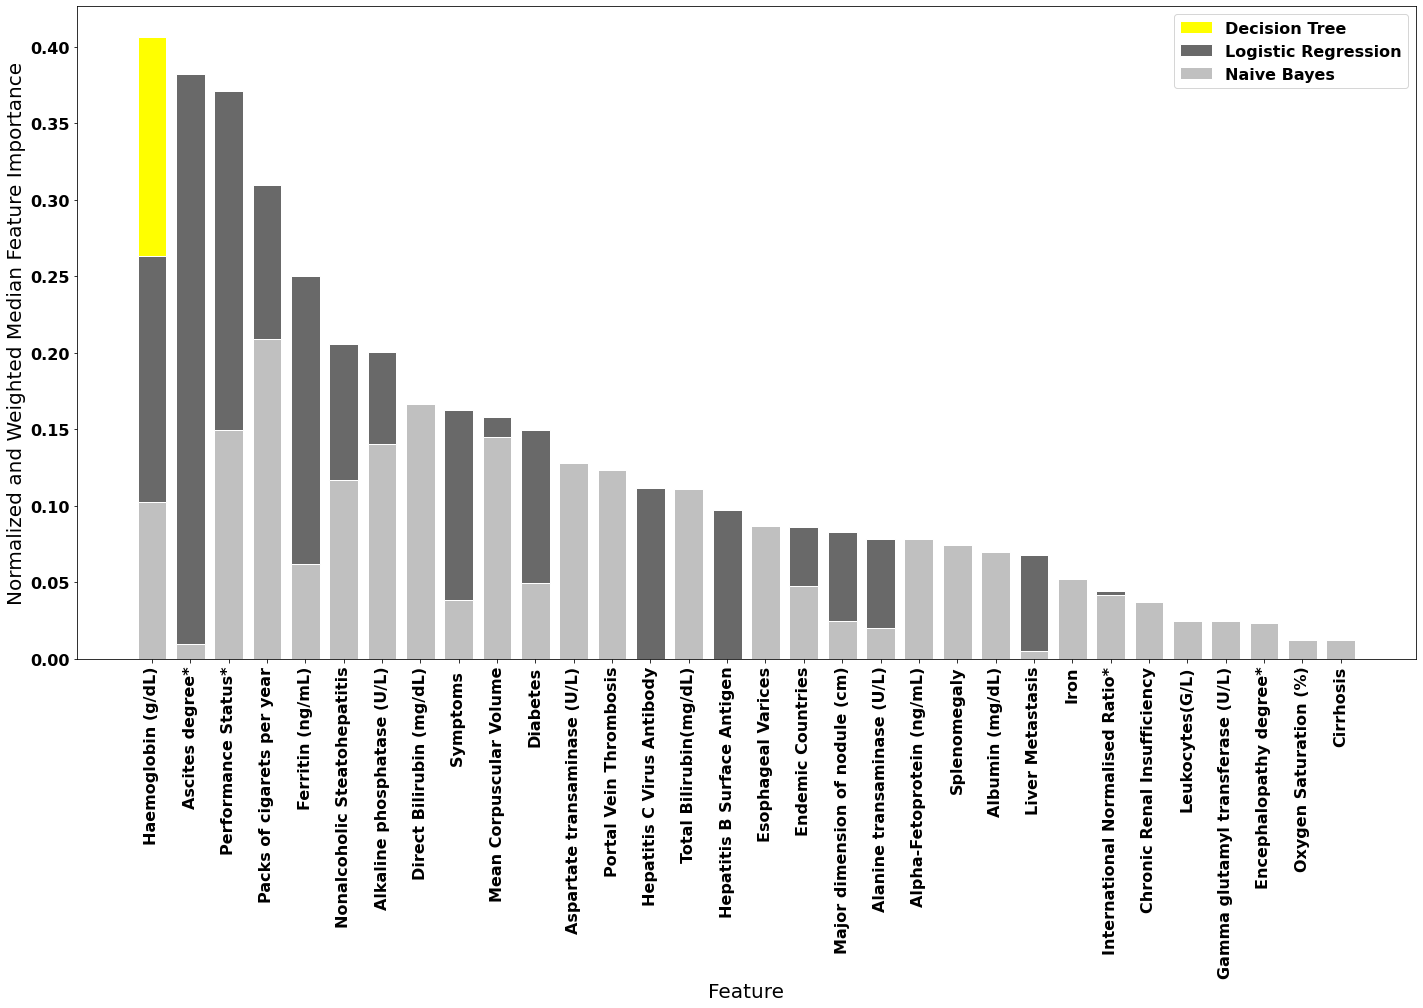

hcc-data_example_no_covariates phase 5 complete


In [27]:
#Unpickle metadata from previous phase
file = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()
metadata['Export ROC Plot'] = plot_ROC
metadata['Export PRC Plot'] = plot_PRC
metadata['Export Metric Boxplots'] = plot_metric_boxplots
metadata['Export Feature Importance Boxplots'] = plot_FI_box
metadata['Metric Weighting Composite FI Plots'] = metric_weight
metadata['Top Model Features To Display'] = top_model_features
#Pickle the metadata for future use
pickle_out = open(output_path+'/'+experiment_name+'/'+"metadata.pickle", 'wb')
pickle.dump(metadata,pickle_out)
pickle_out.close()

#Now that primary pipeline phases are complete generate a human readable version of metadata
df = pd.DataFrame.from_dict(metadata, orient ='index')
df.to_csv(output_path+'/'+experiment_name+'/'+'metadata.csv',index=True)

# Iterate through datasets
dataset_paths = os.listdir(output_path + "/" + experiment_name)
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in dataset_paths:
        dataset_paths.remove(text)
for dataset_directory_path in dataset_paths:
    full_path = output_path + "/" + experiment_name + "/" + dataset_directory_path
    StatsJob.job(full_path,plot_ROC,plot_PRC,plot_FI_box,class_label,instance_label,cv_partitions,scale_data,plot_metric_boxplots,primary_metric,top_model_features,sig_cutoff,metric_weight,jupyterRun)

## -----------------------------------------------------------------------------------------------------------------
## Phase 7: Dataset Comparison (Optional: Use only if > 1 dataset was analyzed)

### Import Additional Python Packages

In [28]:
import DataCompareJob

### Run Dataset Comparison

Running Statistical Significance Comparisons Between Multiple Datasets...
Generate Boxplots Comparing Dataset Performance...


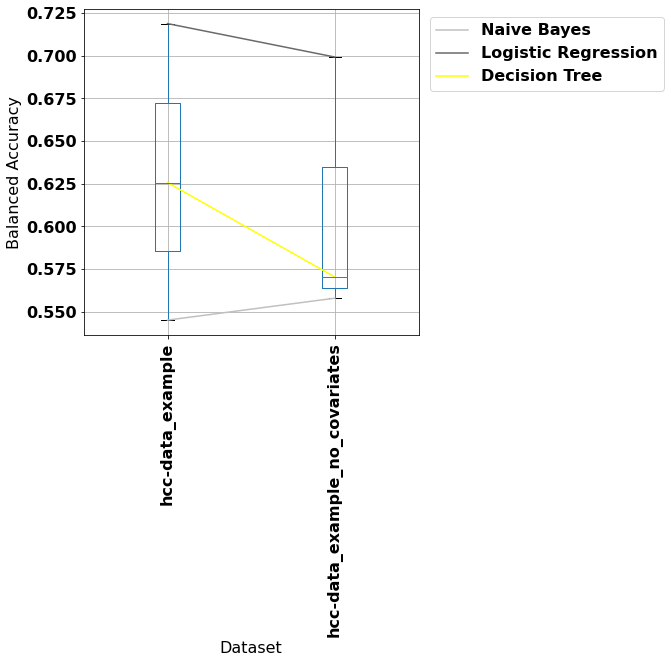

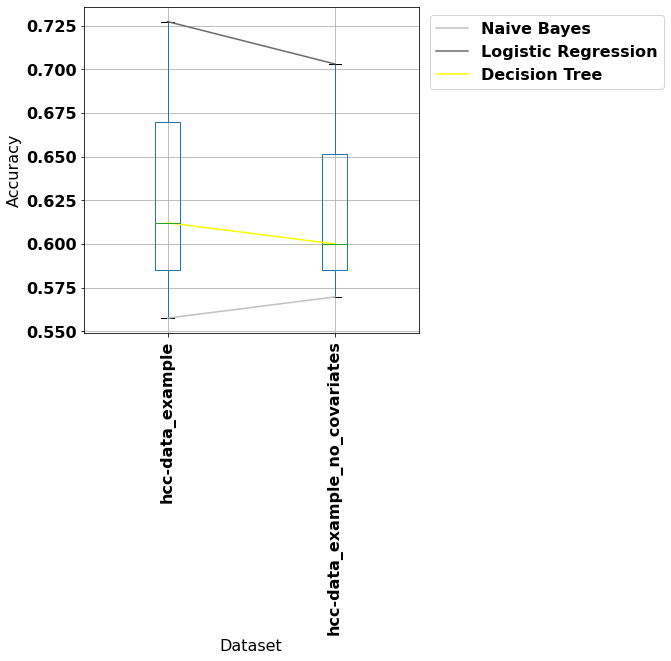

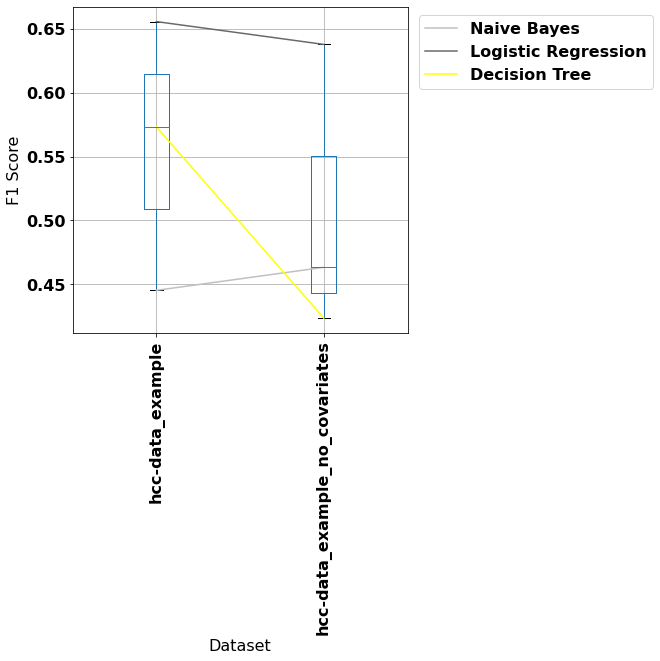

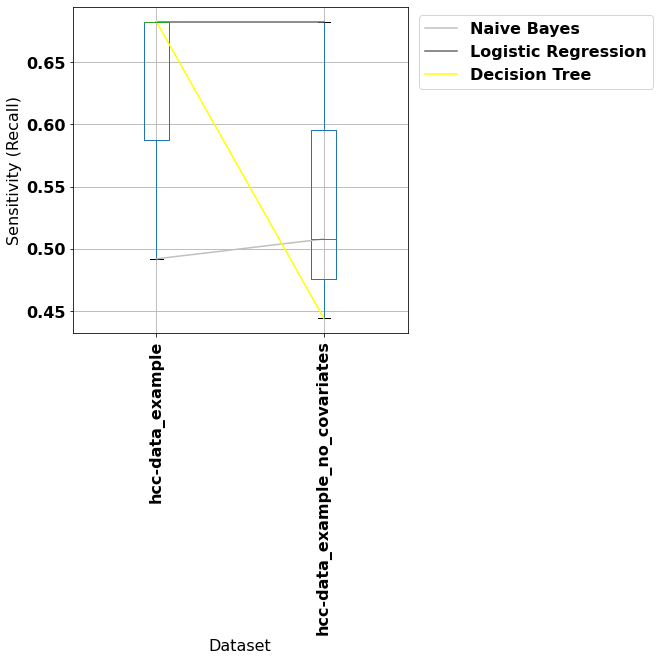

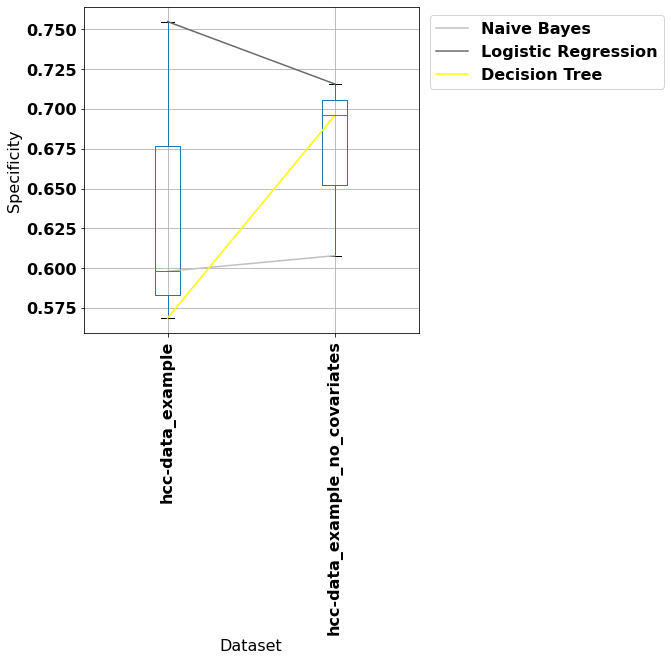

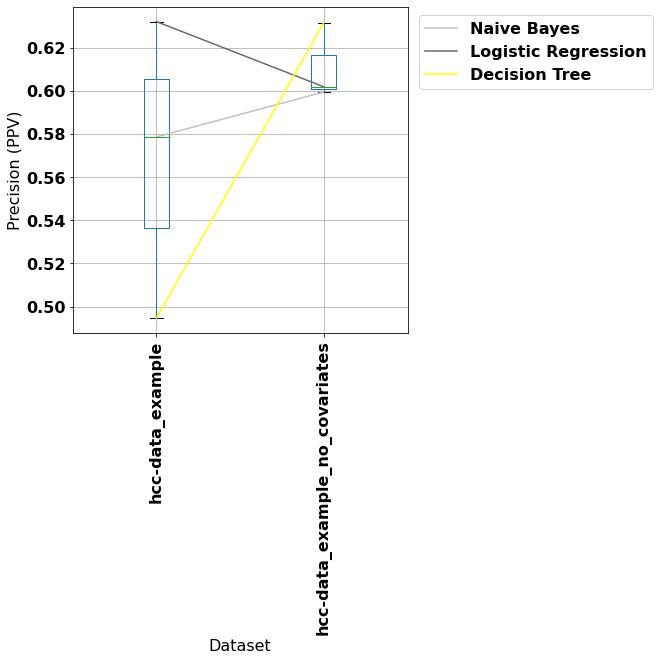

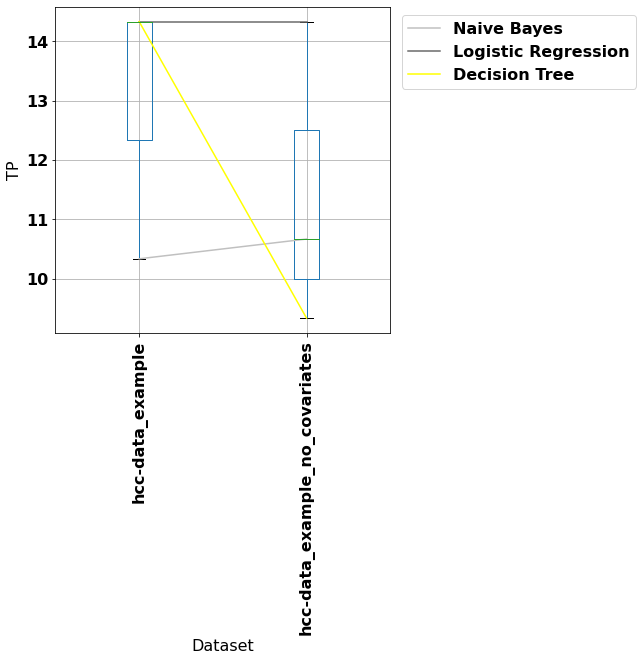

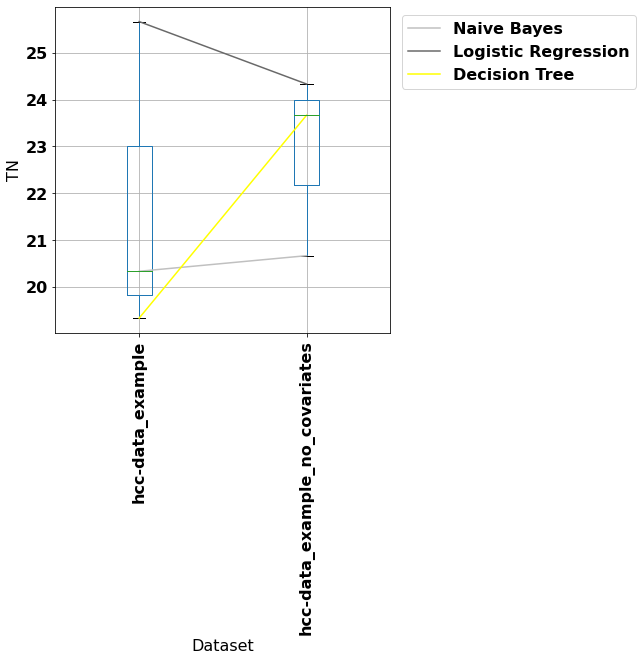

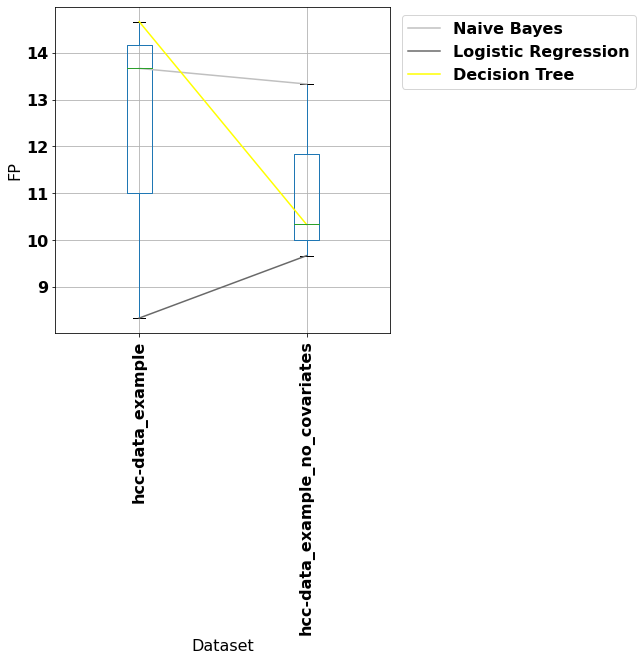

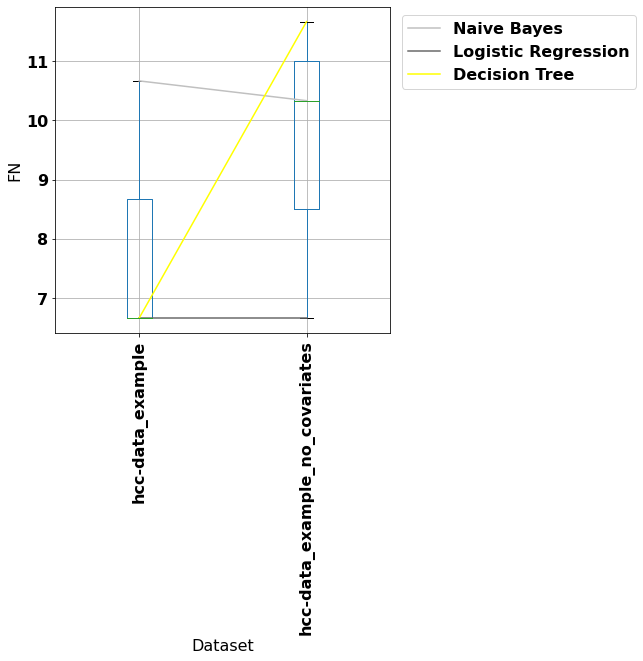

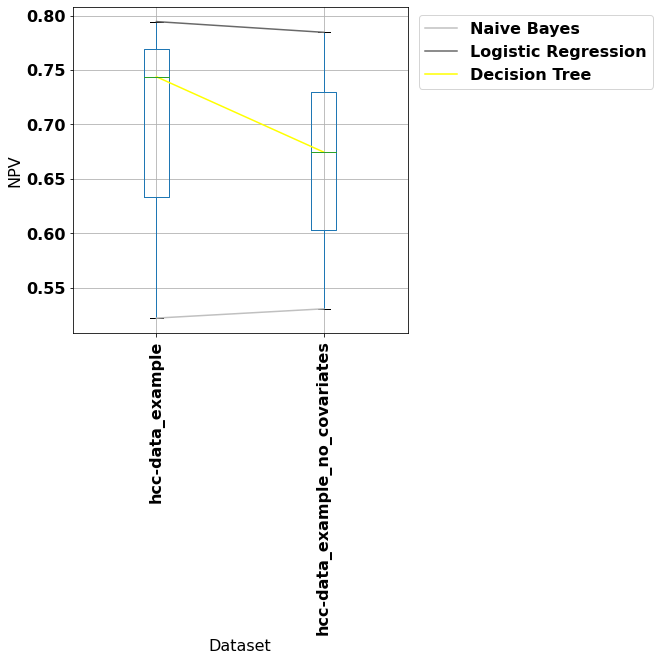

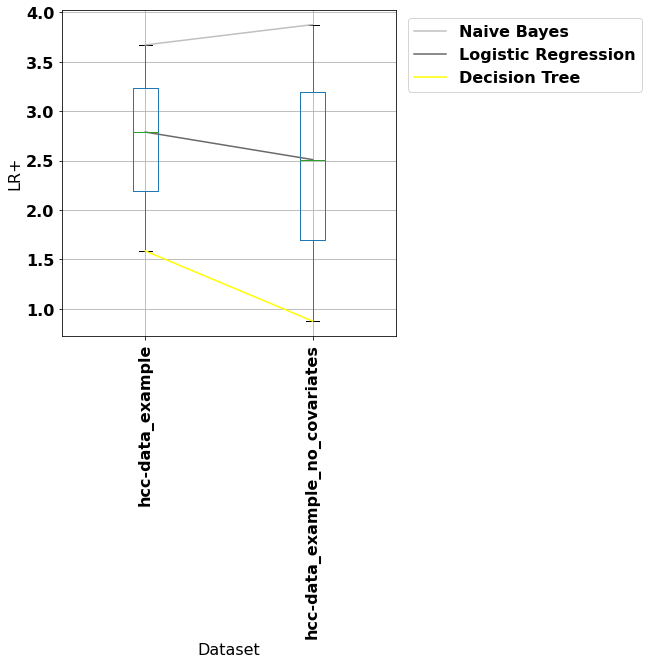

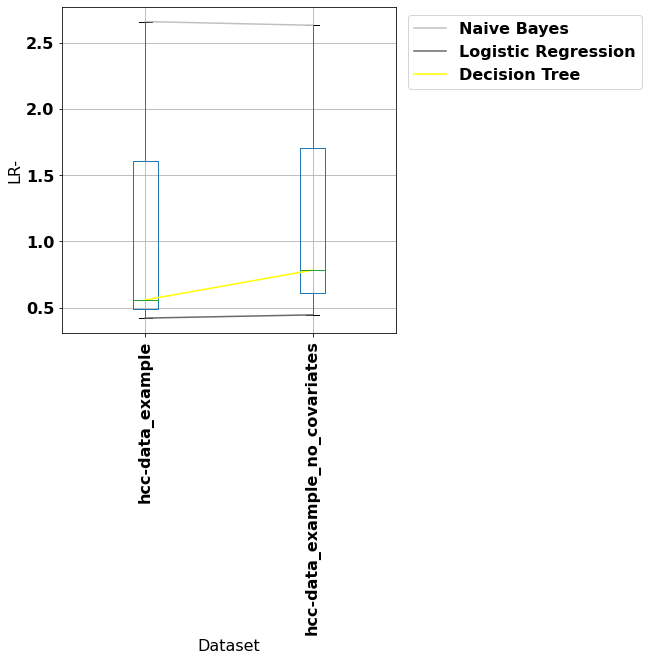

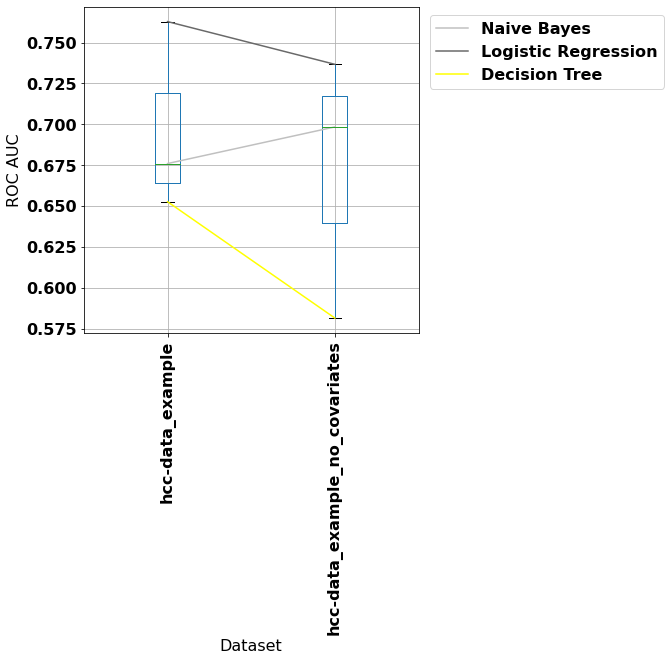

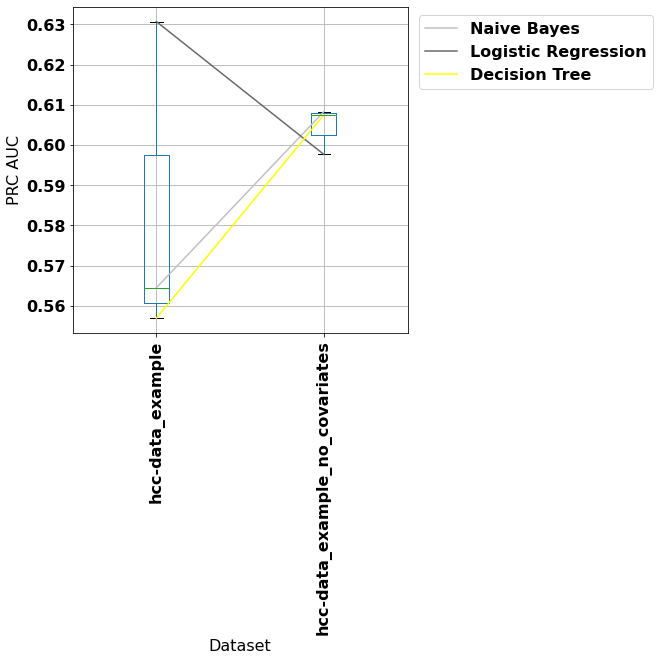

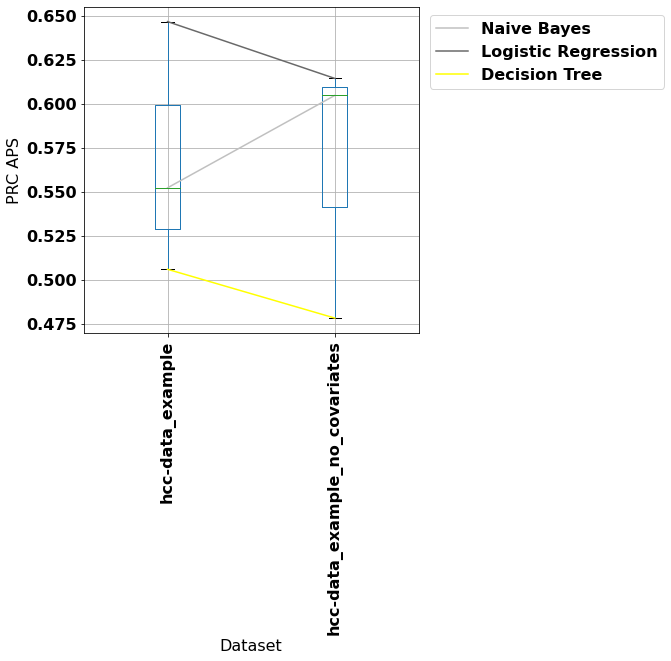

Naive Bayes


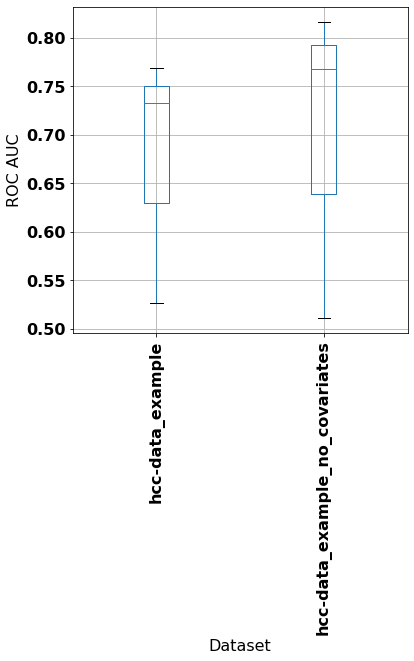

Naive Bayes


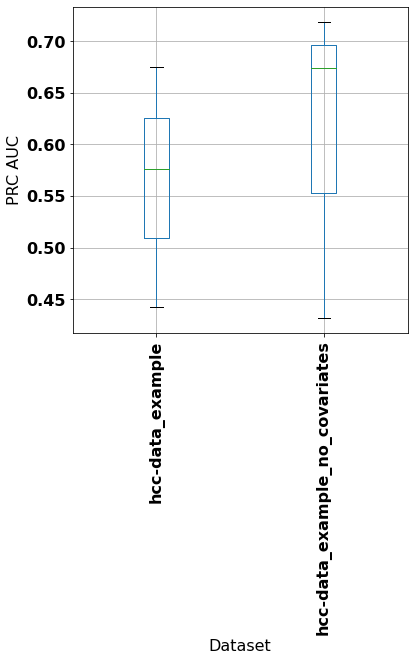

Logistic Regression


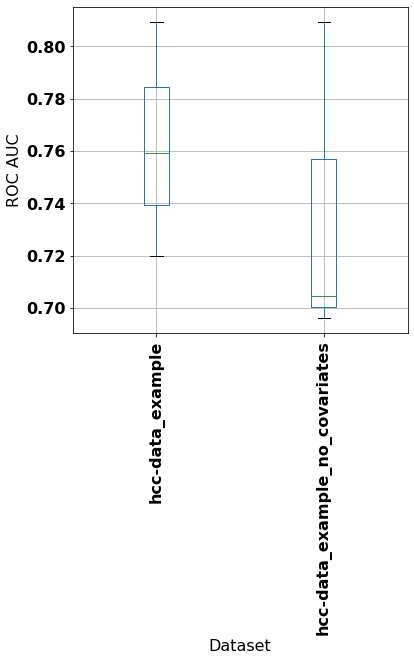

Logistic Regression


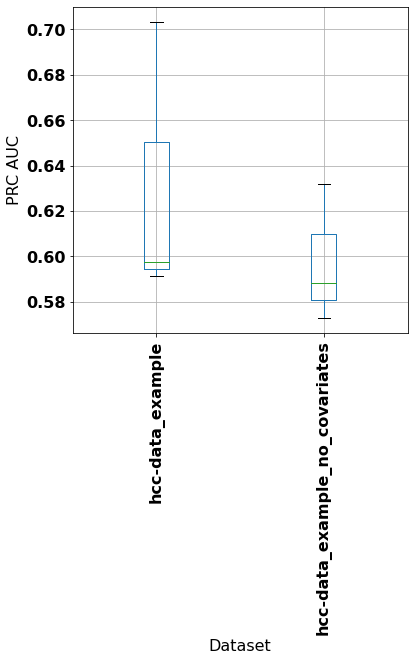

Decision Tree


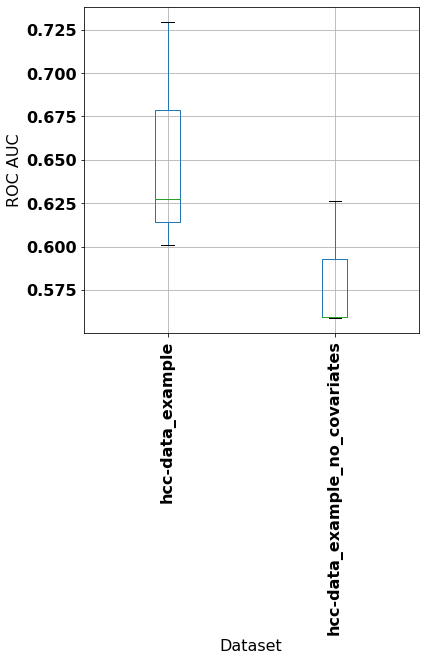

Decision Tree


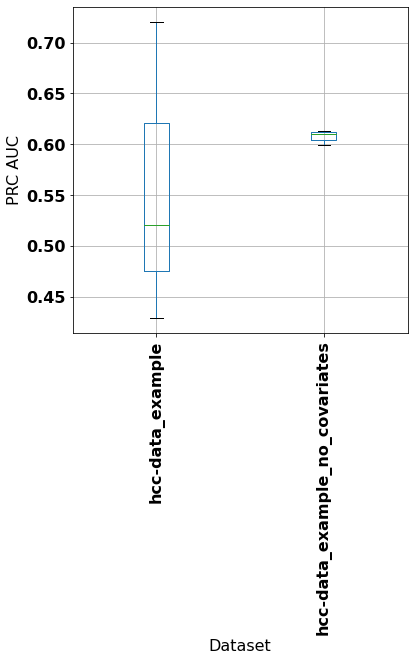

Phase 7 complete


In [29]:
if len(dataset_paths) > 1:
    DataCompareJob.job(output_path+'/'+experiment_name,sig_cutoff,jupyterRun)

## -----------------------------------------------------------------------------------------------------------------
## Phase 8: PDF Training Report Generator (Optional)

In [30]:
import PDF_ReportJob

In [31]:
experiment_path = output_path+'/'+experiment_name
PDF_ReportJob.job(experiment_path,'True','None','None')

2022-06-14 18:00:44.176468
Starting Report
Publishing Univariate Analysis
Publishing Model Prediction Summary
Publishing Average Model Prediction Statistics
Publishing Median Model Prediction Statistics
Publishing Feature Importance Summaries
Publishing Dataset Comparison Boxplots
Publishing Statistical Analysis
Publishing Runtime Summary
Phase 8 complete


## -----------------------------------------------------------------------------------------------------------------
## Phase 9: Apply Models to Replication Data (Optional)

### Import Additional Python Packages

In [32]:
import ApplyModelJob

### Specify Run Parameters

In [33]:
if demo_run:
    rep_data_path = wd_path+'/DemoRepData'
    dataset_for_rep = wd_path+'/DemoData/hcc-data_example.csv'
print("Replication Data Folder Path: "+rep_data_path)
print("Dataset Path: "+dataset_for_rep)

Replication Data Folder Path: C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoRepData
Dataset Path: C:/Users/ryanu/OneDrive/Documents/GitHub/STREAMLINE/DemoData/hcc-data_example.csv


### Run Application of Models to Replication Data

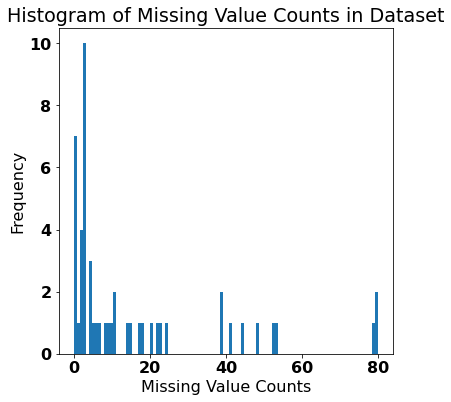

Data Counts: ----------------
Instance Count = 165
Feature Count = 49
    Categorical  = 27
    Quantitative = 22
Missing Count = 826
    Missing Percent = 0.10216450216450217
Class Counts: ----------------
0    102
1     63
Name: Class, dtype: int64


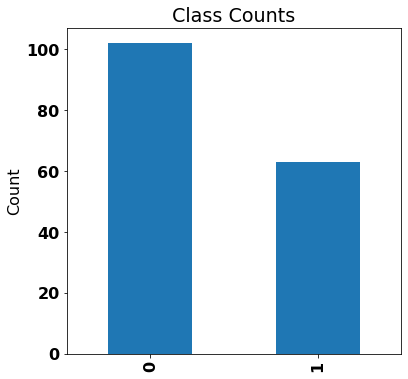

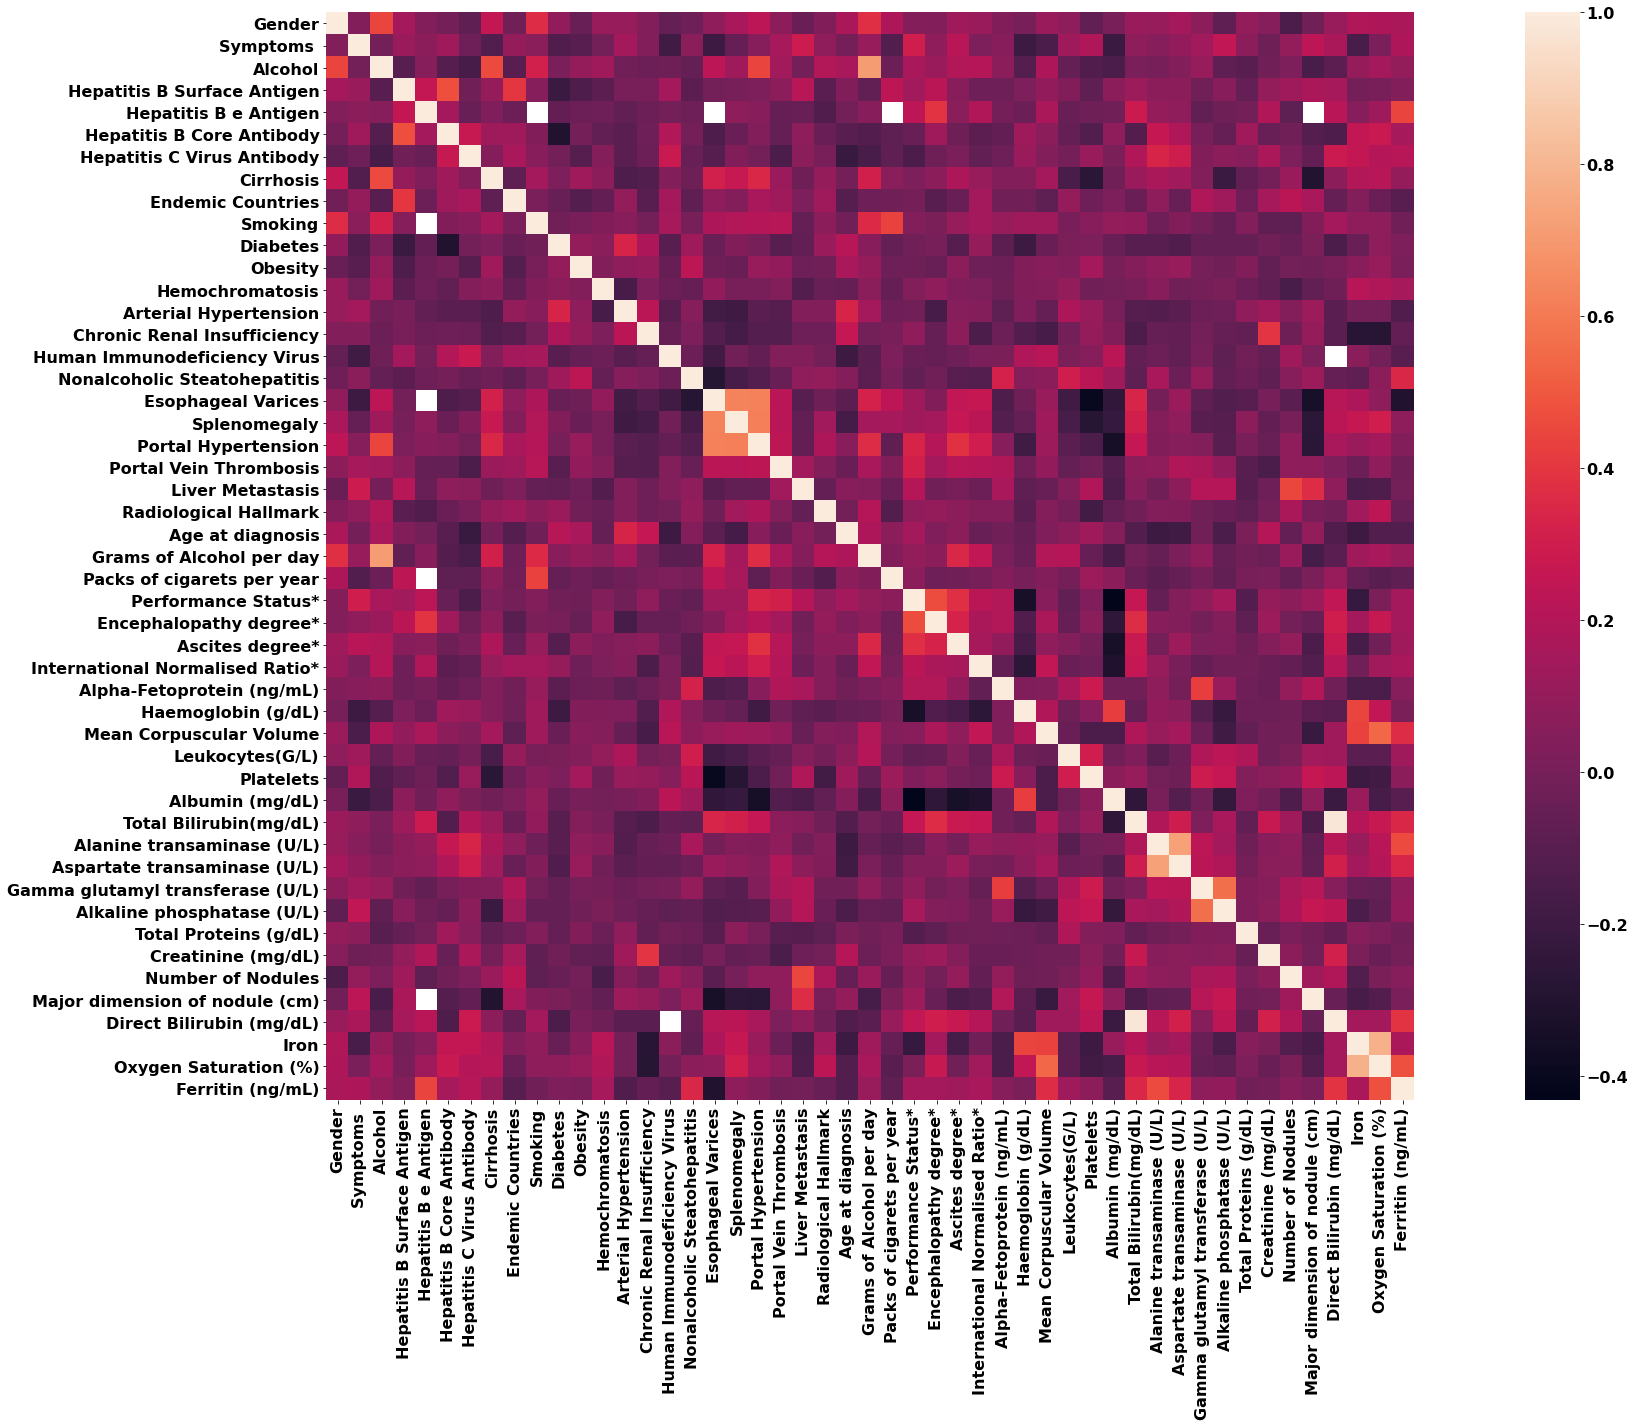

Naive Bayes


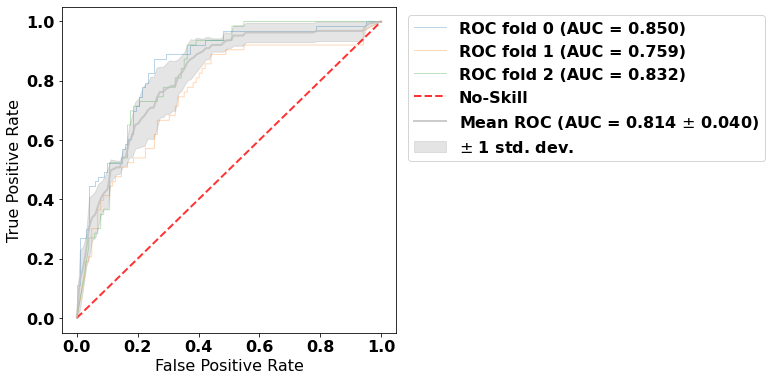

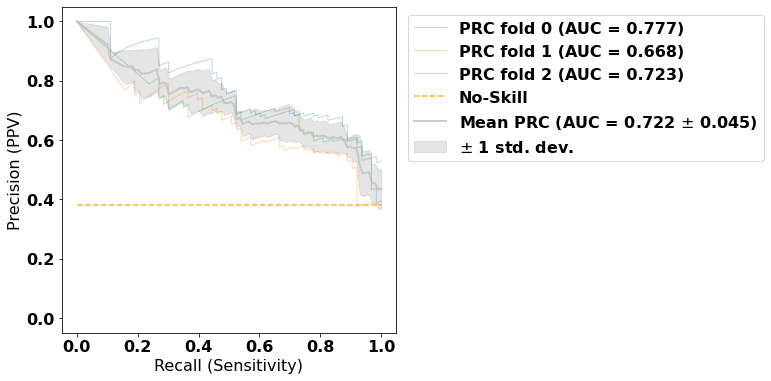

Logistic Regression


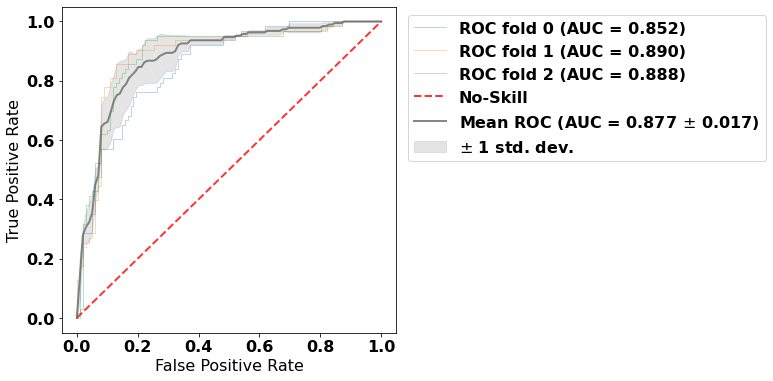

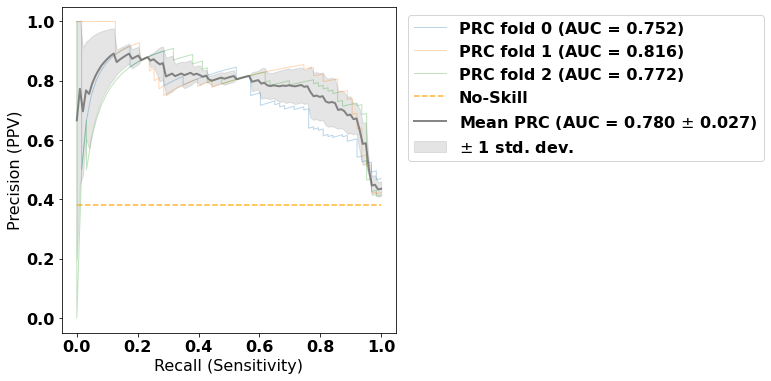

Decision Tree


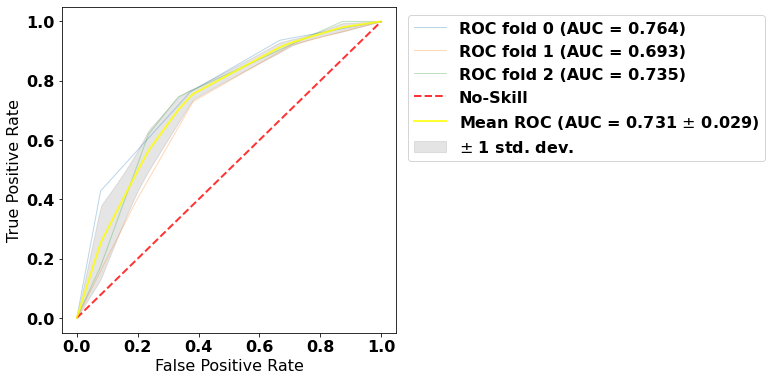

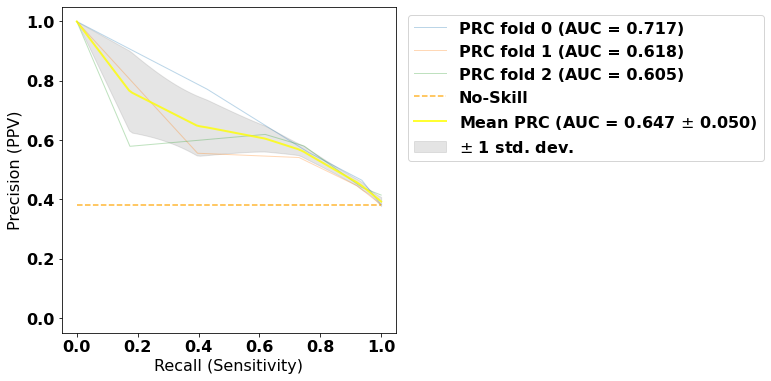

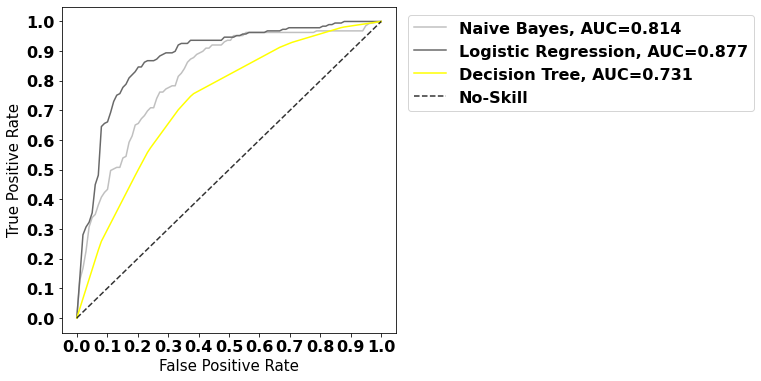

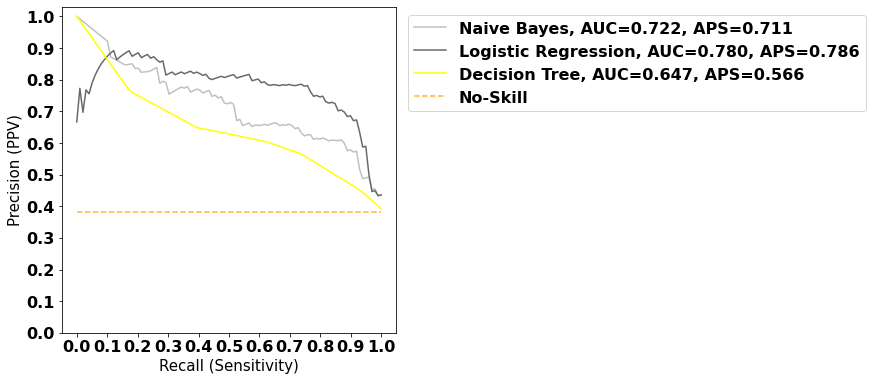

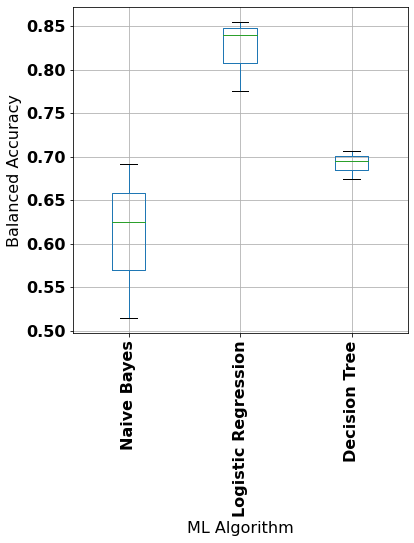

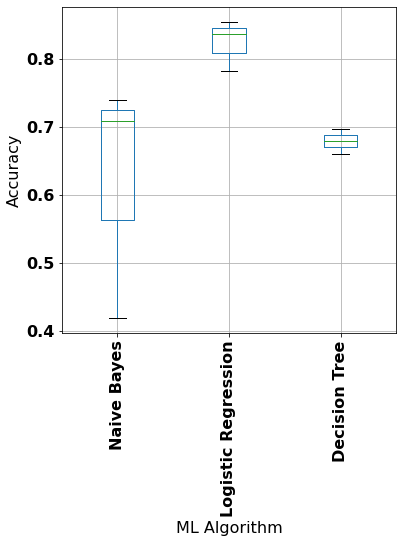

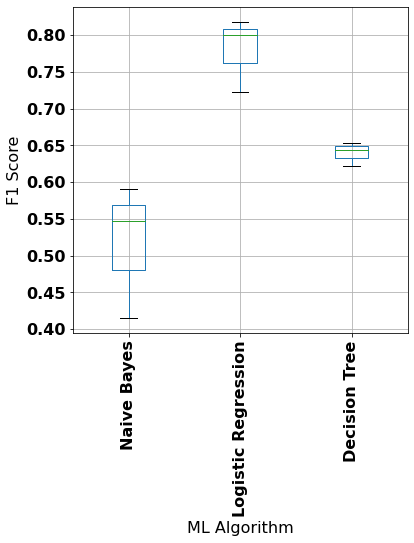

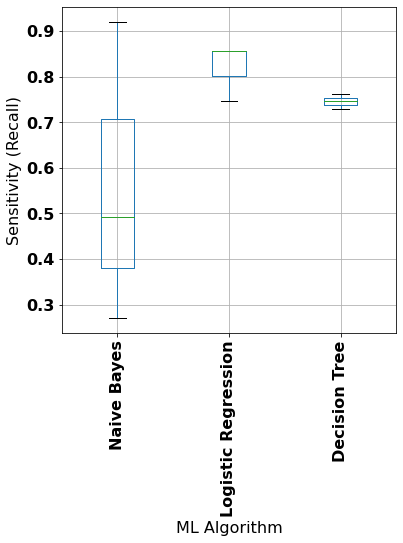

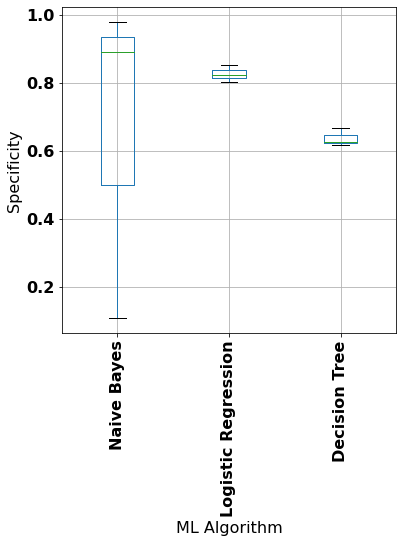

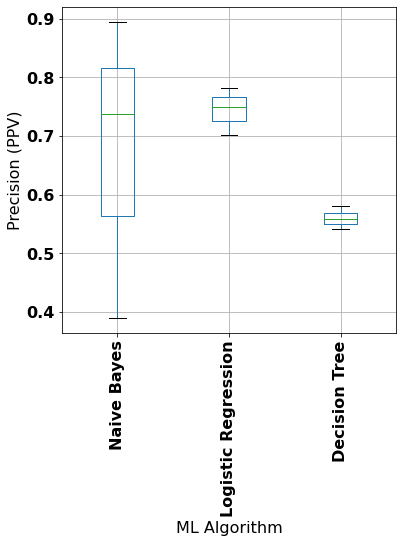

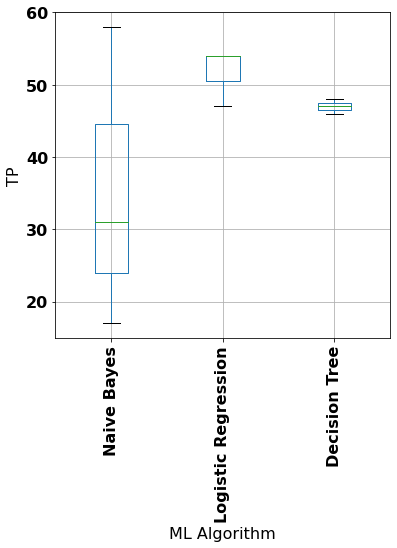

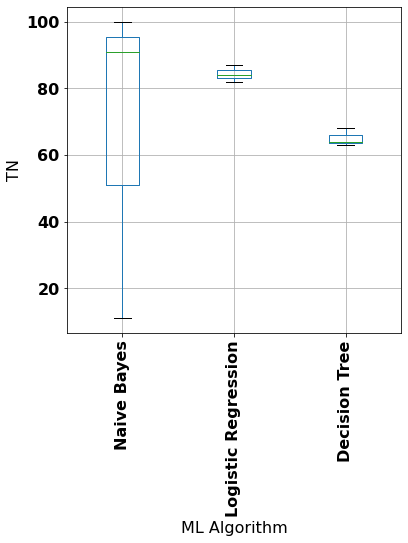

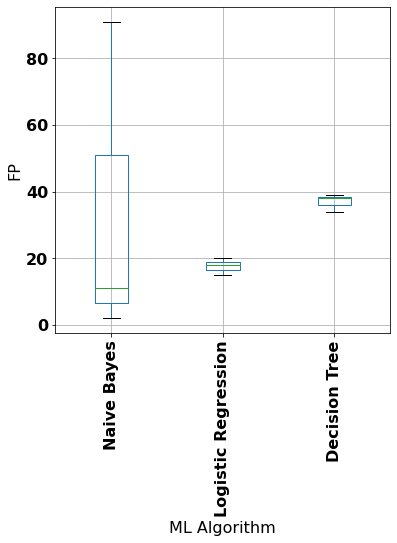

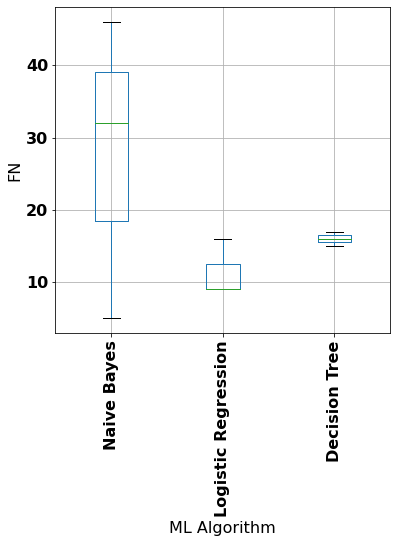

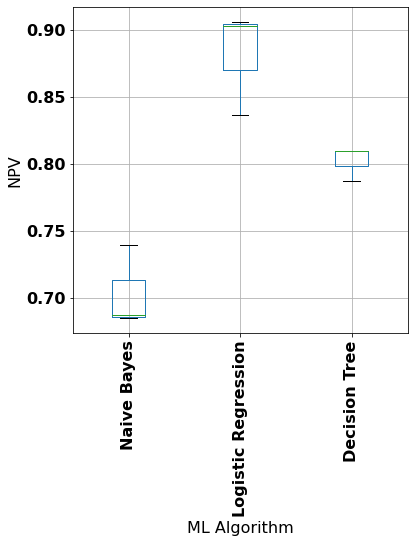

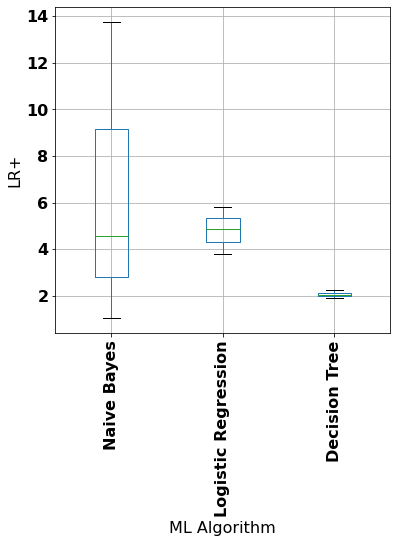

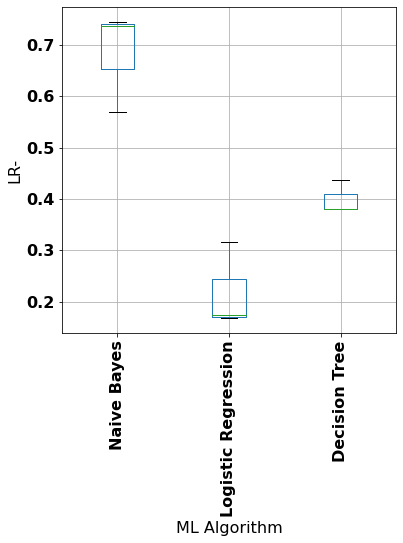

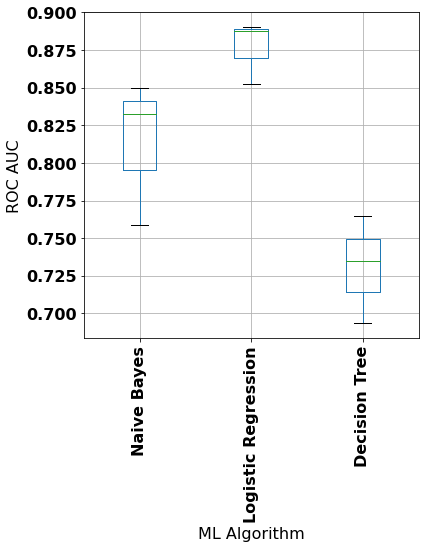

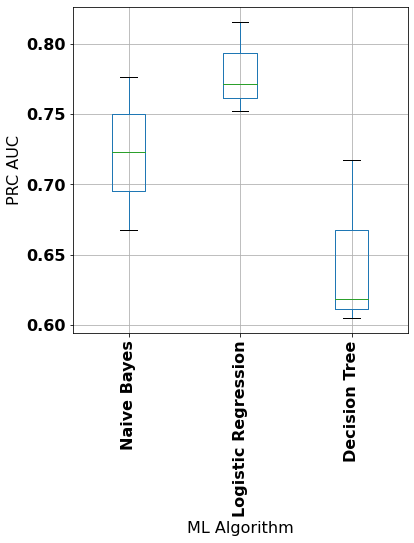

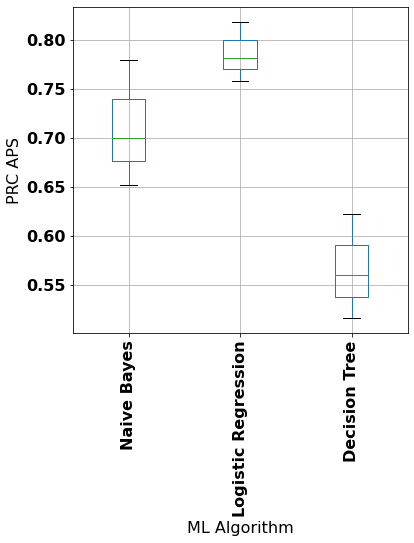

hcc-data_example_rep phase 9 complete


In [34]:
if applyToReplication:
    data_name = dataset_for_rep.split('/')[-1].split('.')[0] #Save unique dataset names so that analysis is run only once if there is both a .txt and .csv version of dataset with same name.
    full_path = output_path + "/" + experiment_name + "/" + data_name #location of folder containing models respective training dataset

    if not os.path.exists(full_path+"/applymodel"):
        os.mkdir(full_path+"/applymodel")

    #Determine file extension of datasets in target folder:
    file_count = 0
    unique_datanames = []
    for datasetFilename in glob.glob(rep_data_path+'/*'):
        datasetFilename = str(datasetFilename).replace('\\','/')

        file_extension = datasetFilename.split('/')[-1].split('.')[-1]
        apply_name = datasetFilename.split('/')[-1].split('.')[0] #Save unique dataset names so that analysis is run only once if there is both a .txt and .csv version of dataset with same name.
        if not os.path.exists(full_path+"/applymodel/"+apply_name):
            os.mkdir(full_path+"/applymodel/"+apply_name)

        if file_extension == 'txt' or file_extension == 'csv':
            if apply_name not in unique_datanames:
                unique_datanames.append(apply_name)
                ApplyModelJob.job(datasetFilename,full_path,class_label,instance_label,categorical_cutoff,sig_cutoff,cv_partitions,scale_data,impute_data,primary_metric,dataset_for_rep,match_label,plot_ROC,plot_PRC,plot_metric_boxplots,export_feature_correlations,jupyterRun,multi_impute)
                file_count += 1

    if file_count == 0: #Check that there was at least 1 dataset
        raise Exception("There must be at least one .txt or .csv dataset in rep_data_path directory")

## -----------------------------------------------------------------------------------------------------------------
## Phase 10: PDF Apply Report Generator (Optional)

In [35]:
import PDF_ReportJob

In [36]:
if applyToReplication:
    experiment_path = output_path+'/'+experiment_name
    PDF_ReportJob.job(experiment_path,'False',rep_data_path,dataset_for_rep)

2022-06-14 18:01:07.713795
Starting Report
Publishing Model Prediction Summary
Publishing Average Model Prediction Statistics
Publishing Median Model Prediction Statistics
Phase 10 complete


## -----------------------------------------------------------------------------------------------------------------
## Phase 11: File Cleanup (Optional)

In [37]:
import shutil

In [38]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)
experiment_name = experiment_path.split('/')[-1] #Name of experiment folder
removeList = removeList = ['metadata.pickle','metadata.csv','algInfo.pickle','jobsCompleted','logs','jobs','DatasetComparisons','UsefulNotebooks',experiment_name+'_ML_Pipeline_Report.pdf']
for text in removeList:
    if text in datasets:
        datasets.remove(text)

#Delete jobscompleted folder/files
try:
    shutil.rmtree(experiment_path+'/'+'jobsCompleted')
except:
    pass

#Delete target files within each dataset subfolder
for dataset in datasets:
    #Delete individual runtime files (save runtime summary generated in phase 6)
    if eval(del_time):
        try:
            shutil.rmtree(experiment_path+'/'+dataset+'/'+'runtime')
            print("Individual Runtime Files Deleted")
        except:
            pass
    #Delete temporary feature importance pickle files (only needed for phase 4 and then saved as summary files in phase 6)
    try:
        shutil.rmtree(experiment_path+'/'+dataset+'/feature_selection/mutualinformation/pickledForPhase4')
        print("Mutual Information Pickle Files Deleted")
    except:
        pass
    try:
        shutil.rmtree(experiment_path+'/'+dataset+'/feature_selection/multisurf/pickledForPhase4')
        print("MultiSURF Pickle Files Deleted")
    except:
        pass
    #Delete older training and testing CV datasets (does not delete any final versions used for training). Older cv datasets might have been kept to see what they look like prior to preprocessing and feature selection.
    if eval(del_oldCV):
        #Delete CV files generated after preprocessing but before feature selection
        files = glob.glob(experiment_path+'/'+dataset+'/CVDatasets/*CVOnly*')
        for f in files:
            try:
                os.remove(f)
                print("Deleted Intermediary CV-Only Dataset Files")
            except:
                pass
        #Delete CV files generated after CV partitioning but before preprocessing
        files = glob.glob(experiment_path+'/'+dataset+'/CVDatasets/*CVPre*')
        for f in files:
            try:
                os.remove(f)
                print("Deleted Intermediary CV-Pre Dataset Files")
            except:
                pass

Individual Runtime Files Deleted
Mutual Information Pickle Files Deleted
MultiSURF Pickle Files Deleted
Individual Runtime Files Deleted
Mutual Information Pickle Files Deleted
MultiSURF Pickle Files Deleted
